In [1]:
%pip install numpy
%pip install matplotlib
%pip install numba
%pip install numpy==2.1
%pip install numpy matplotlib pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from numba import njit

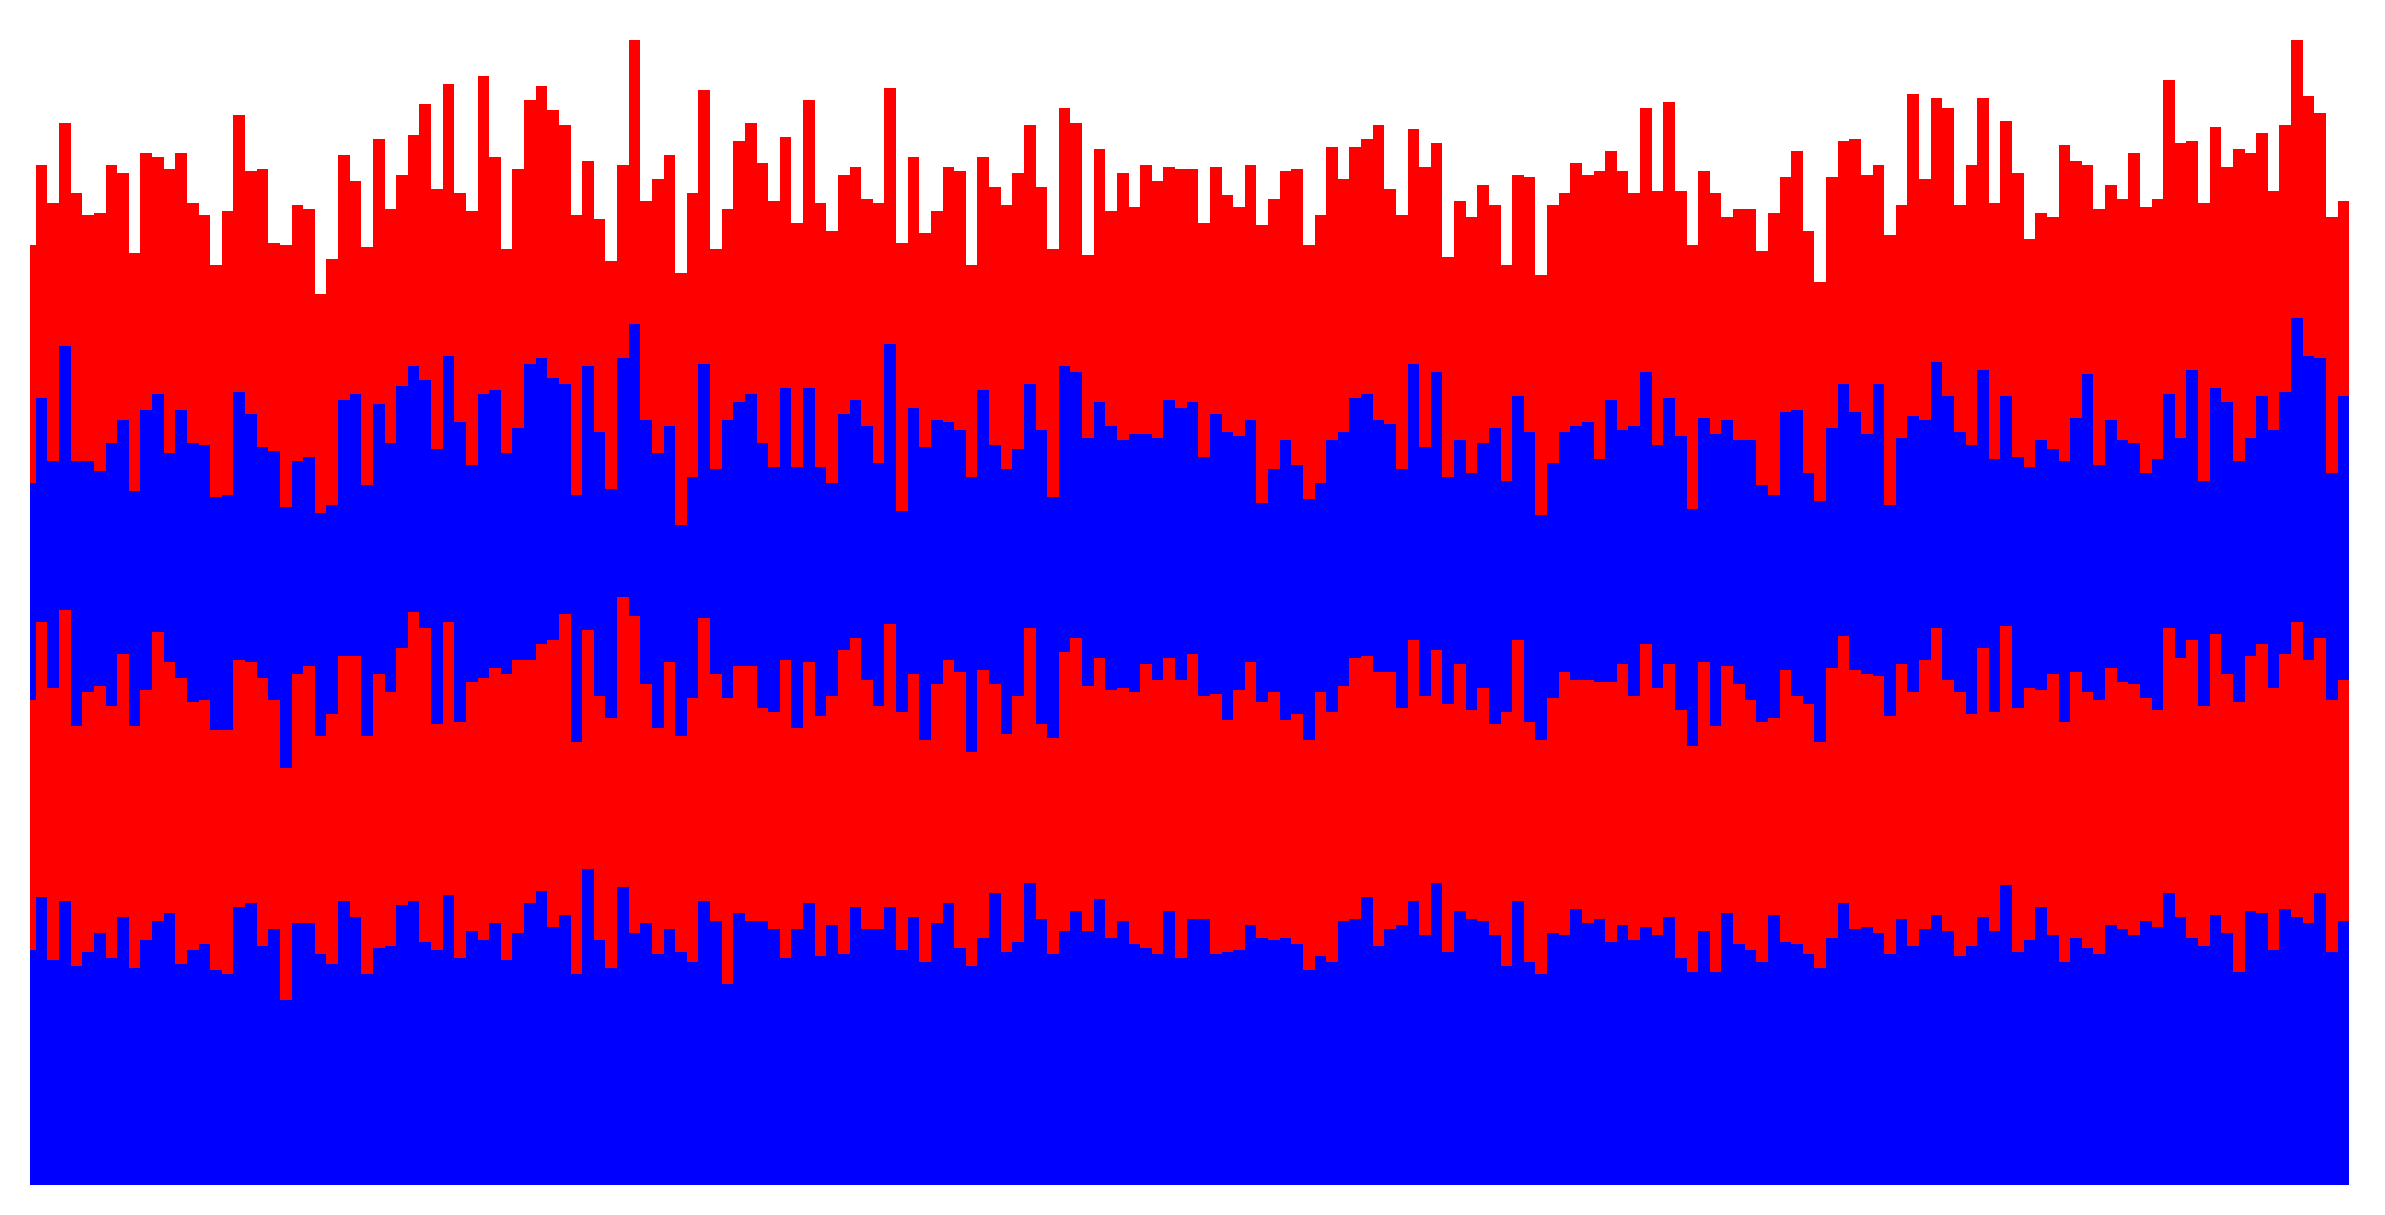

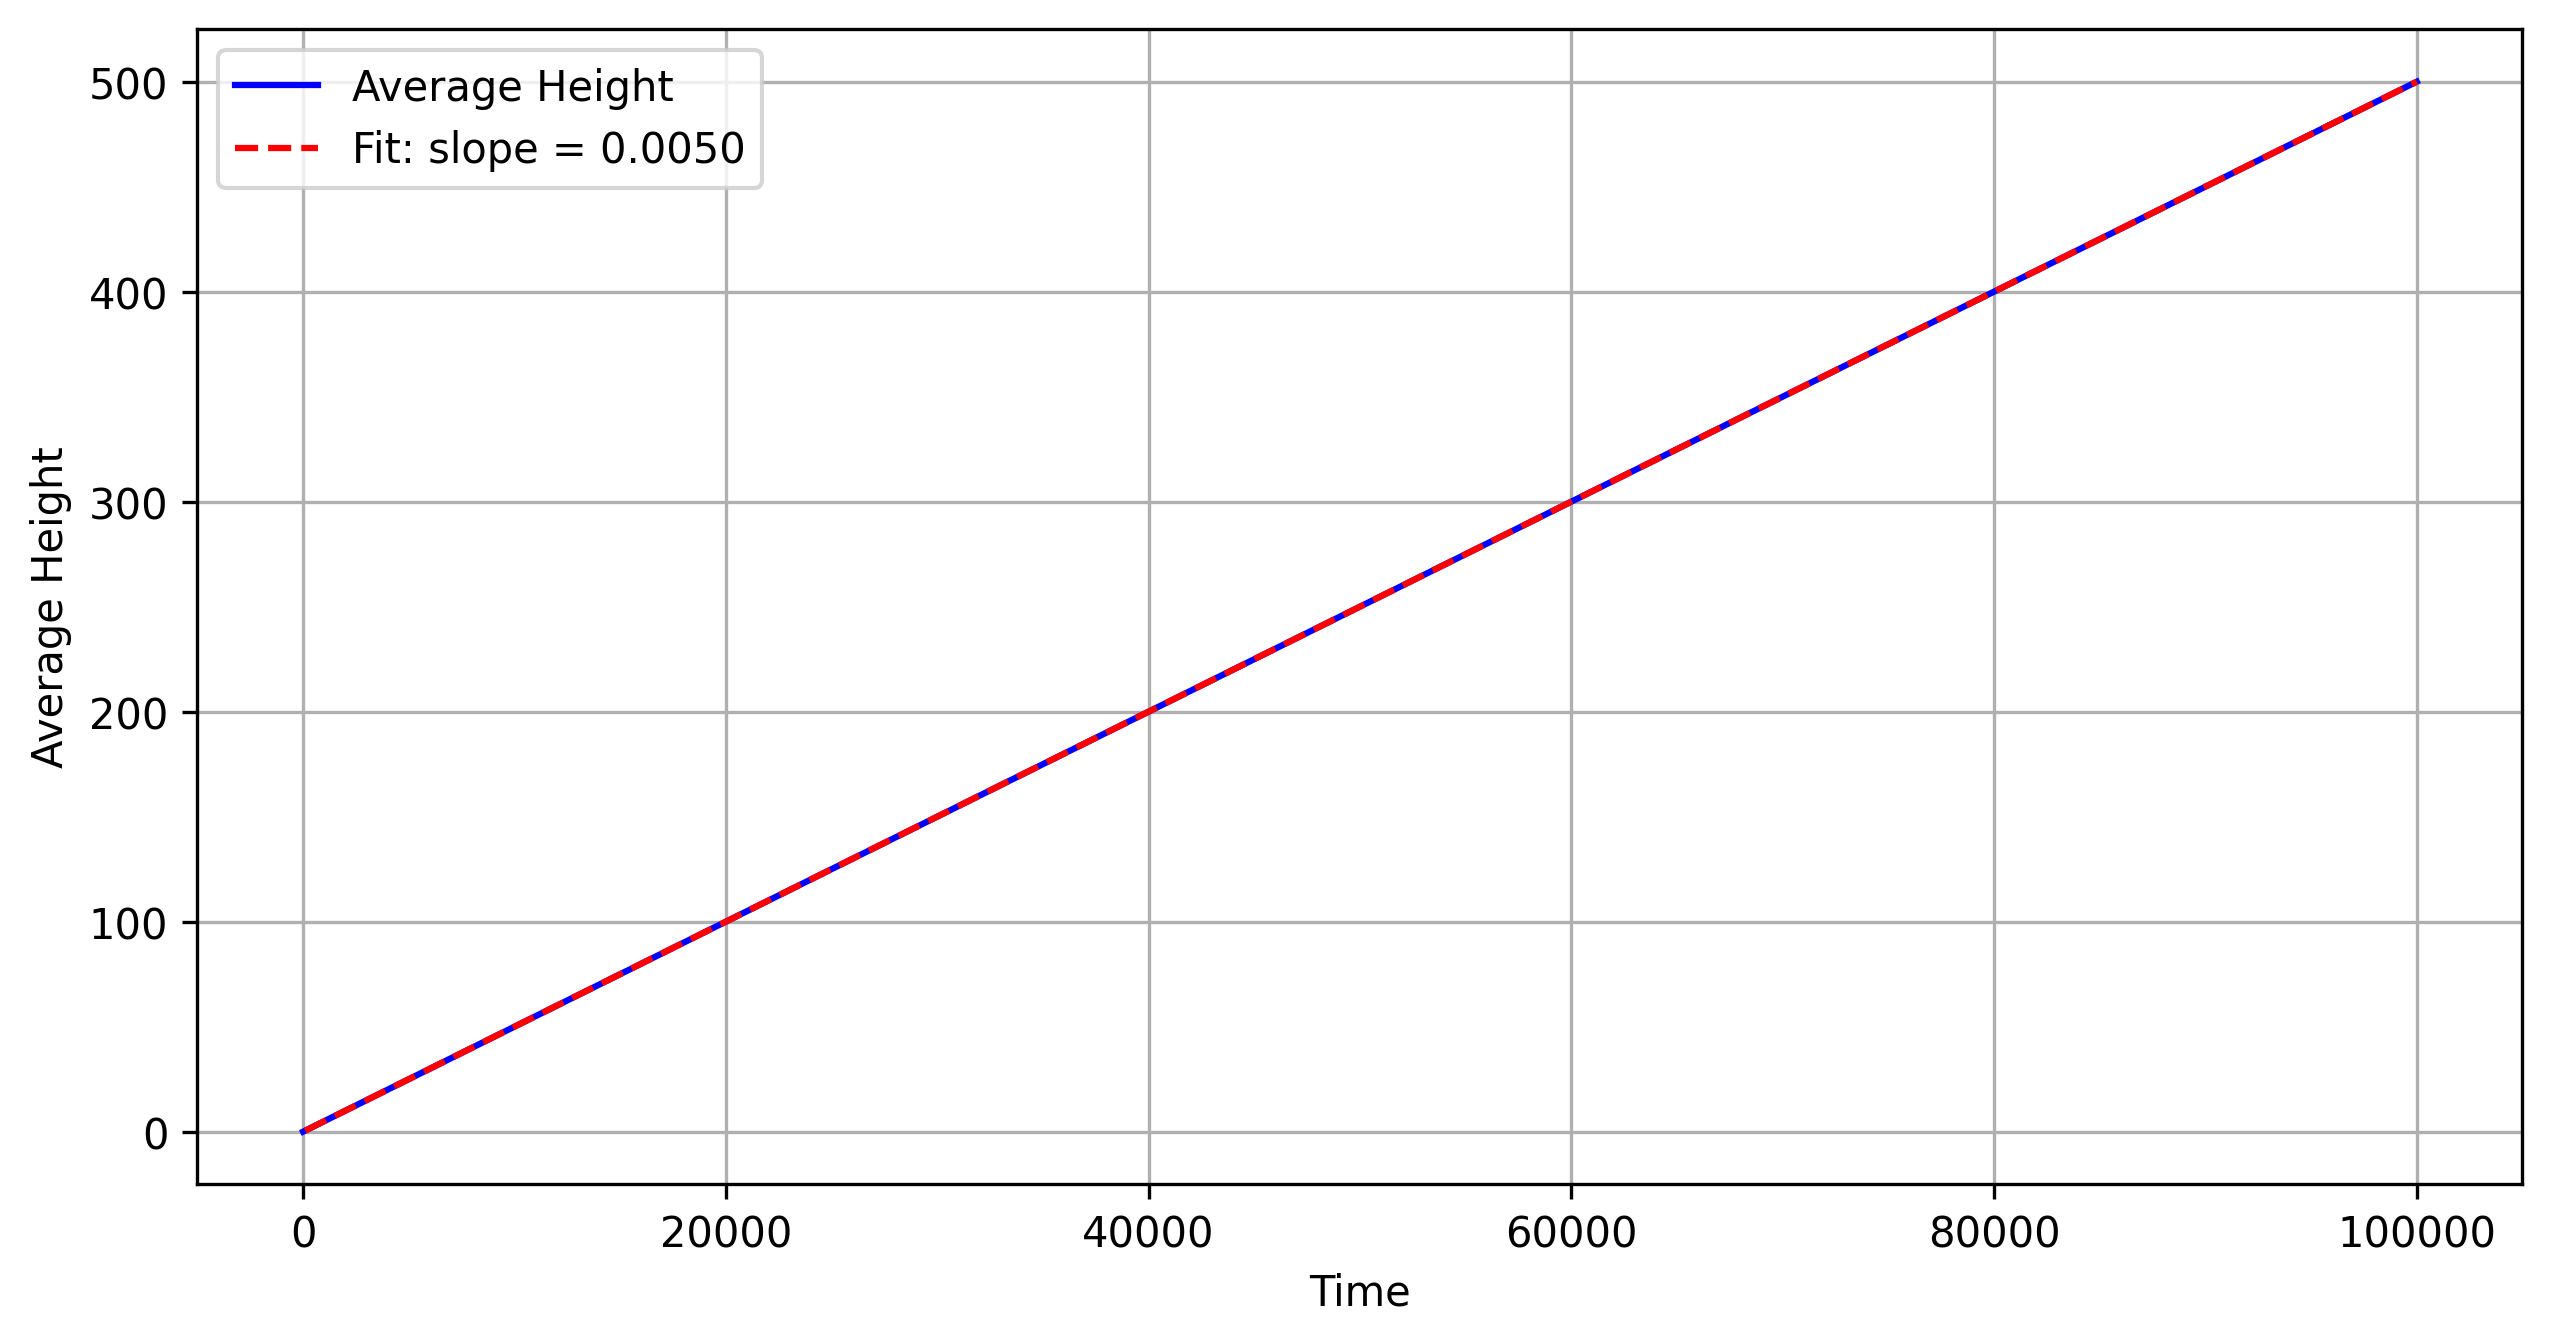

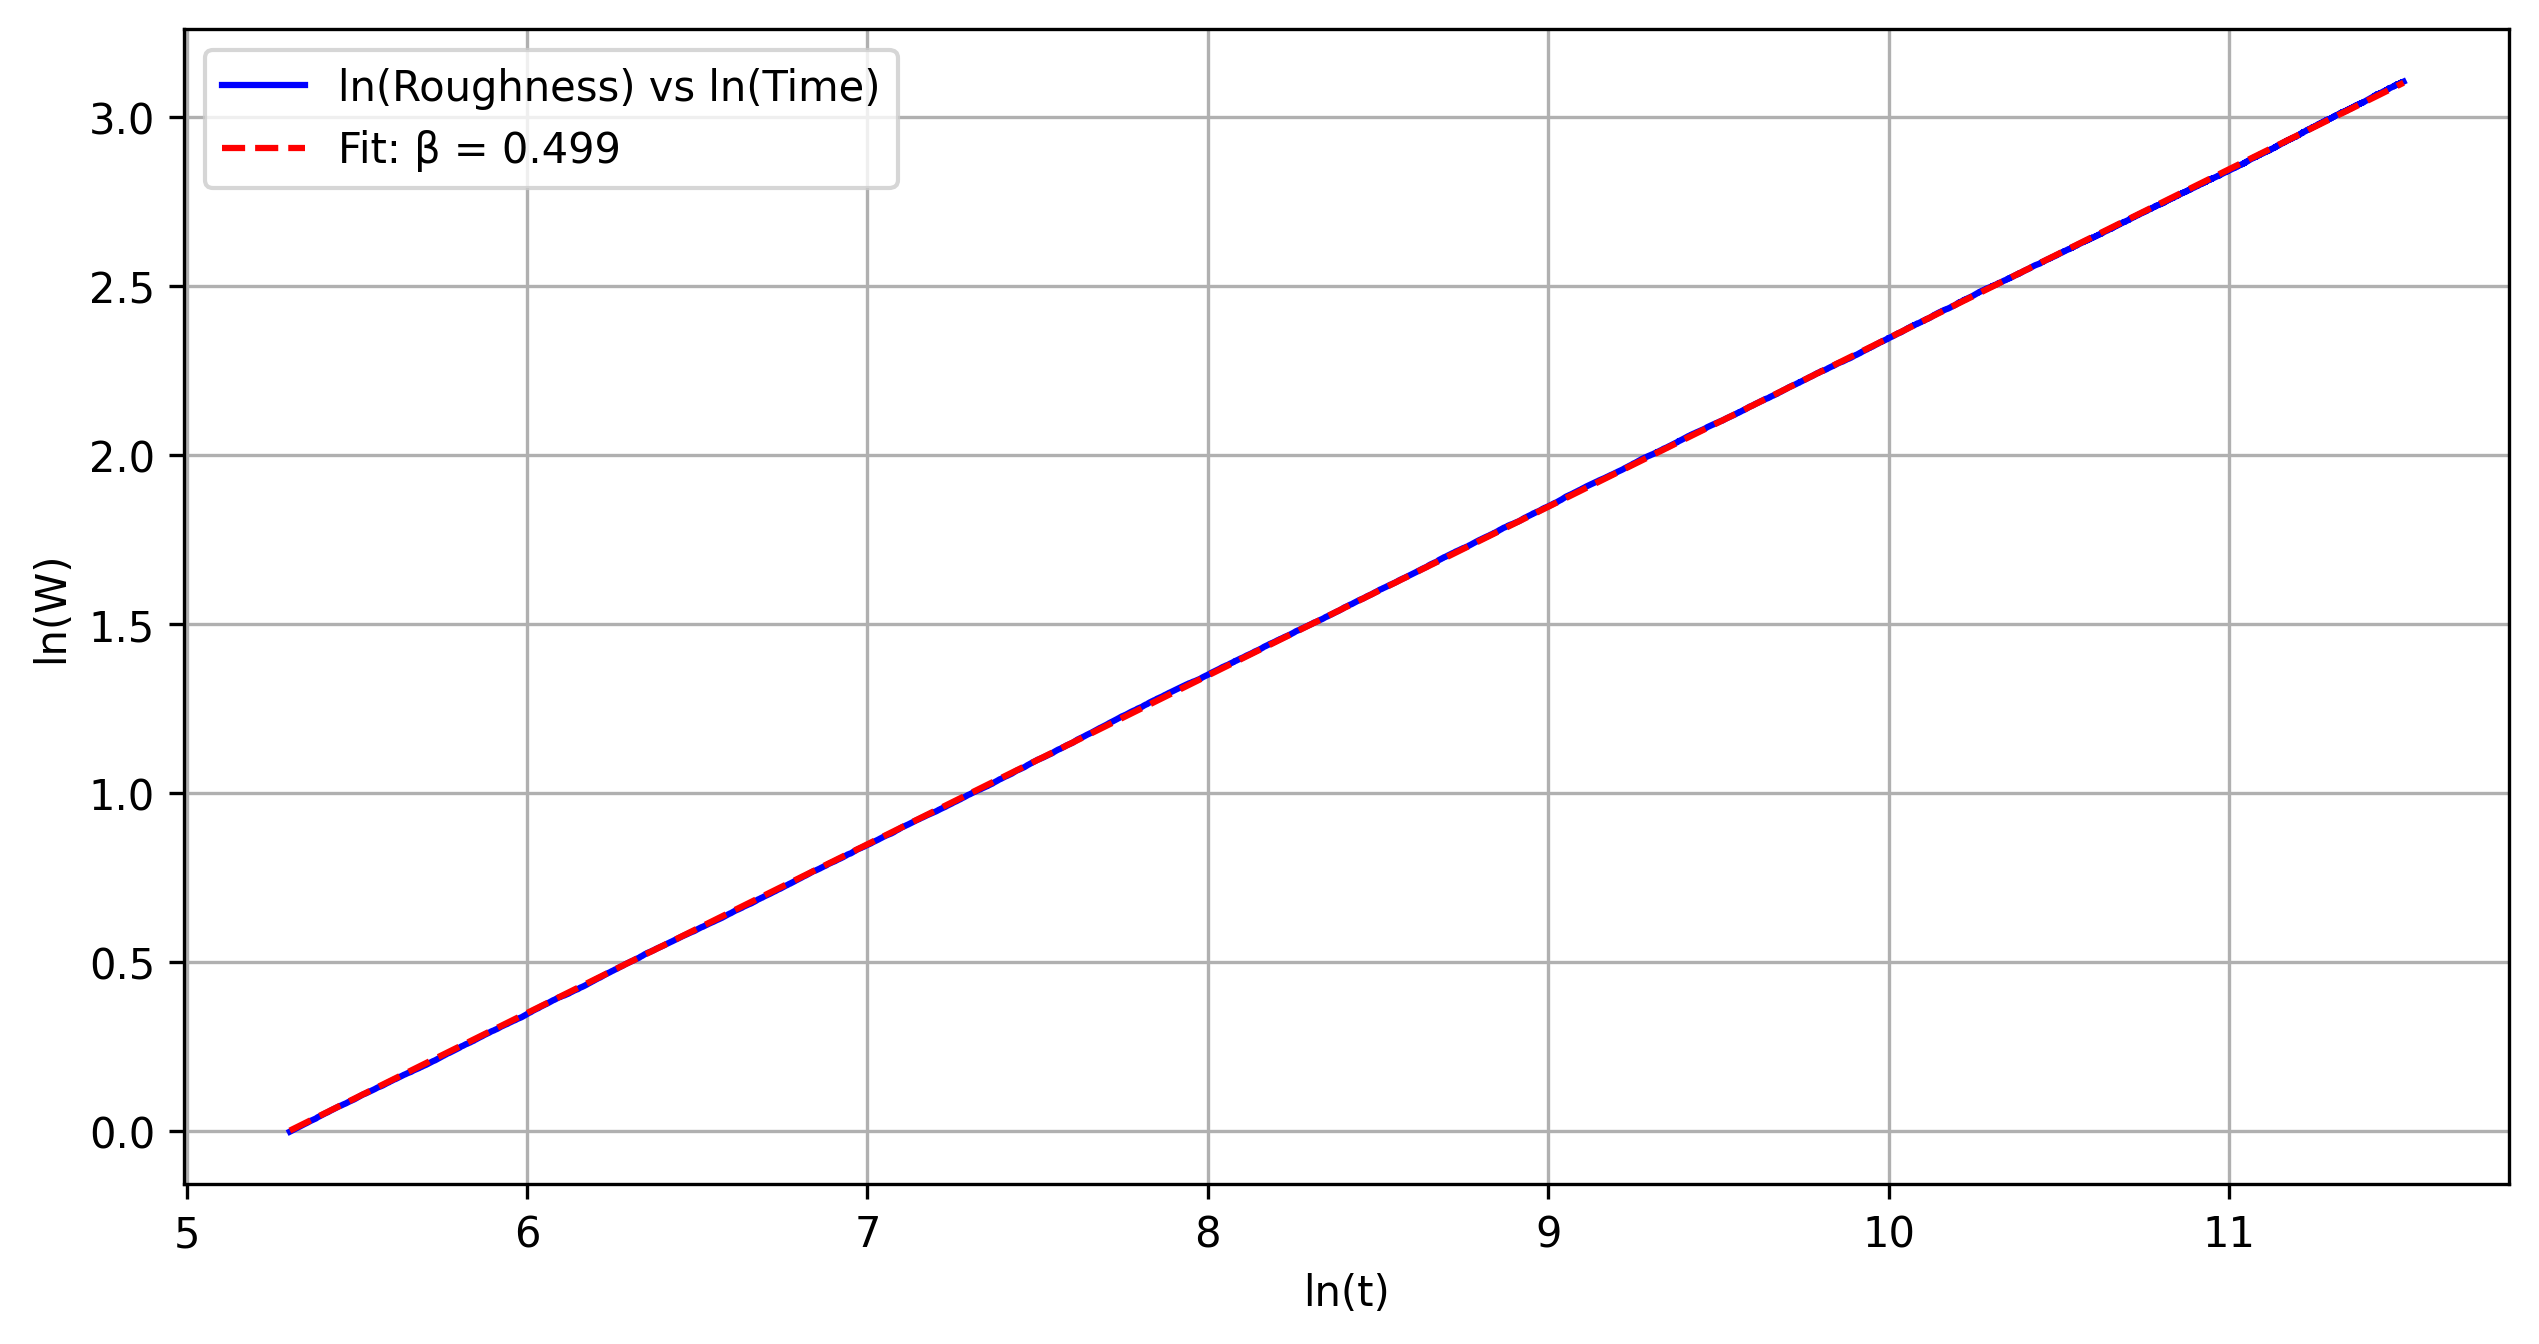

Estimated growth exponent β = 0.4992


In [98]:
width = 200
num_particles = 100000
num_runs = 200
step_interval = num_particles // 4
num_intervals = num_particles // step_interval
start_fit = 100

@njit
def simulate_run():
    deposit_count = np.zeros((num_intervals, width), dtype=np.int32)
    surface = np.zeros(width, dtype=np.int32)
    avg_heights = np.zeros(num_particles, dtype=np.float64)
    roughness = np.zeros(num_particles, dtype=np.float64)
    
    for step in range(num_particles):
        x = np.random.randint(0, width)
        interval_idx = step // step_interval
        deposit_count[interval_idx, x] += 1
        surface[x] += 1
        avg_heights[step] = surface.mean()
        roughness[step] = surface.std()
        
    return deposit_count, surface, avg_heights, roughness

def plot_data(x, y, xlabel, ylabel, title, filename, color='blue', loglog=False):
    plt.figure(figsize=(10, 5), dpi=300)
    plt.loglog(x, y, color=color) if loglog else plt.plot(x, y, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()

roughness_runs = np.zeros((num_runs, num_particles))
first_run = simulate_run()

for run in range(num_runs):
    _, _, _, roughness = simulate_run()
    roughness_runs[run] = roughness

avg_roughness = roughness_runs.mean(axis=0)
time = np.arange(1, num_particles + 1)

log_t = np.log(time[start_fit:])
log_w = np.log(avg_roughness[start_fit:])
beta, intercept_beta, *_ = linregress(log_t[100:], log_w[100:])

deposit_count, surface, avg_heights, roughness = first_run

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.set_xlim(0, width)
ax.set_ylim(0, max(surface) + 5)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

bottom_heights = np.zeros(width, dtype=int)
for i in range(num_intervals):
    color = 'blue' if i % 2 == 0 else 'red'
    start = i * step_interval
    end = min((i + 1) * step_interval - 1, num_particles - 1)
    ax.bar(range(width),
           deposit_count[i, :],
           bottom=bottom_heights,
           color=color,
           width=1.0,
           label=f"Particle {start}-{end}")
    bottom_heights += deposit_count[i, :]

plt.savefig('Random_Deposition_Surface.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

slope, intercept, *_ = linregress(time[start_fit:], avg_heights[start_fit:])

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(time, avg_heights, 'b-', label='Average Height')
plt.plot(time[start_fit:], intercept + slope * time[start_fit:], 'r--', 
         label=f'Fit: slope = {slope:.4f}')
plt.xlabel('Time')
plt.ylabel('Average Height')
#plt.title('Average Height vs Time')
plt.legend()
plt.grid(True)

plt.savefig('avg_height_RD.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 5), dpi=300)

plt.plot(log_t[100:], log_w[100:], 'b-', label='ln(Roughness) vs ln(Time)')

plt.plot(log_t[100:], intercept_beta + beta * log_t[100:], 'r--', 
         label=f'Fit: β = {beta:.3f}')

plt.xlabel('ln(t)')
plt.ylabel('ln(W)')
#plt.title('ln(Roughness) vs ln(Time)')
plt.grid(True)
plt.legend()

plt.savefig('rd_ln_roughness_vs_ln_time.png', dpi=300)
plt.show()

print(f"Estimated growth exponent β = {beta:.4f}")

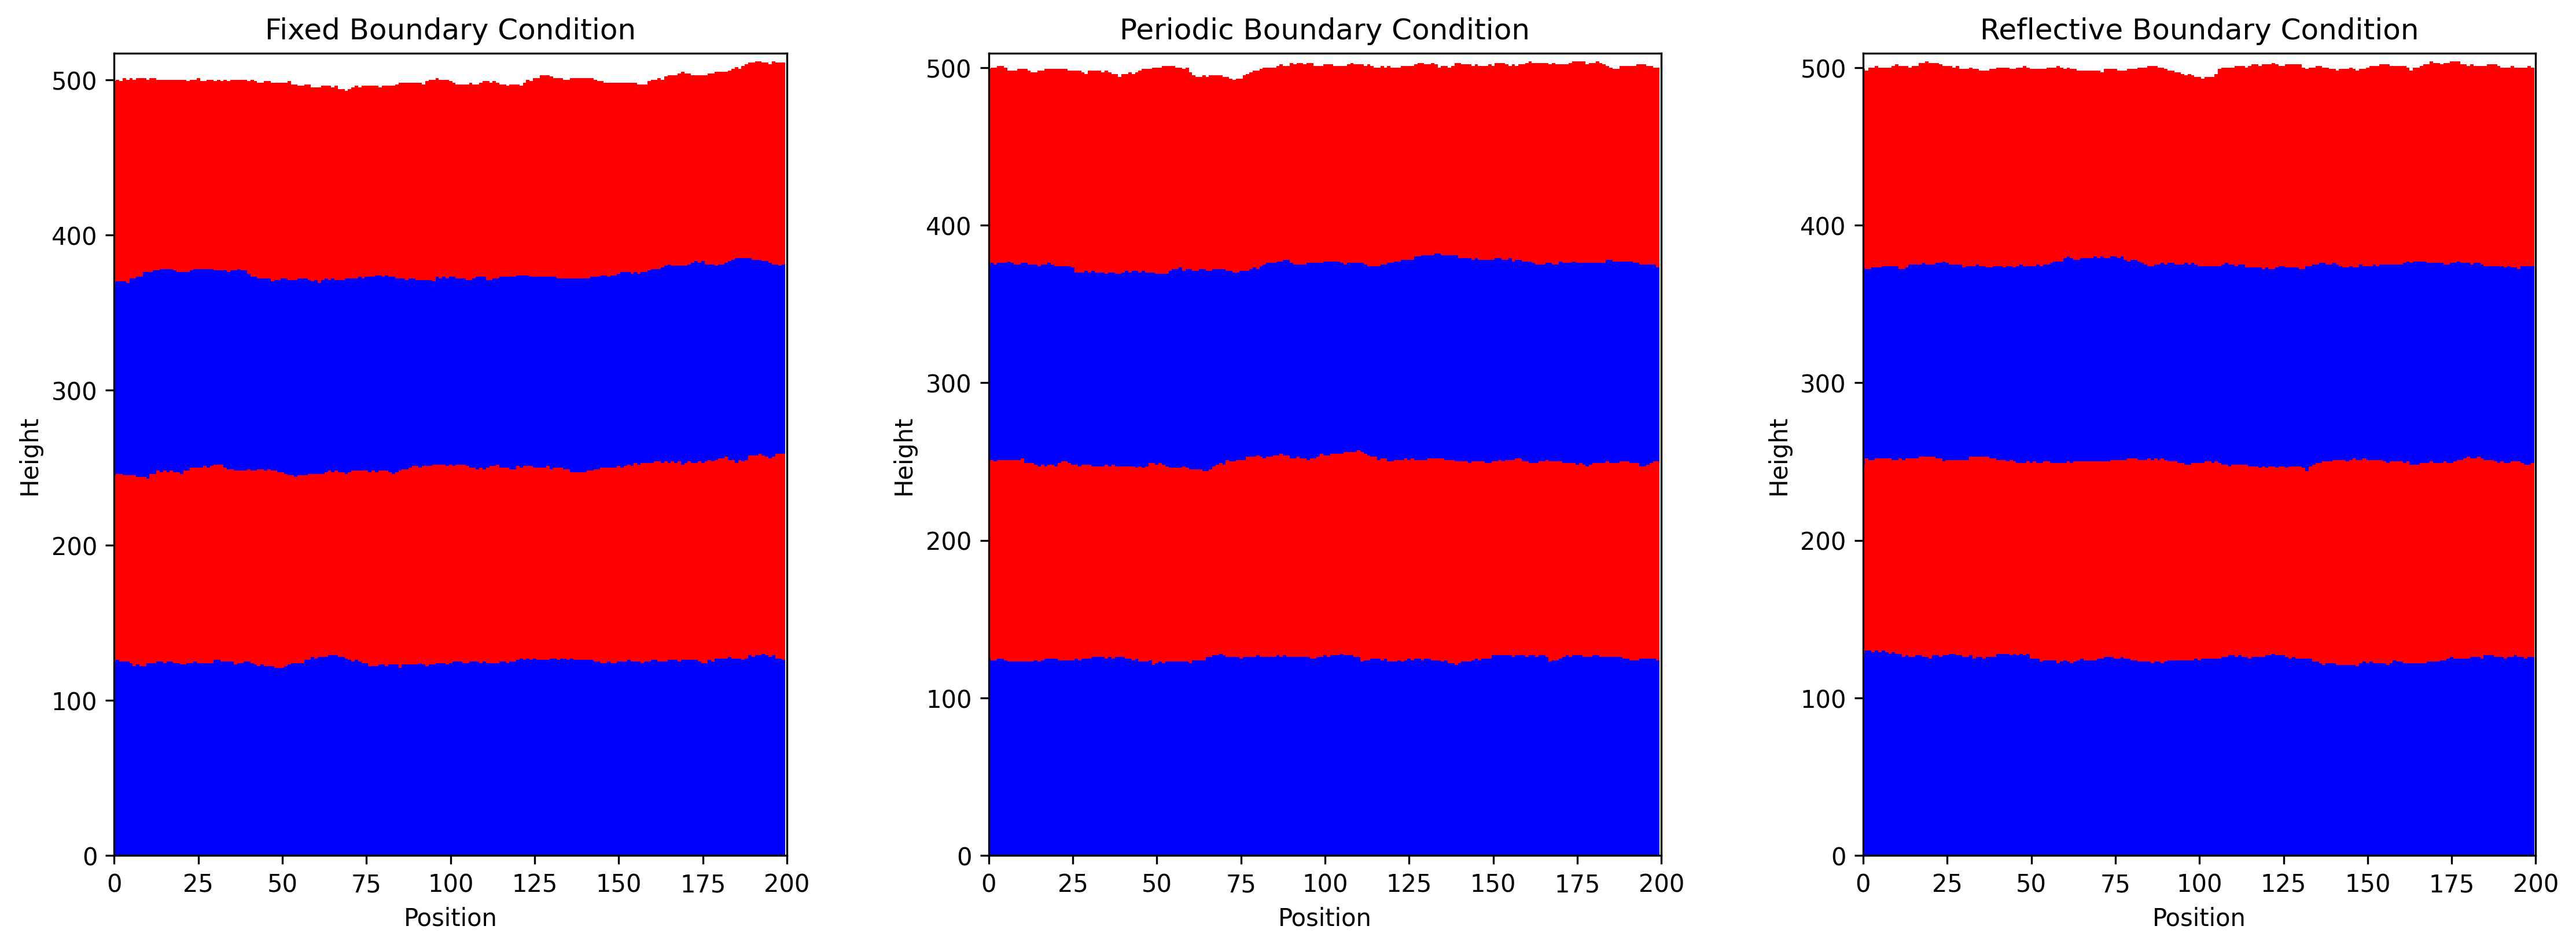

In [ ]:
def relaxed_deposition_step(surface, x, boundary='periodic'):
    L = len(surface)
    candidates = []
    
    if boundary == 'fixed':
        if x == 0:
            candidates = [0, 1]
        elif x == L-1:
            candidates = [L-2, L-1]
        else:
            candidates = [x-1, x, x+1]
            
    elif boundary == 'periodic':
        left = (x-1) % L
        right = (x+1) % L
        candidates = [left, x, right]
        
    elif boundary == 'reflective':
        if x == 0:
            candidates = [0, 0, 1]
        elif x == L-1:
            candidates = [L-2, L-1, L-1]
        else:
            candidates = [x-1, x, x+1]


    min_height = min(surface[c] for c in candidates)
    min_sites = [c for c in candidates if surface[c] == min_height]
    
    return np.random.choice(min_sites)

def simulate_with_boundary(width, num_particles, boundary):
    num_intervals = num_particles // (num_particles // 4)
    deposit_count = np.zeros((num_intervals, width), dtype=int)
    surface = np.zeros(width, dtype=int)
    
    step_interval = num_particles // num_intervals
    
    for i in range(num_intervals):
        for _ in range(step_interval):
            x = np.random.randint(width)
            deposit_site = relaxed_deposition_step(surface, x, boundary)
            surface[deposit_site] += 1
            deposit_count[i, deposit_site] += 1
    
    return deposit_count, surface

width = 200
num_particles = 100000
boundary_conditions = ['fixed', 'periodic', 'reflective']

fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
plt.subplots_adjust(wspace=0.3)

for idx, boundary in enumerate(boundary_conditions):
    deposit_count, surface = simulate_with_boundary(width, num_particles, boundary)
    
    ax = axs[idx]
    ax.set_xlim(0, width)
    ax.set_ylim(0, max(surface) + 5)
    ax.set_xlabel("Position")
    ax.set_ylabel("Height")
    ax.set_title(f"{boundary.capitalize()} Boundary Condition")
    
    bottom_heights = np.zeros(width, dtype=int)
    for i in range(deposit_count.shape[0]):
        color = 'blue' if i % 2 == 0 else 'red'
        start = i * (num_particles // deposit_count.shape[0])
        end = min((i + 1) * (num_particles // deposit_count.shape[0]) - 1, num_particles - 1)
        ax.bar(range(width),
               deposit_count[i, :],
               bottom=bottom_heights,
               color=color,
               width=1.0,
               label=f"Particles {start}-{end}")
        bottom_heights += deposit_count[i, :]

plt.savefig('boundary_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
@njit
def relaxed_deposition_step(surface, x):
    L = surface.shape[0]
    xm = (x - 1) % L
    xp = (x + 1) % L
    h1 = surface[xm]
    h2 = surface[x]
    h3 = surface[xp]
    
    min_h = h1
    if h2 < min_h:
        min_h = h2
    if h3 < min_h:
        min_h = h3
    
    count = 0
    if h1 == min_h:
        count += 1
    if h2 == min_h:
        count += 1
    if h3 == min_h:
        count += 1
    
    r = np.random.randint(count)
    if h1 == min_h:
        if r == 0:
            return xm
        r -= 1
    if h2 == min_h:
        if r == 0:
            return x
        r -= 1
    return xp

@njit
def simulate_system(L, num_particles, num_sims):
    all_roughness = np.empty((num_sims, num_particles))
    
    for sim in range(num_sims):
        surface = np.zeros(L, dtype=np.int64)
        roughness = np.empty(num_particles)
        s2 = 0.0
        
        for t in range(num_particles):
            x = np.random.randint(L)
            j = relaxed_deposition_step(surface, x)
            old_height = surface[j]
            surface[j] += 1
            s2 += 2 * old_height + 1  # (h+1)^2 - h^2 = 2h + 1
            
            mean_height = (t + 1) / L
            roughness[t] = np.sqrt(s2 / L - mean_height ** 2)
        
        all_roughness[sim] = roughness
    
    avg_roughness = np.empty(num_particles)
    for t in range(num_particles):
        total = 0.0
        for sim in range(num_sims):
            total += all_roughness[sim, t]
        avg_roughness[t] = total / num_sims
    
    return avg_roughness

L_values = [50, 100, 200, 300, 400]
num_particles = 10000000
num_sims = 200

results = {}
betas = {}

for L in L_values:
    print(f"Running L={L}...")
    avg_roughness = simulate_system(L, num_particles, num_sims)
    time = np.arange(1, num_particles + 1)
    
    log_time = np.log(time)
    log_roughness = np.log(avg_roughness)
    if L == 50:
        fit_start, fit_end = 40, 350
    elif L == 100:
        fit_start, fit_end = 150, 650
    else:
        fit_start, fit_end = 450, 2500
    slope, intercept, *_ = linregress(
        log_time[fit_start:fit_end], log_roughness[fit_start:fit_end]
    )
    
    results[L] = (log_time, log_roughness)
    betas[L] = (slope, intercept)
    print(f"L={L}: β={slope:.3f}")

Running L=50...
L=50: β=0.205
Running L=100...
L=100: β=0.241
Running L=200...
L=200: β=0.238
Running L=300...
L=300: β=0.243
Running L=400...
L=400: β=0.243


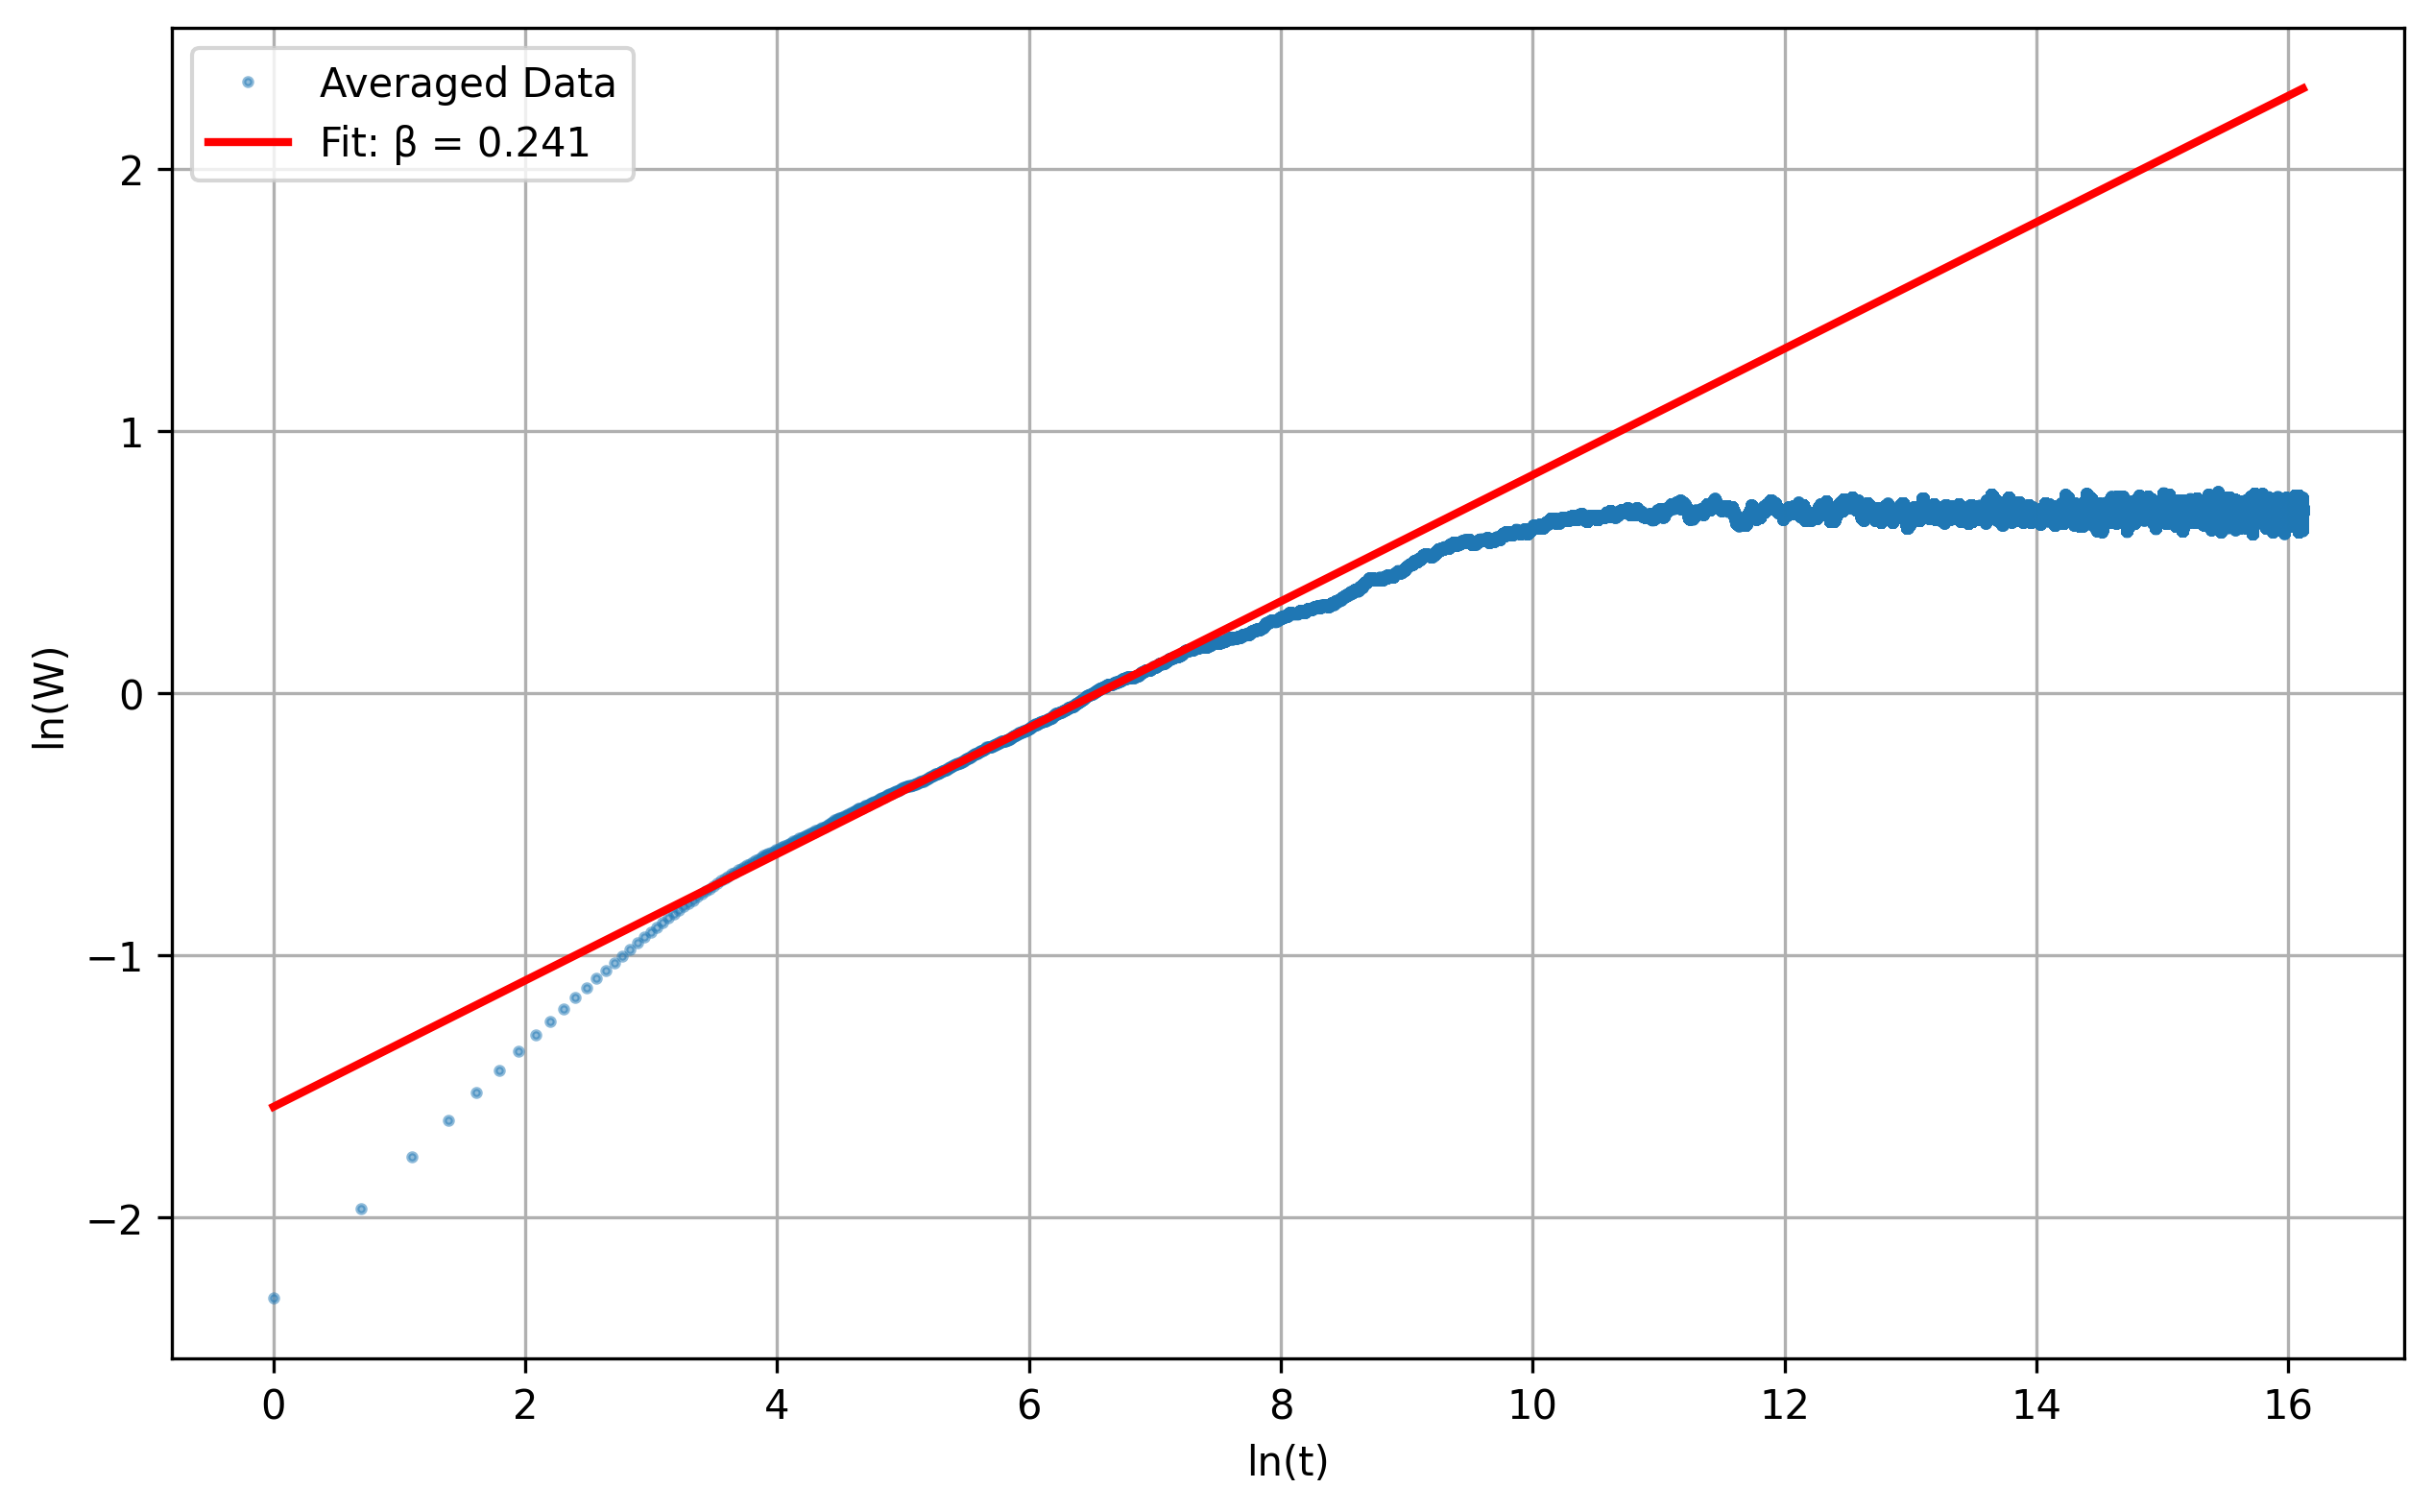

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/1176964981.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BD_Run200.png', bbox_inches='tight')
/Users/kiara/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


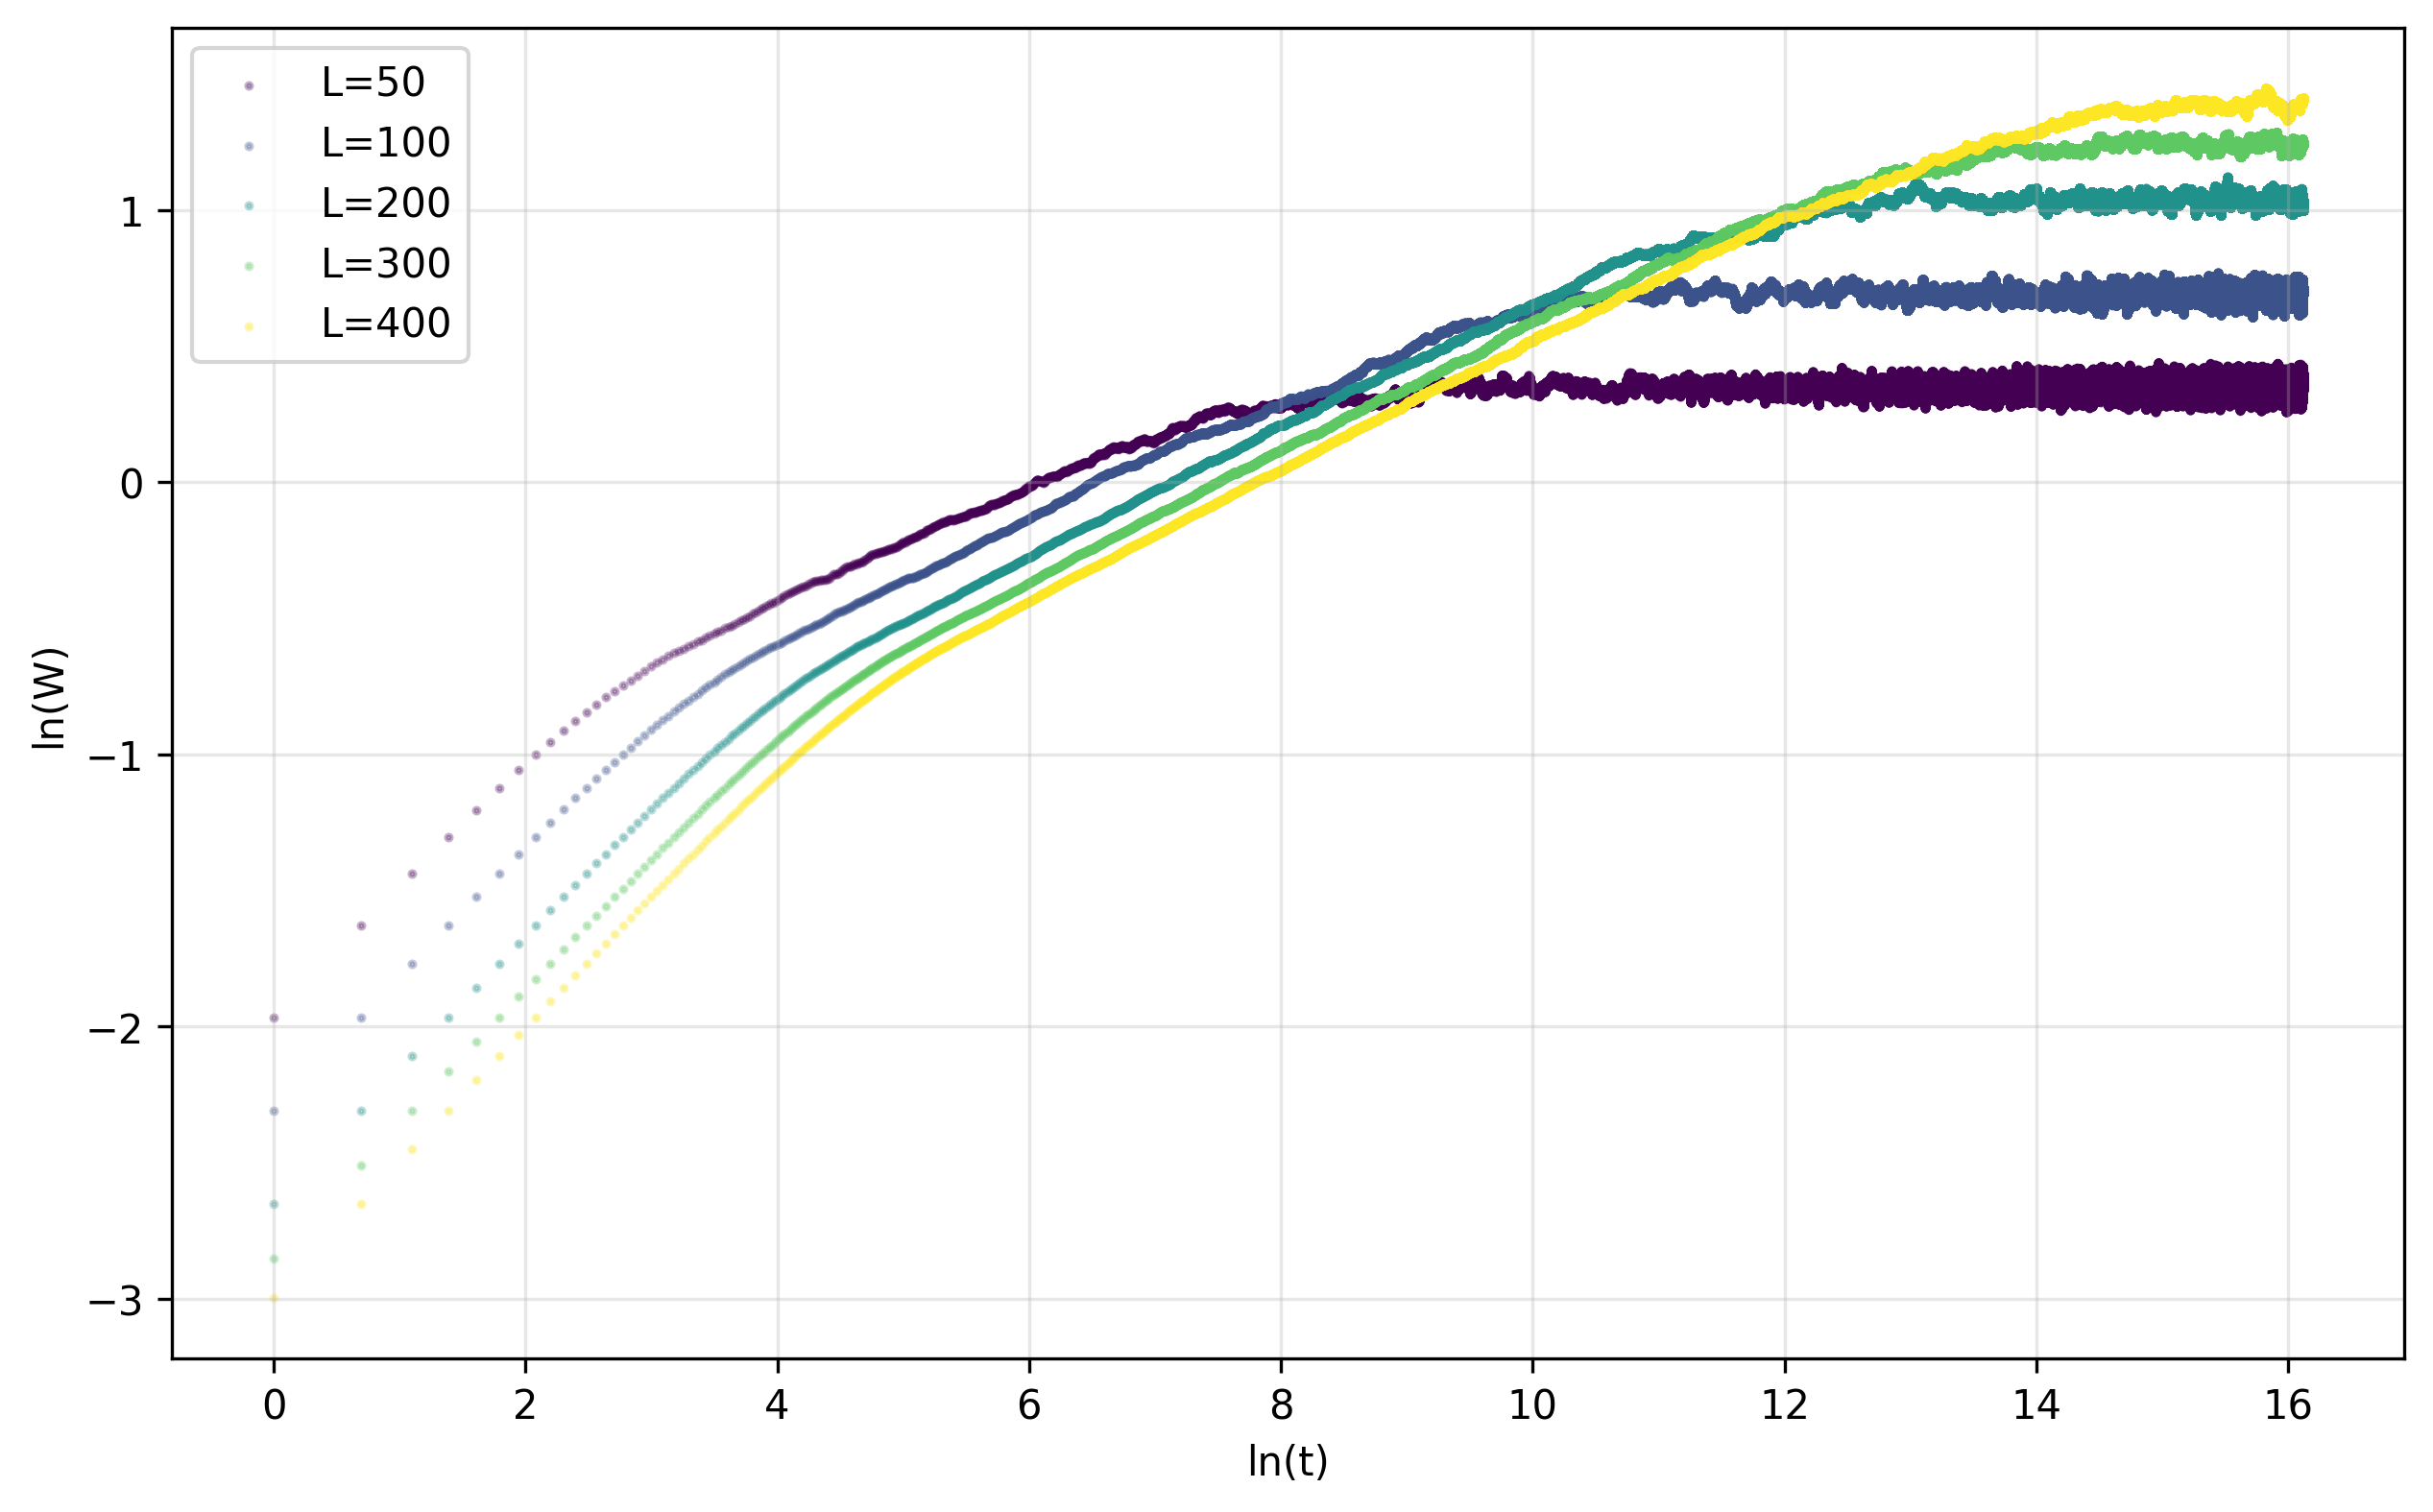

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))

# Plot for L=100
L_special = 100
if L_special in results:
    log_t, log_r = results[L_special]
    beta, intercept = betas[L_special]
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(log_t, log_r, 'o', markersize=2, alpha=0.5, label='Averaged Data')
    plt.plot(log_t, intercept + beta * log_t, 'r-', label=f'Fit: β = {beta:.3f}', linewidth=2)
    plt.xlabel('ln(t)')
    plt.ylabel('ln(W)')
    #plt.title(f'L={L_special}, {num_sims} simulations')
    plt.legend()
    plt.grid(True)
    plt.savefig('RRD_L100_Run200.png', bbox_inches='tight')
    plt.show()

plt.figure(figsize=(10, 6), dpi=300)
for (L, (log_t, log_r)), color in zip(results.items(), colors):
    beta, intercept = betas[L]
    plt.scatter(log_t, log_r, s=2, alpha=0.3, color=color, label=f'L={L}')
    #plt.plot(log_t, intercept + beta * log_t, color=color, lw=1.5)

plt.xlabel('ln(t)')
plt.ylabel('ln(W)')
#plt.title(f'Surface Growth (Averaged over {num_sims} Simulations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('RRD_Run200.png', bbox_inches='tight')
plt.show()

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/1783115683.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent overlap
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/1783115683.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BD_Run200_intersections.png', bbox_inches='tight')


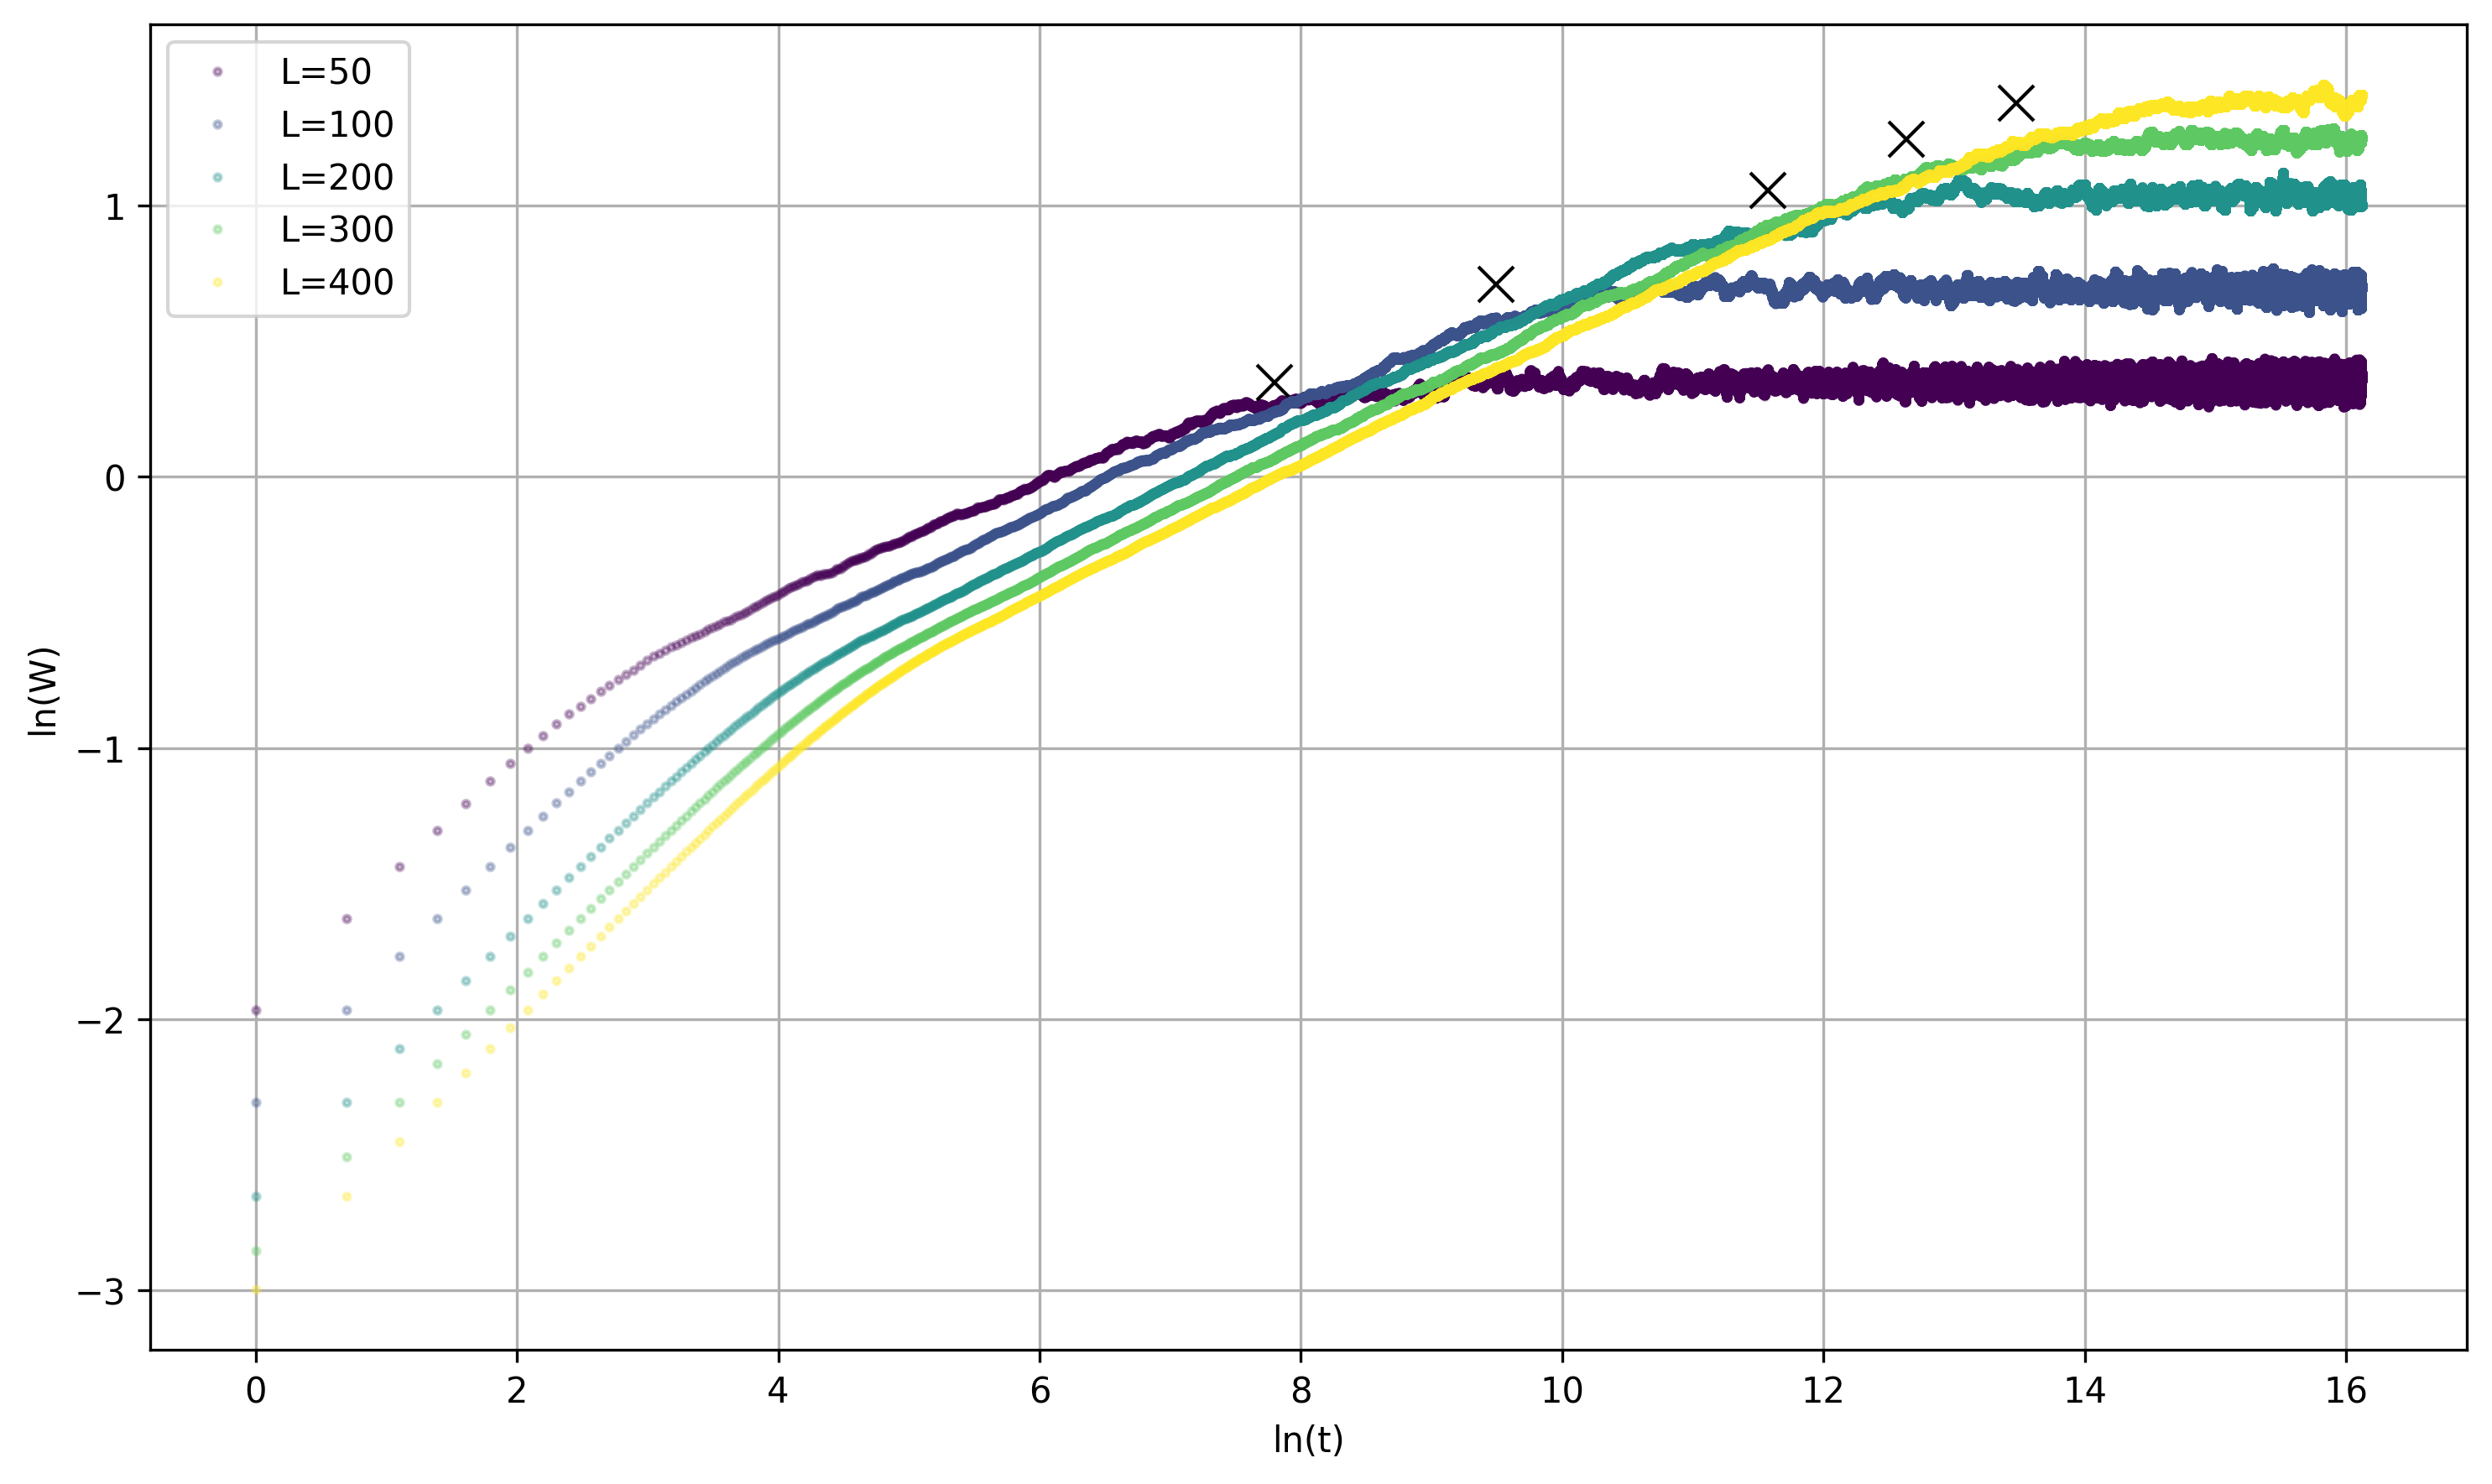

Intersection Points (ln(t), ln(W)):
L = 50: (7.7985, 0.3484)
L = 100: (9.4914, 0.7099)
L = 200: (11.5759, 1.0559)
L = 300: (12.6335, 1.2441)
L = 400: (13.4743, 1.3766)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def find_intersection(slope1, intercept1, slope2, intercept2):
    x_intersect = (intercept2 - intercept1) / (slope1 - slope2)
    y_intersect = slope1 * x_intersect + intercept1
    return x_intersect, y_intersect

plt.figure(figsize=(10, 6), dpi=300)

intersection_points = {}

colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))

for L, color in zip(L_values, colors):
    log_time, log_roughness = results[L]
    beta, intercept = betas[L]
    
    mask2 = np.arange(1, num_particles + 1) >= 0.3 * num_particles
    slope2, intercept2, *_ = linregress(log_time[mask2], log_roughness[mask2])
    
    x_intersect, y_intersect = find_intersection(beta, intercept, slope2, intercept2)
    intersection_points[L] = (x_intersect, y_intersect)
    
    plt.plot(log_time, log_roughness, 'o', markersize=2, alpha=0.3, 
             color=color, label=f'L={L}')
    plt.plot(x_intersect, y_intersect, 'kx', markersize=10)

plt.xlabel('ln(t)')
plt.ylabel('ln(W)')
#plt.title(f'Two-Line Fit and Intersection for Each L')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('RRD_Run200_intersections.png', bbox_inches='tight')
plt.show()

print("Intersection Points (ln(t), ln(W)):")
for L, (x, y) in intersection_points.items():
    print(f"L = {L}: ({x:.4f}, {y:.4f})")

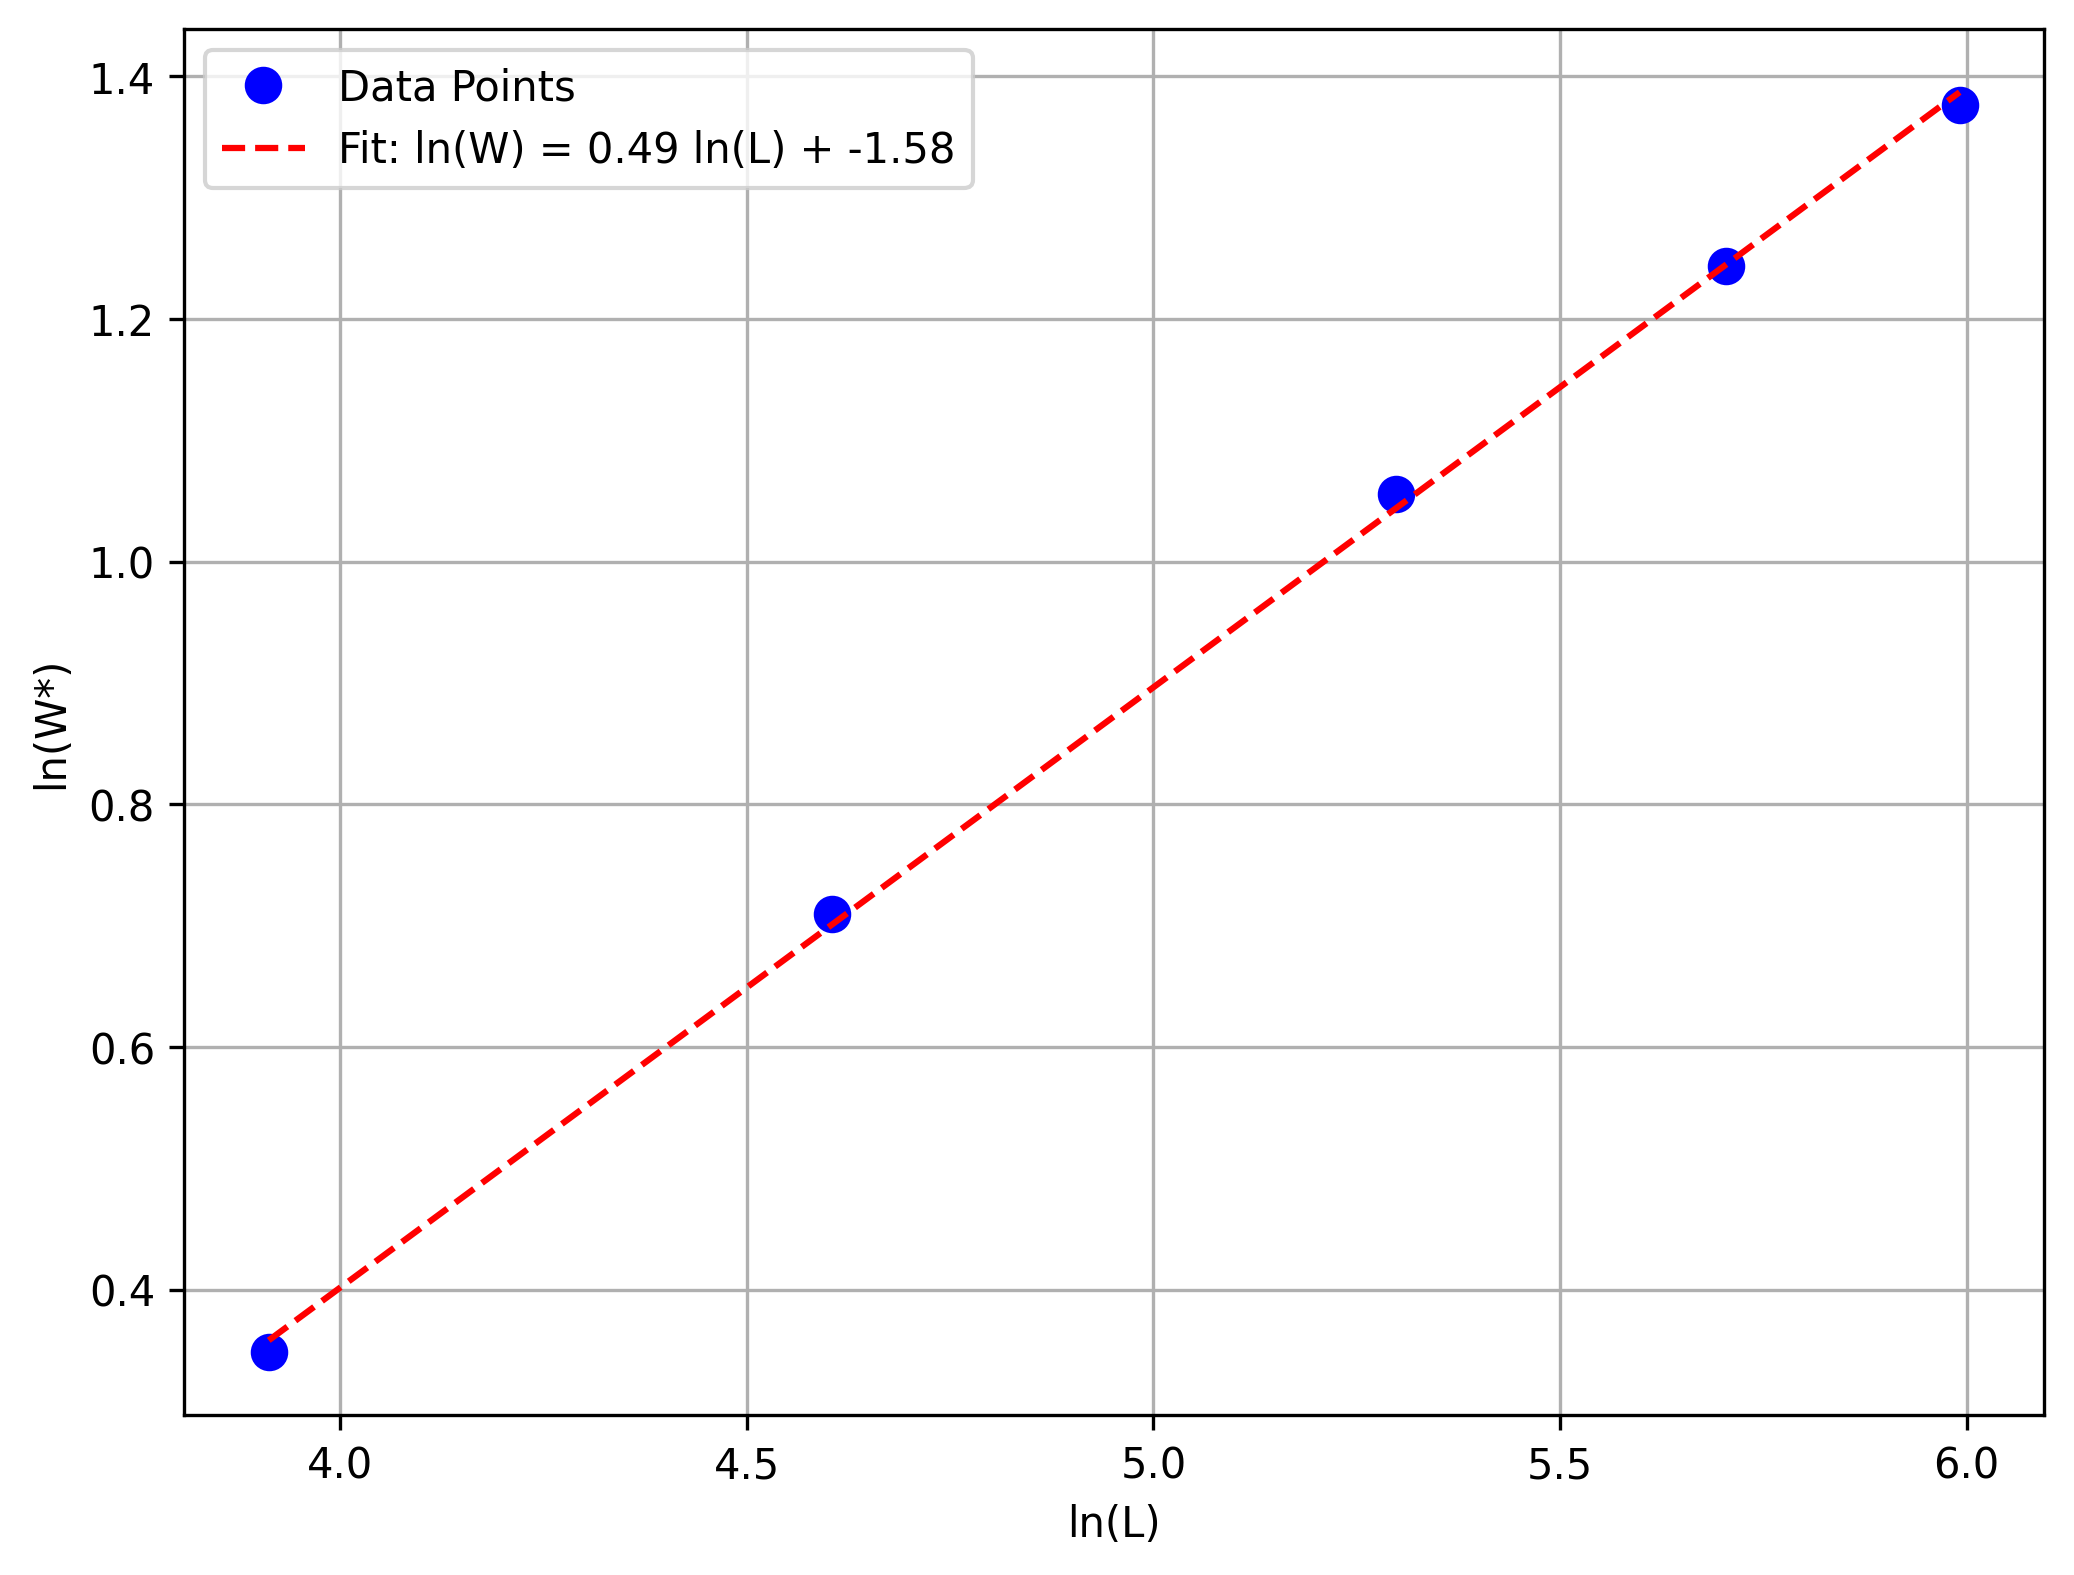

Estimated roughening exponent α = 0.4948


In [ ]:
ln_W = np.array([0.3484, 0.7099, 1.0559, 1.2441, 1.3766])
ln_L = np.log(np.array([50, 100, 200, 300, 400]))

slope, intercept, r_value, p_value, std_err = linregress(ln_L, ln_W)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(ln_L, ln_W, 'bo', markersize=8, label='Data Points')
plt.plot(ln_L, intercept + slope * ln_L, 'r--', 
         label=f'Fit: ln(W) = {slope:.2f} ln(L) + {intercept:.2f}')

plt.xlabel('ln(L)')
plt.ylabel('ln(W*)')
#plt.title('ln(W) vs ln(L)')
plt.legend()
plt.grid(True)

plt.savefig('RRD_ln_W_vs_ln_L.png', bbox_inches='tight')
plt.show()

print(f"Estimated roughening exponent α = {slope:.4f}")

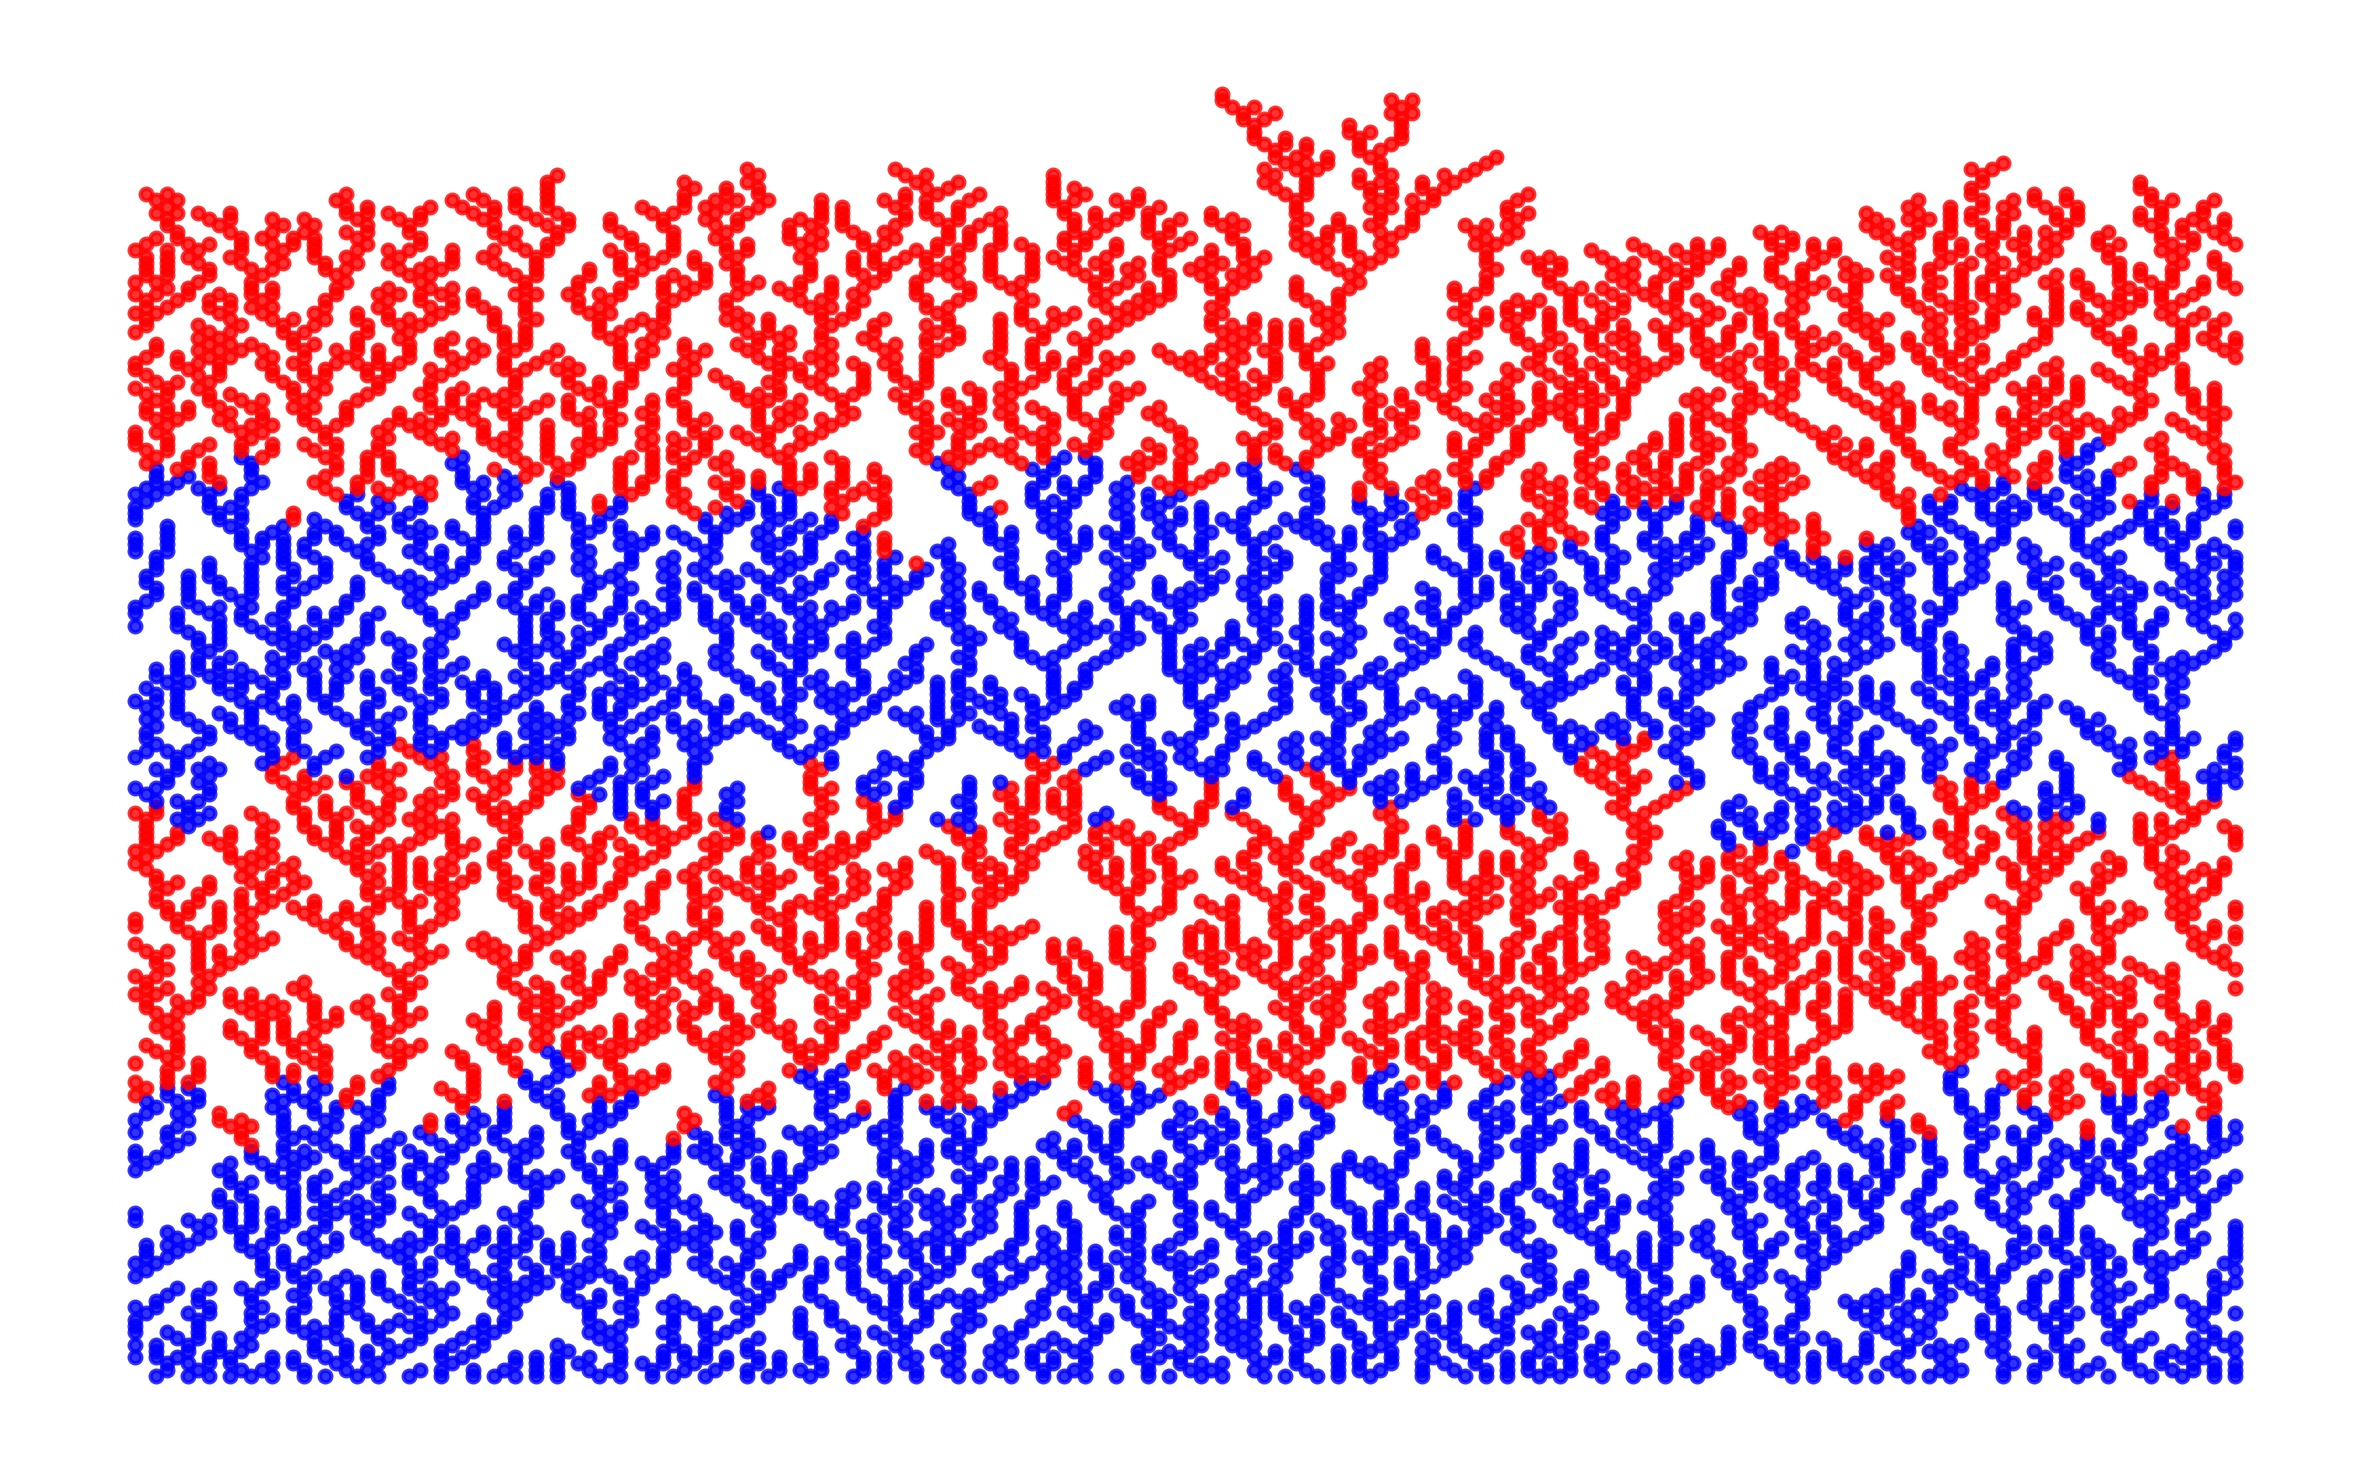

In [ ]:
L = 200
N = 10000
num_intervals = 4

h = np.zeros(L, dtype=int)

particles = []
interval_size = N // num_intervals

for t in range(N):
    i = np.random.randint(L)
    
    left  = h[(i - 1) % L]
    mid   = h[i]
    right = h[(i + 1) % L]
    
    new_height = max(left, mid, right) + 1
    h[i] = new_height
    
    particles.append((i, new_height, t // interval_size))

xvals, yvals, intervals = zip(*particles)

plt.figure(figsize=(8, 5), dpi=300)

for interval in range(num_intervals):
    mask = np.array(intervals) == interval
    color = 'blue' if interval % 2 == 0 else 'red'  # Alternating colors
    plt.scatter(np.array(xvals)[mask], np.array(yvals)[mask], 
                s=8, alpha=0.8, color=color, 
                label=f'Interval {interval + 1}')

plt.xticks([])
plt.yticks([])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.title('1D Ballistic Deposition')

plt.grid(False)

plt.tight_layout()
plt.savefig('ballistic_deposition.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [112]:
@njit
def ballistic_deposition_nb(L, num_particles):
    h = np.zeros(L, dtype=np.int64)
    sum_h = 0
    sum_h2 = 0
    roughness = np.zeros(num_particles, dtype=np.float64)
    
    for t in range(num_particles):
        i = np.random.randint(0, L)
        
        left  = h[(i - 1) % L]
        mid   = h[i]
        right = h[(i + 1) % L]
        
        old_h = h[i]
        new_h = max(left, mid, right) + 1
        h[i] = new_h
        
        delta = new_h - old_h
        sum_h += delta
        sum_h2 += (new_h * new_h) - (old_h * old_h)
        
        mean = sum_h / L
        var  = (sum_h2 / L) - (mean * mean)
        roughness[t] = np.sqrt(var)
    
    return roughness

def ballistic_deposition(L, num_particles):
    return ballistic_deposition_nb(L, num_particles)


def find_intersection(slope1, intercept1, slope2, intercept2):
    """Find intersection point of two lines"""
    x_intersect = (intercept2 - intercept1) / (slope1 - slope2)
    y_intersect = slope1 * x_intersect + intercept1
    return x_intersect, y_intersect


L_values = [50, 100, 200, 300, 400]
num_particles = 10000000
num_runs = 200
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))

simulation_results = {}
betas = {}

for L in L_values:
    print(f"Simulating L = {L}...")
    all_roughness = np.zeros((num_runs, num_particles))
    for run in range(num_runs):
        all_roughness[run] = ballistic_deposition(L, num_particles)
    simulation_results[L] = np.mean(all_roughness, axis=0)
    
    log_time = np.log(np.arange(1, num_particles + 1))
    log_roughness = np.log(simulation_results[L])
    if L == 50:
        fit_start, fit_end = 150, 650
    elif L == 100:
        fit_start, fit_end = 300, 1800
    elif L == 200:
        fit_start, fit_end = 500, 8000
    elif L == 300:
        fit_start, fit_end = 900, 15000
    elif L == 400:
        fit_start, fit_end = 1300, 22000

    slope, intercept, *_ = linregress(log_time[fit_start:fit_end], log_roughness[fit_start:fit_end])
    betas[L] = (slope, intercept)
    print(f"L = {L}: β = {slope:.3f}")

Simulating L = 50...
L = 50: β = 0.270
Simulating L = 100...
L = 100: β = 0.280
Simulating L = 200...
L = 200: β = 0.264
Simulating L = 300...
L = 300: β = 0.267
Simulating L = 400...
L = 400: β = 0.259


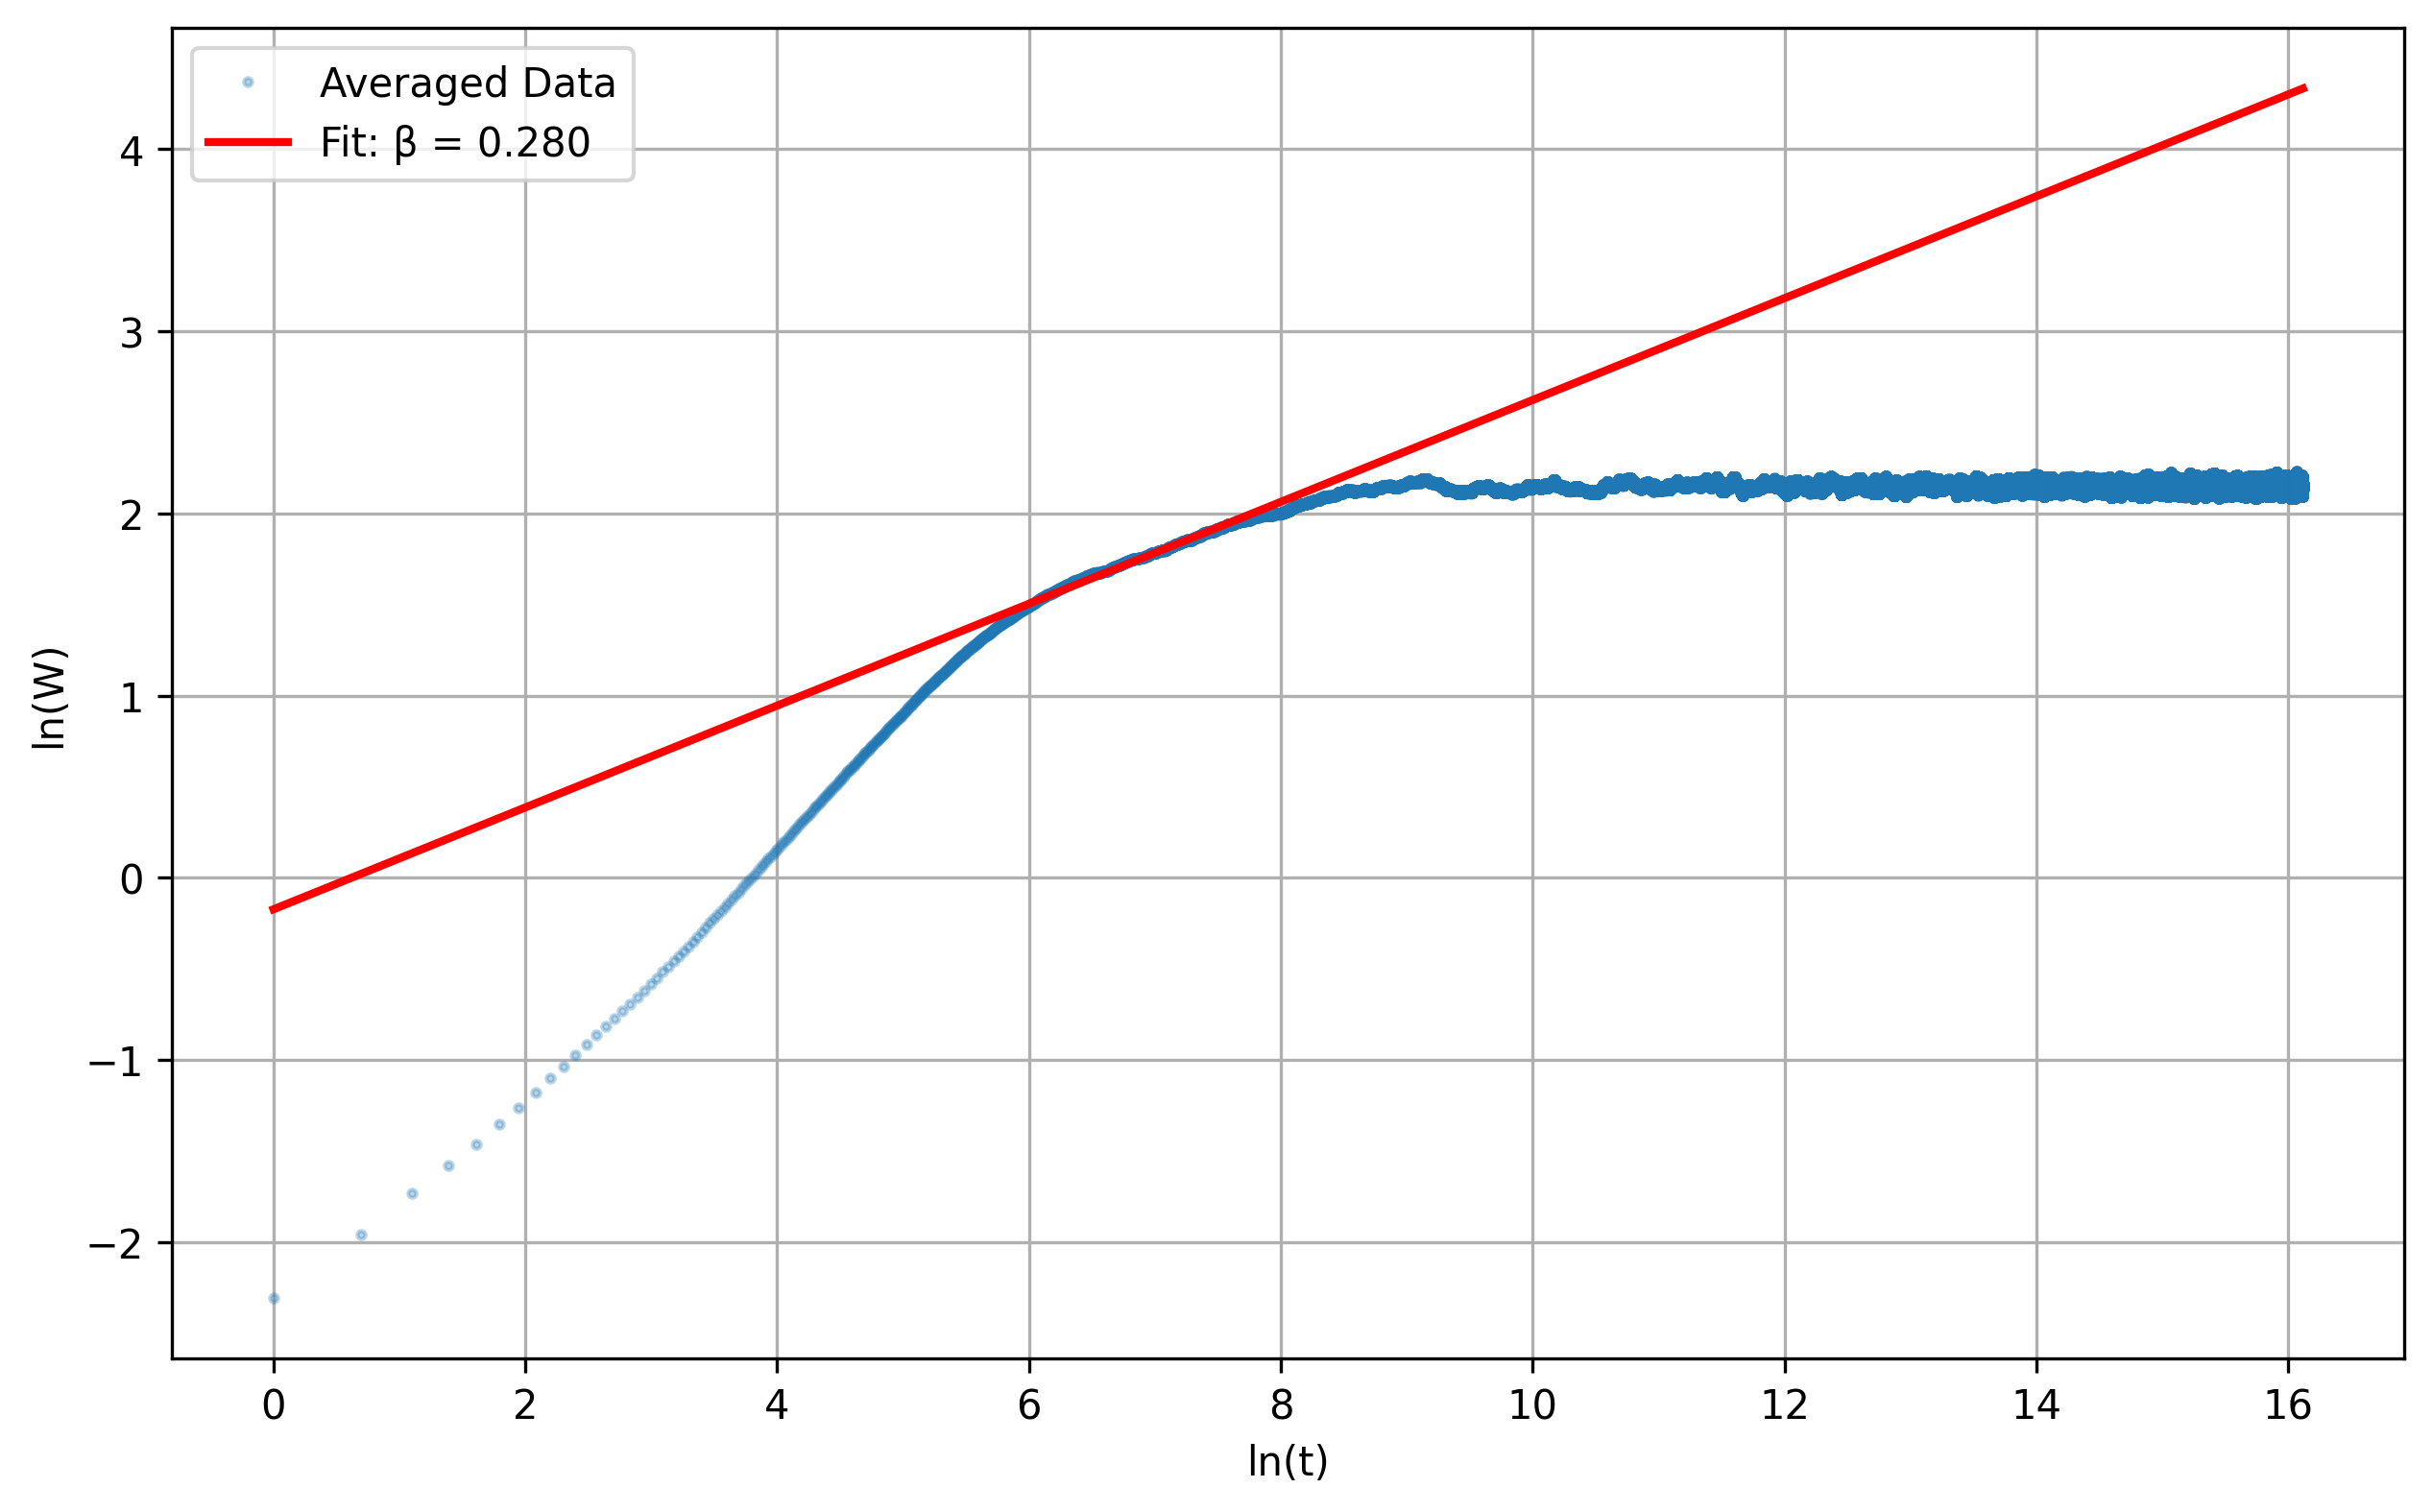

In [ ]:
# Plot for L = 100
L_special = 100

if L_special in simulation_results:
    log_time = np.log(np.arange(1, num_particles + 1))
    log_roughness = np.log(simulation_results[L_special])
    beta, intercept = betas[L_special]
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(log_time, log_roughness, 'o', markersize=2, alpha=0.3, label='Averaged Data')
    plt.plot(log_time, intercept + beta * log_time, 'r-', label=f'Fit: β = {beta:.3f}', linewidth=2)
    plt.xlabel('ln(t)')
    plt.ylabel('ln(W)')
    #plt.title(f'Ballistic Deposition (L = {L_special}, {num_runs} runs)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'BD_L{L_special}_{num_runs}_runs.png', bbox_inches='tight', pad_inches=0)
    plt.show()

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/779713173.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent overlap
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/779713173.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'BD_L_{num_runs}_runs.png', bbox_inches='tight', pad_inches=0)
/Users/kiara/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


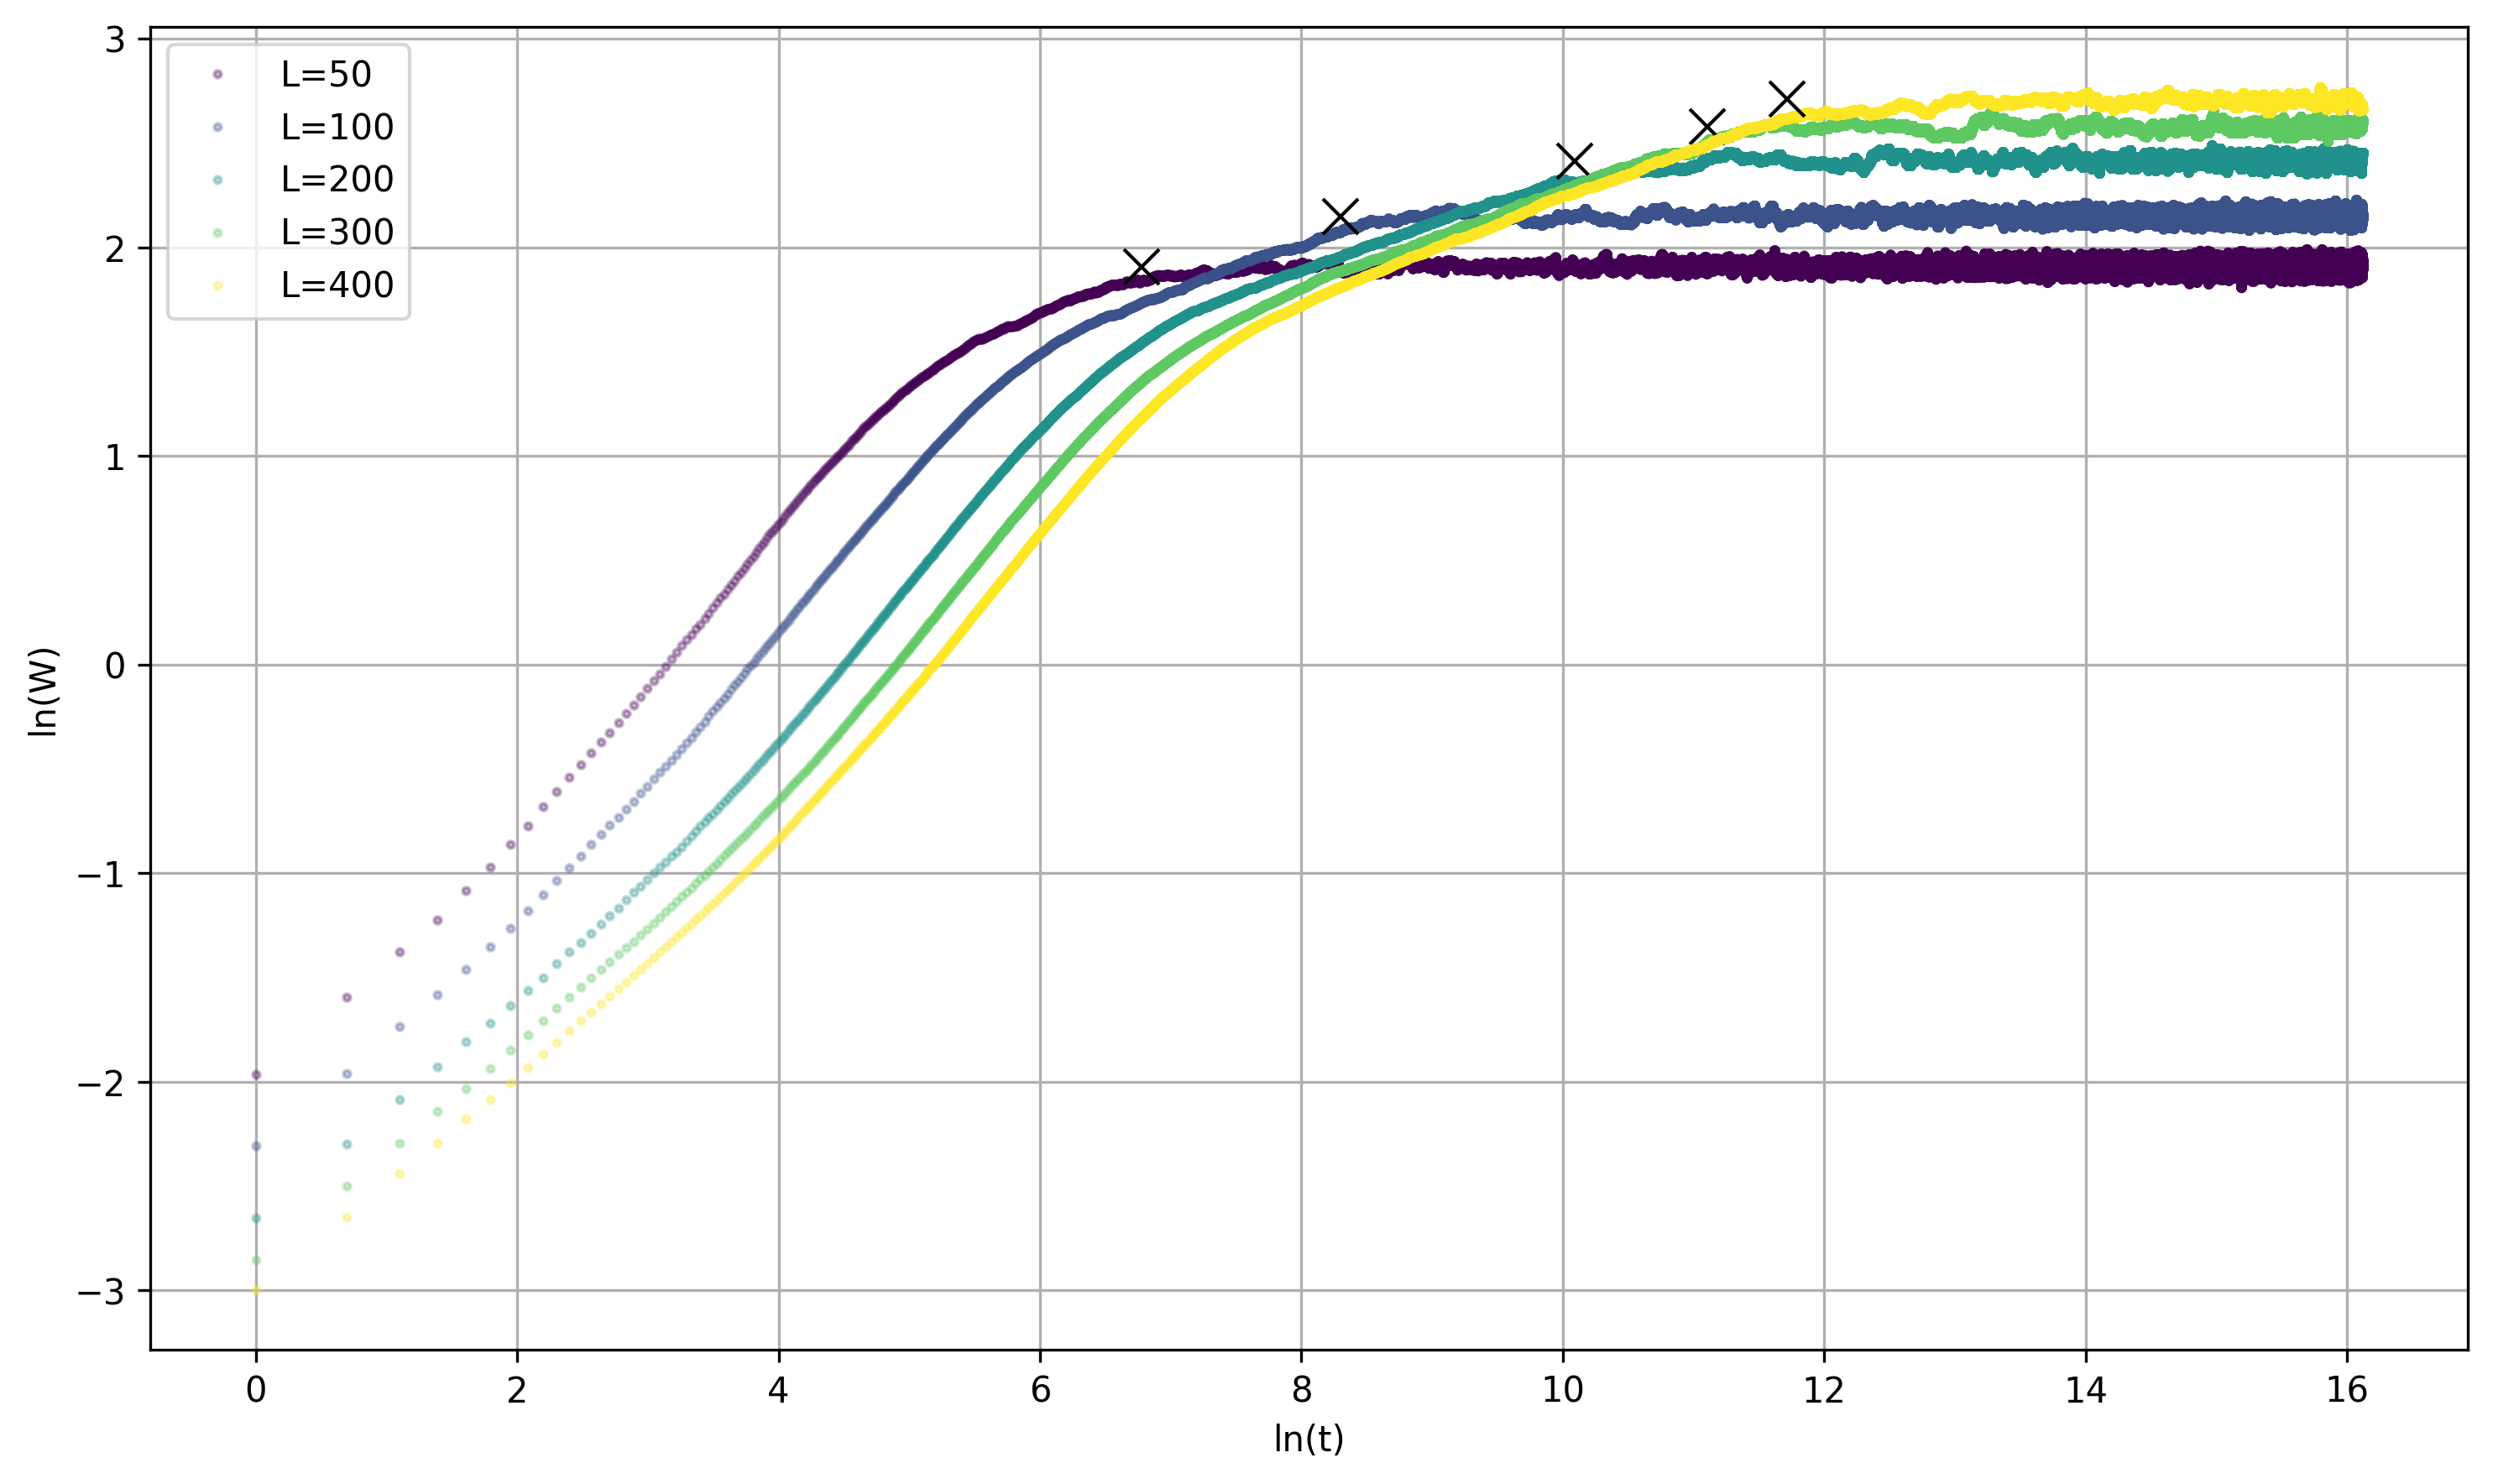

Intersection Points (ln(t), ln(W)):
L = 50: (6.7782, 1.9069)
L = 100: (8.2963, 2.1465)
L = 200: (10.0918, 2.4138)
L = 300: (11.1058, 2.5769)
L = 400: (11.7182, 2.7096)


In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
intersection_points = {}

for L, color in zip(L_values, colors):
    log_time = np.log(np.arange(1, num_particles + 1))
    log_roughness = np.log(simulation_results[L])
    beta, intercept = betas[L]
    
    mask2 = np.arange(1, num_particles + 1) >= 0.3 * num_particles
    slope2, intercept2, *_ = linregress(log_time[mask2], log_roughness[mask2])
    
    x_intersect, y_intersect = find_intersection(beta, intercept, slope2, intercept2)
    intersection_points[L] = (x_intersect, y_intersect)
    
    plt.plot(log_time, log_roughness, 'o', markersize=2, alpha=0.3, 
             color=color, label=f'L={L}')
    plt.plot(x_intersect, y_intersect, 'kx', markersize=10)

plt.xlabel('ln(t)')
plt.ylabel('ln(W)')
#plt.title(f'Ballistic Deposition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'BD_L_{num_runs}_runs.png', bbox_inches='tight', pad_inches=0)
plt.show()

print("Intersection Points (ln(t), ln(W)):")
for L, (x, y) in intersection_points.items():
    print(f"L = {L}: ({x:.4f}, {y:.4f})")

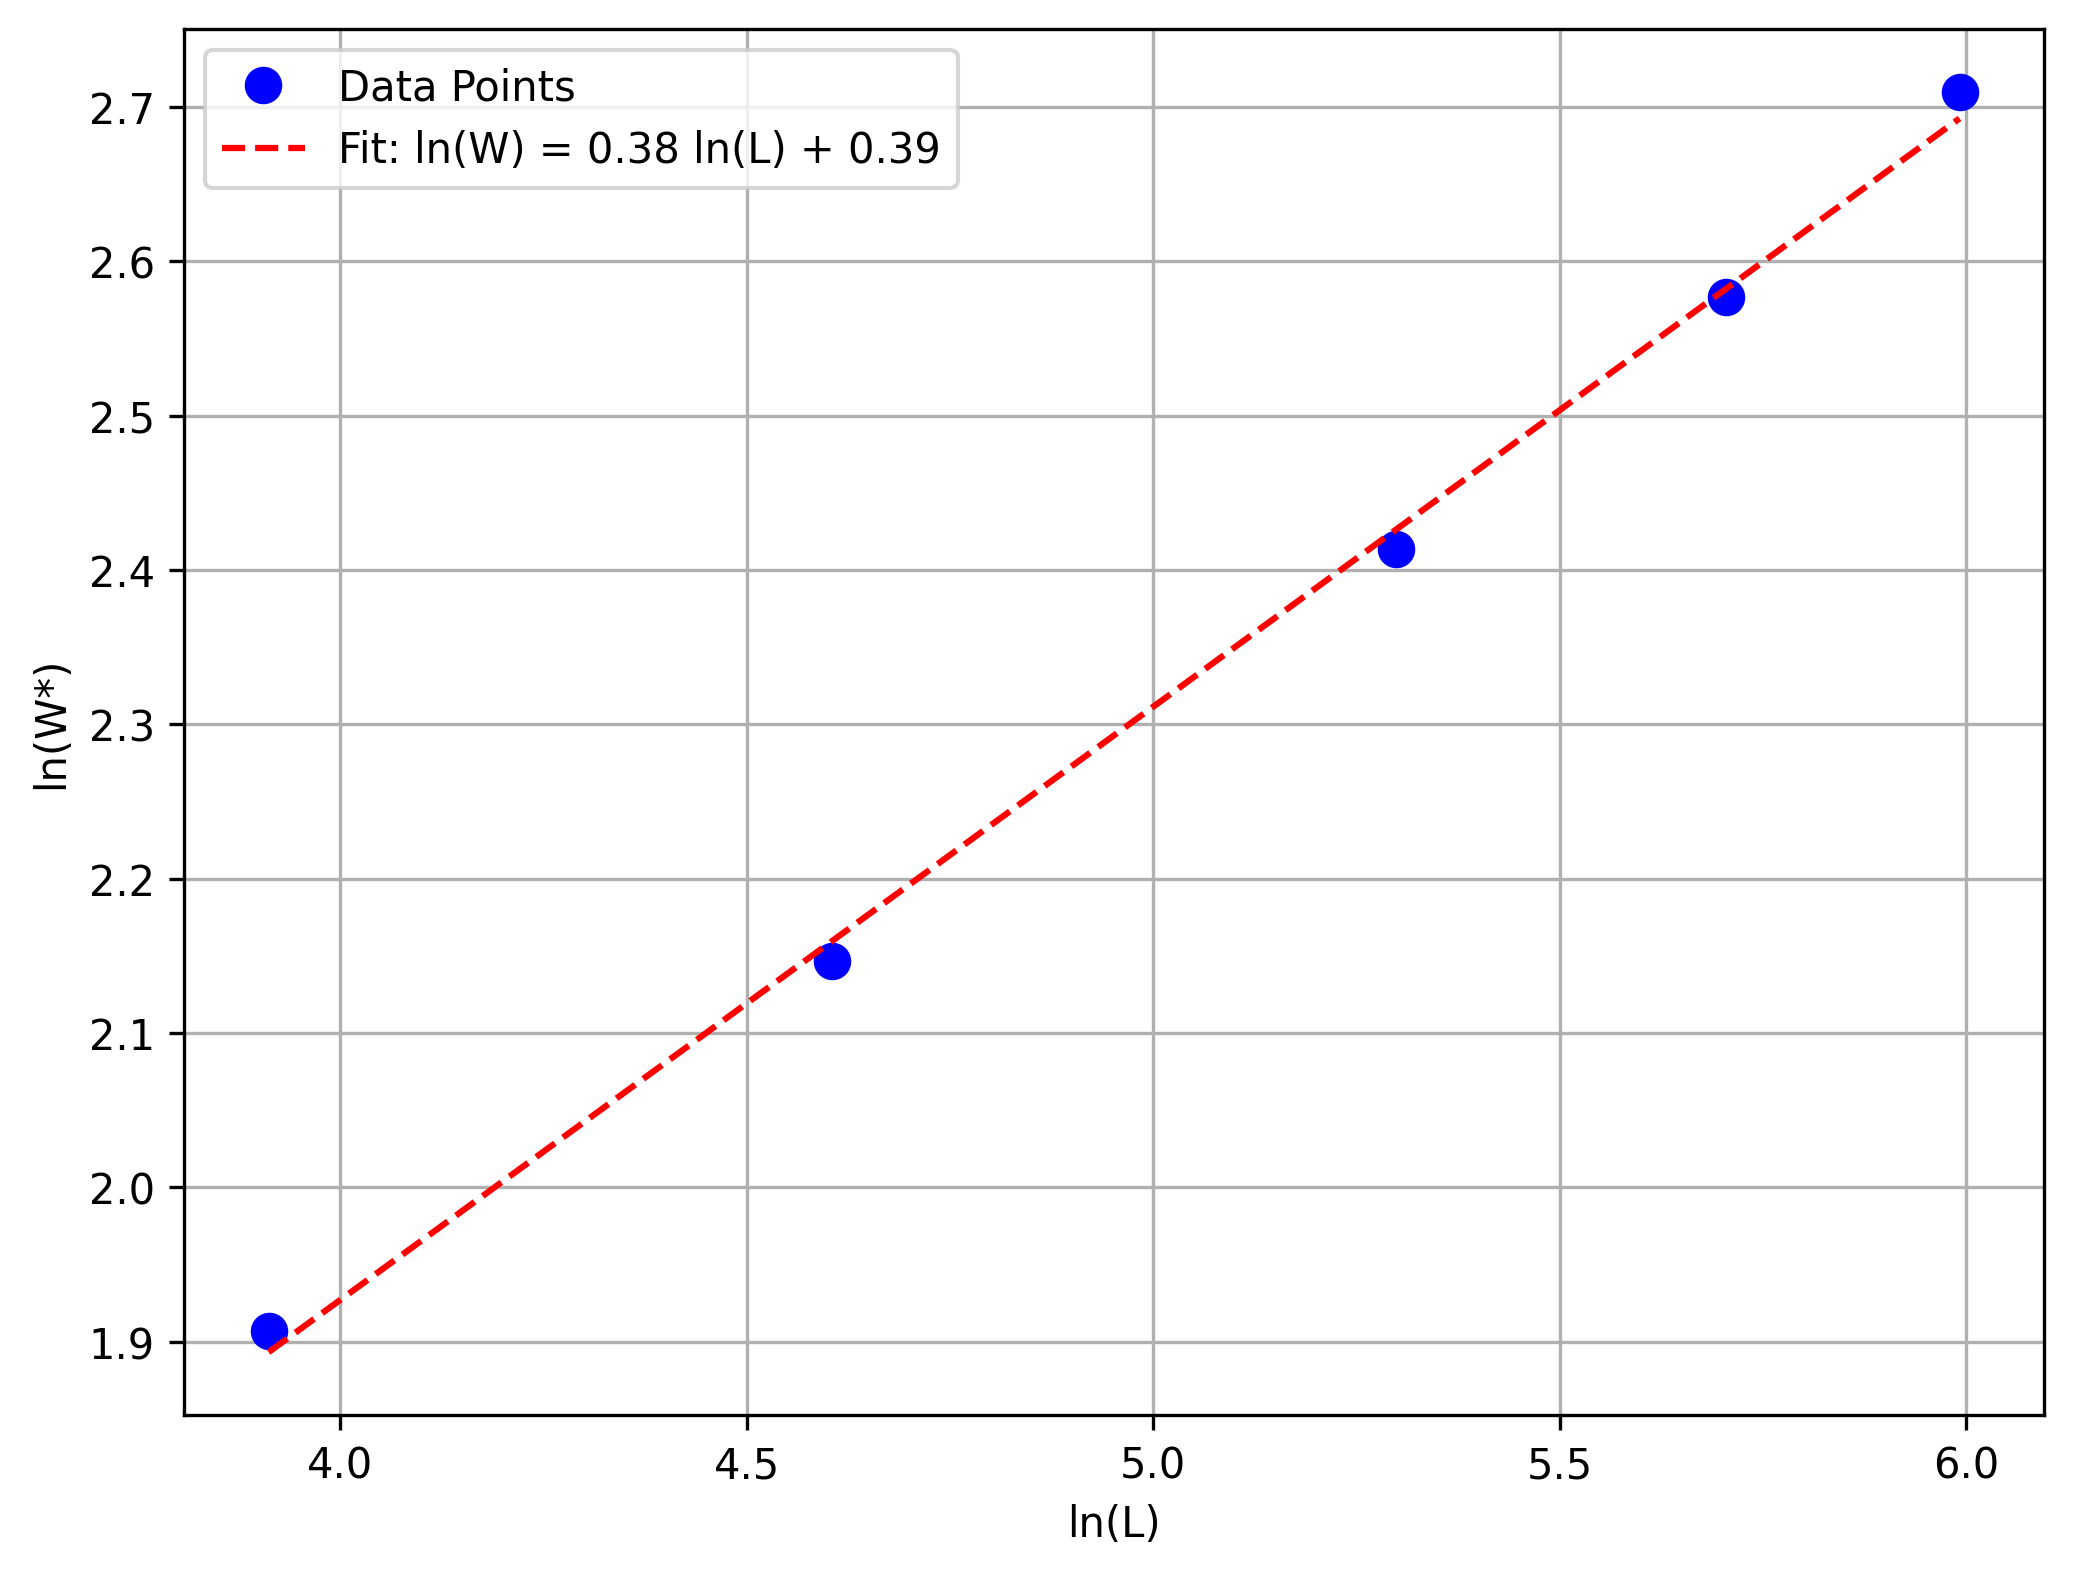

Estimated roughening exponent α = 0.3844


In [ ]:
ln_W = np.array([1.9069, 2.1465, 2.4138, 2.5769, 2.7096])
ln_L = np.log(np.array([50, 100, 200, 300, 400]))

slope, intercept, r_value, p_value, std_err = linregress(ln_L, ln_W)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(ln_L, ln_W, 'bo', markersize=8, label='Data Points')
plt.plot(ln_L, intercept + slope * ln_L, 'r--', 
         label=f'Fit: ln(W) = {slope:.2f} ln(L) + {intercept:.2f}')

plt.xlabel('ln(L)')
plt.ylabel('ln(W*)')
#plt.title('ln(W) vs ln(L)')
plt.legend()
plt.grid(True)

plt.savefig('BD_ln_W_vs_ln_L.png', bbox_inches='tight')
plt.show()

print(f"Estimated roughening exponent α = {slope:.4f}")

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/4051541106.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('BD_Run200_scaled.png', bbox_inches='tight')
/Users/kiara/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


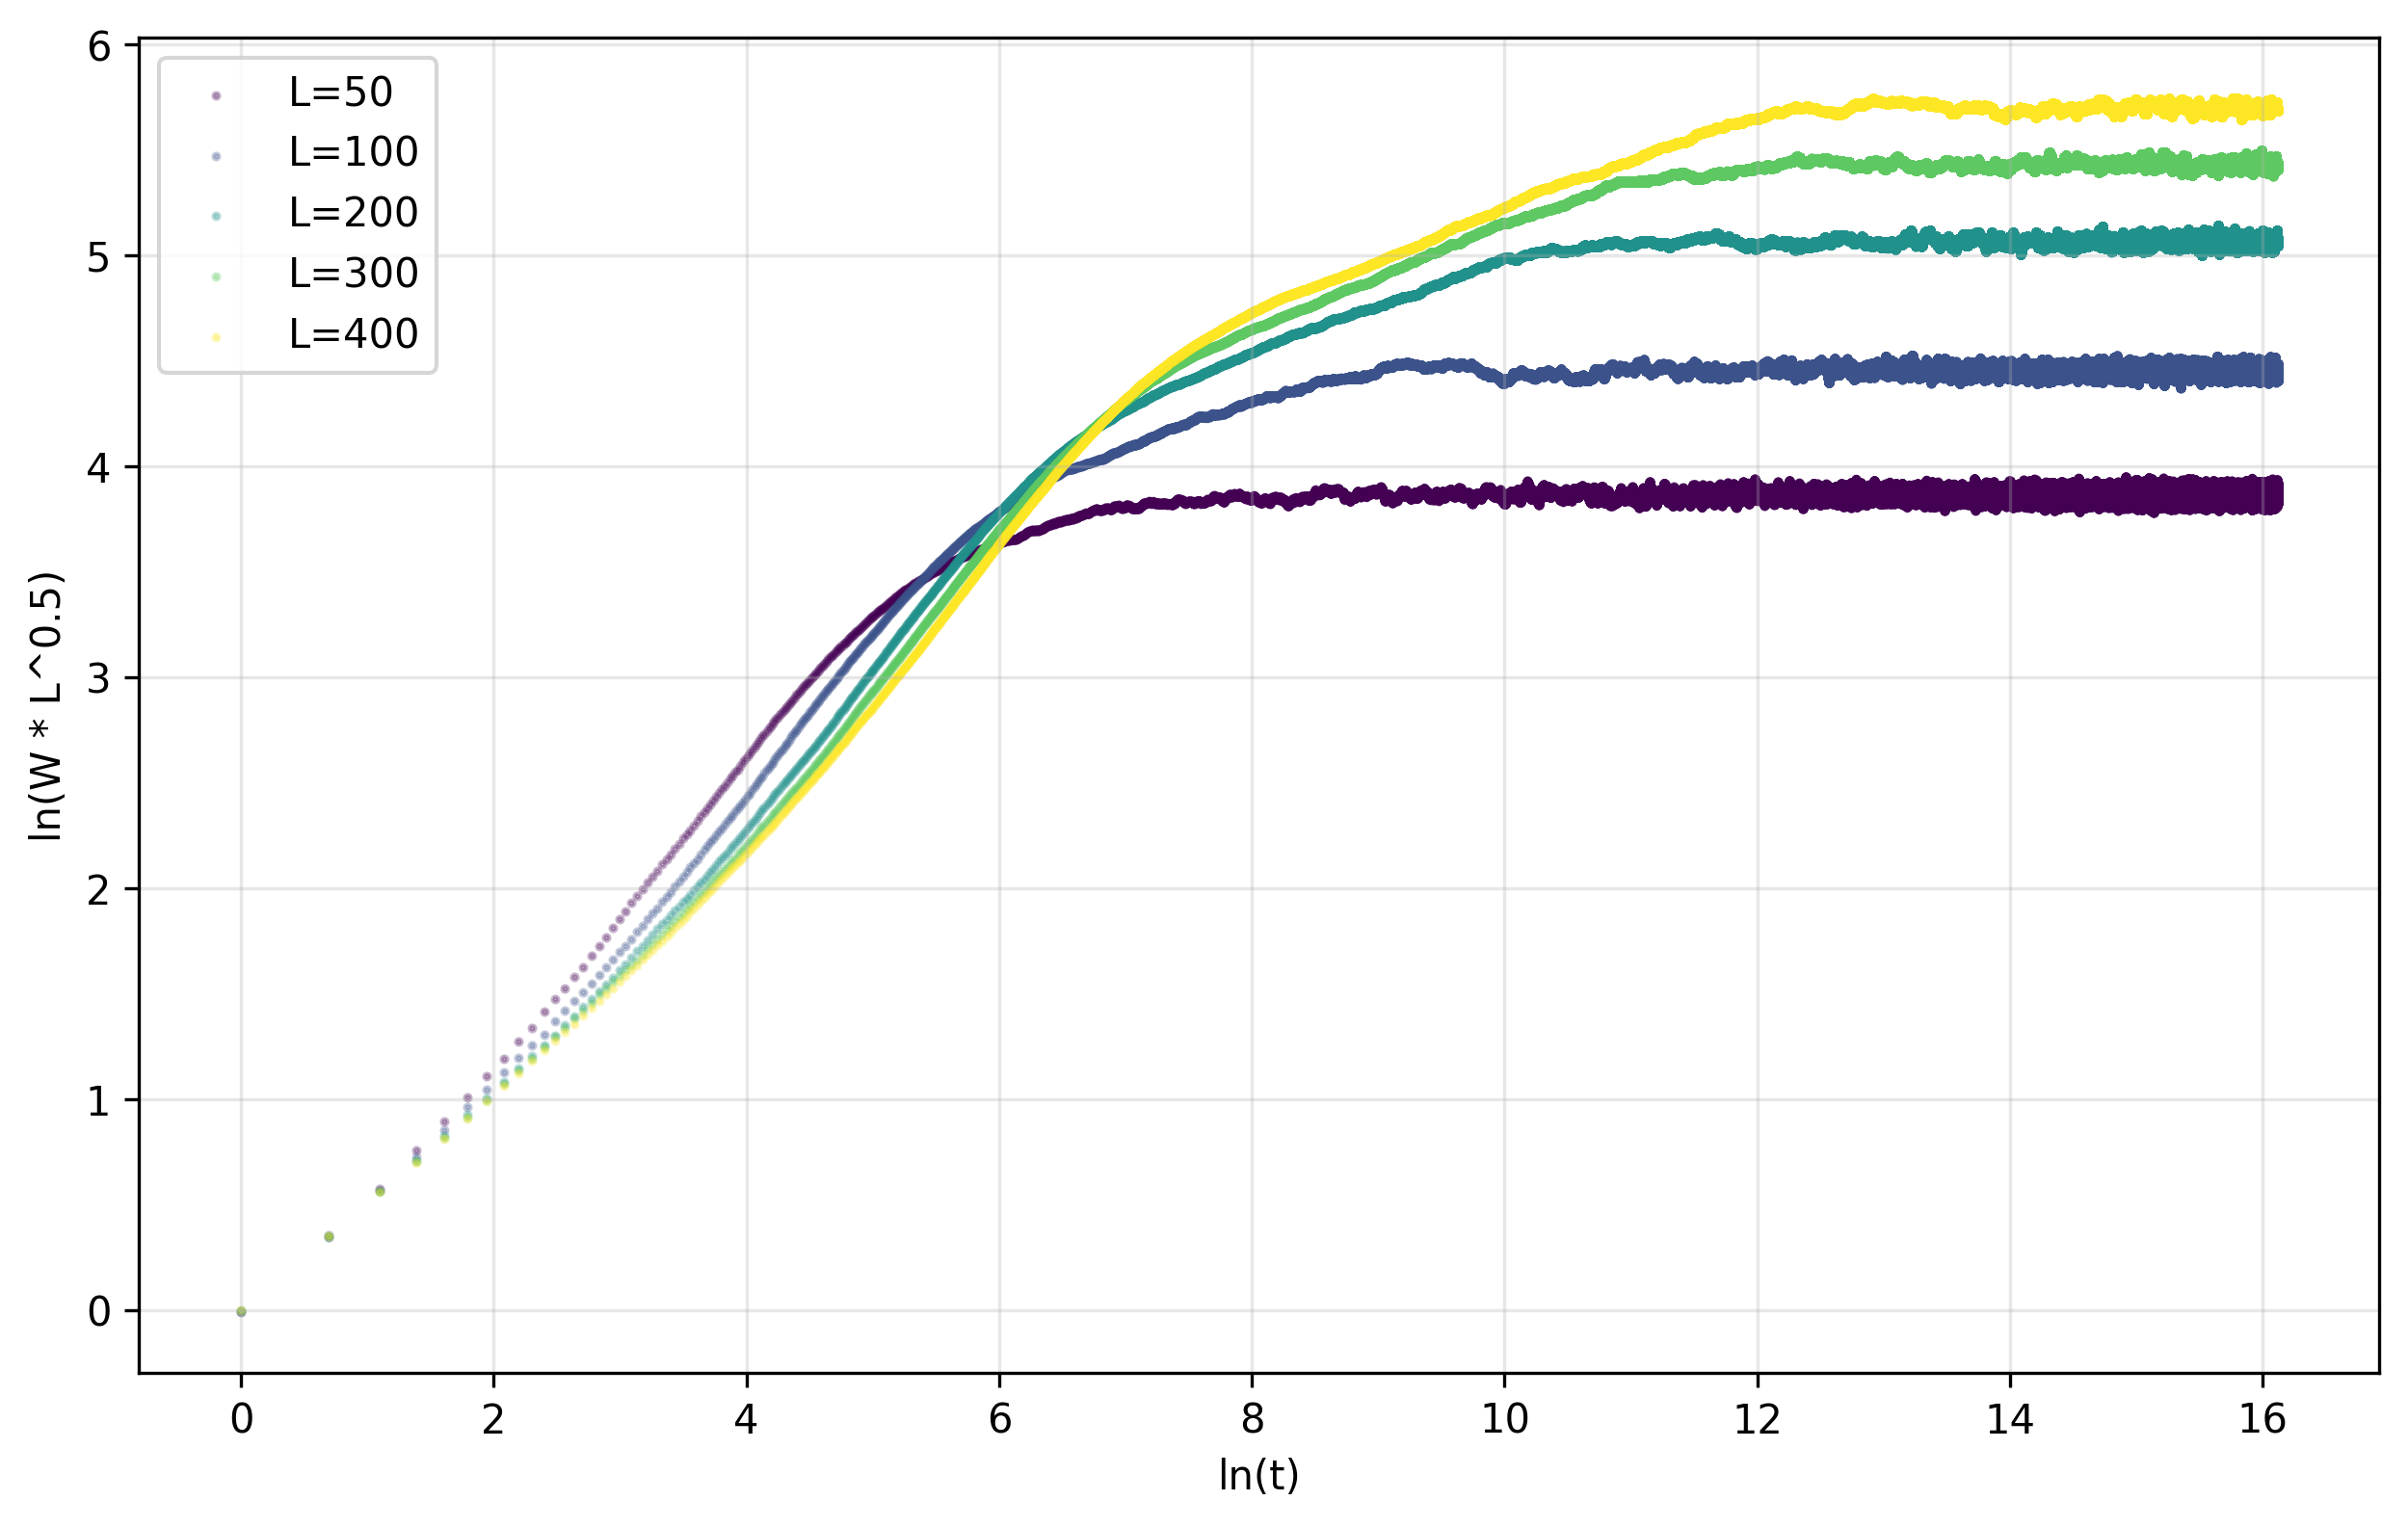

In [119]:
plt.figure(figsize=(10, 6), dpi=300)
for L, color in zip(L_values, colors):
    log_time = np.log(np.arange(1, num_particles + 1))
    log_roughness = np.log(simulation_results[L])
    beta, intercept = betas[L]
    plt.scatter(log_time, log_roughness + 0.5 * np.log(L), s=2, alpha=0.3, color=color, label=f'L={L}')

plt.xlabel('ln(t)')
plt.ylabel('ln(W * L^0.5)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('BD_Run200_scaled.png', bbox_inches='tight')
plt.show()

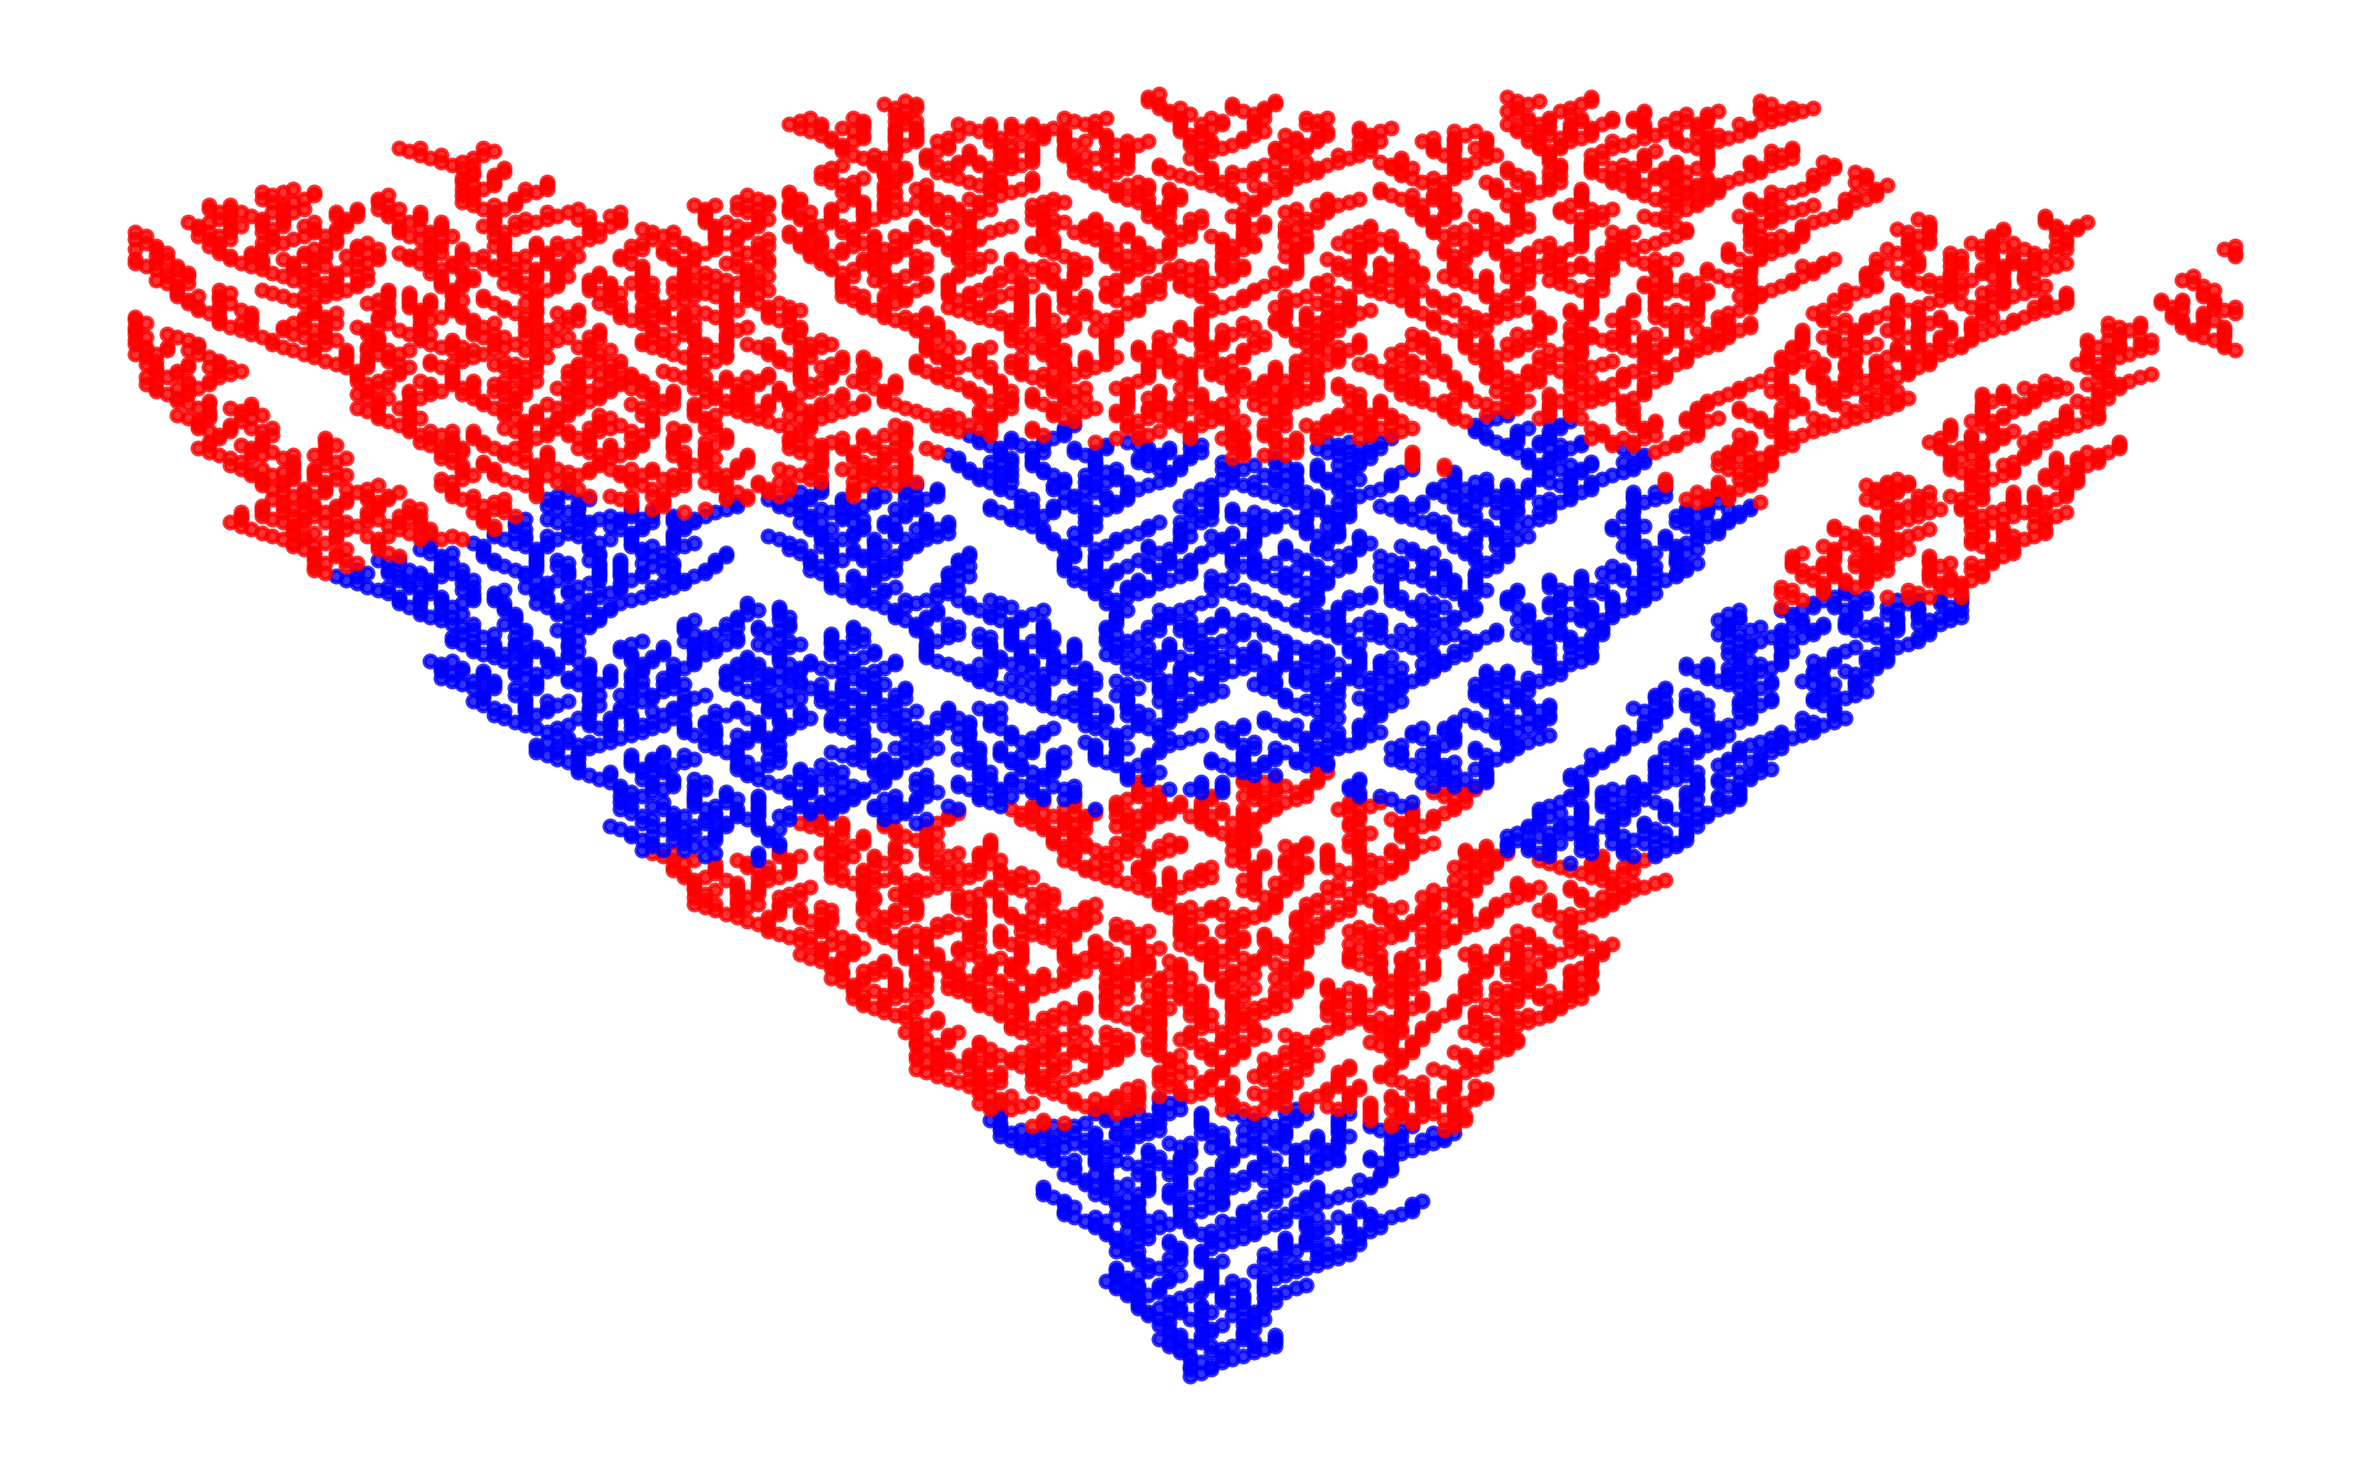

In [ ]:
L = 200
N = 20000
num_intervals = 4

h = np.full(L, -100000, dtype=int)
h[L // 2] = 0

particles = []
interval_size = N // num_intervals

for t in range(N):
    i = np.random.randint(L)
    
    left  = h[(i - 1) % L]
    mid   = h[i]
    right = h[(i + 1) % L]
    
    new_height = max(left, mid, right) + 1
    h[i] = new_height
    
    particles.append((i, new_height, t // interval_size))

xvals, yvals, intervals = zip(*particles)

valid_mask = np.array(yvals) > 0
xvals_filtered = np.array(xvals)[valid_mask]
yvals_filtered = np.array(yvals)[valid_mask]
intervals_filtered = np.array(intervals)[valid_mask]

plt.figure(figsize=(8, 5), dpi=300)

for interval in range(num_intervals):
    mask = intervals_filtered == interval
    color = 'blue' if interval % 2 == 0 else 'red'
    plt.scatter(xvals_filtered[mask], yvals_filtered[mask], 
                s=8, alpha=0.8, color=color, 
                label=f'Interval {interval + 1}')

plt.xticks([])
plt.yticks([])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.title('1D Ballistic Deposition-correlation length')

plt.grid(False)

plt.tight_layout()
plt.savefig('ballistic_deposition_correlationlength.png', bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_66415/1605594439.py:58: RuntimeWarning: divide by zero encountered in log
  ln_width = np.log(width_positions)


Slope of the fitted line: 0.9980


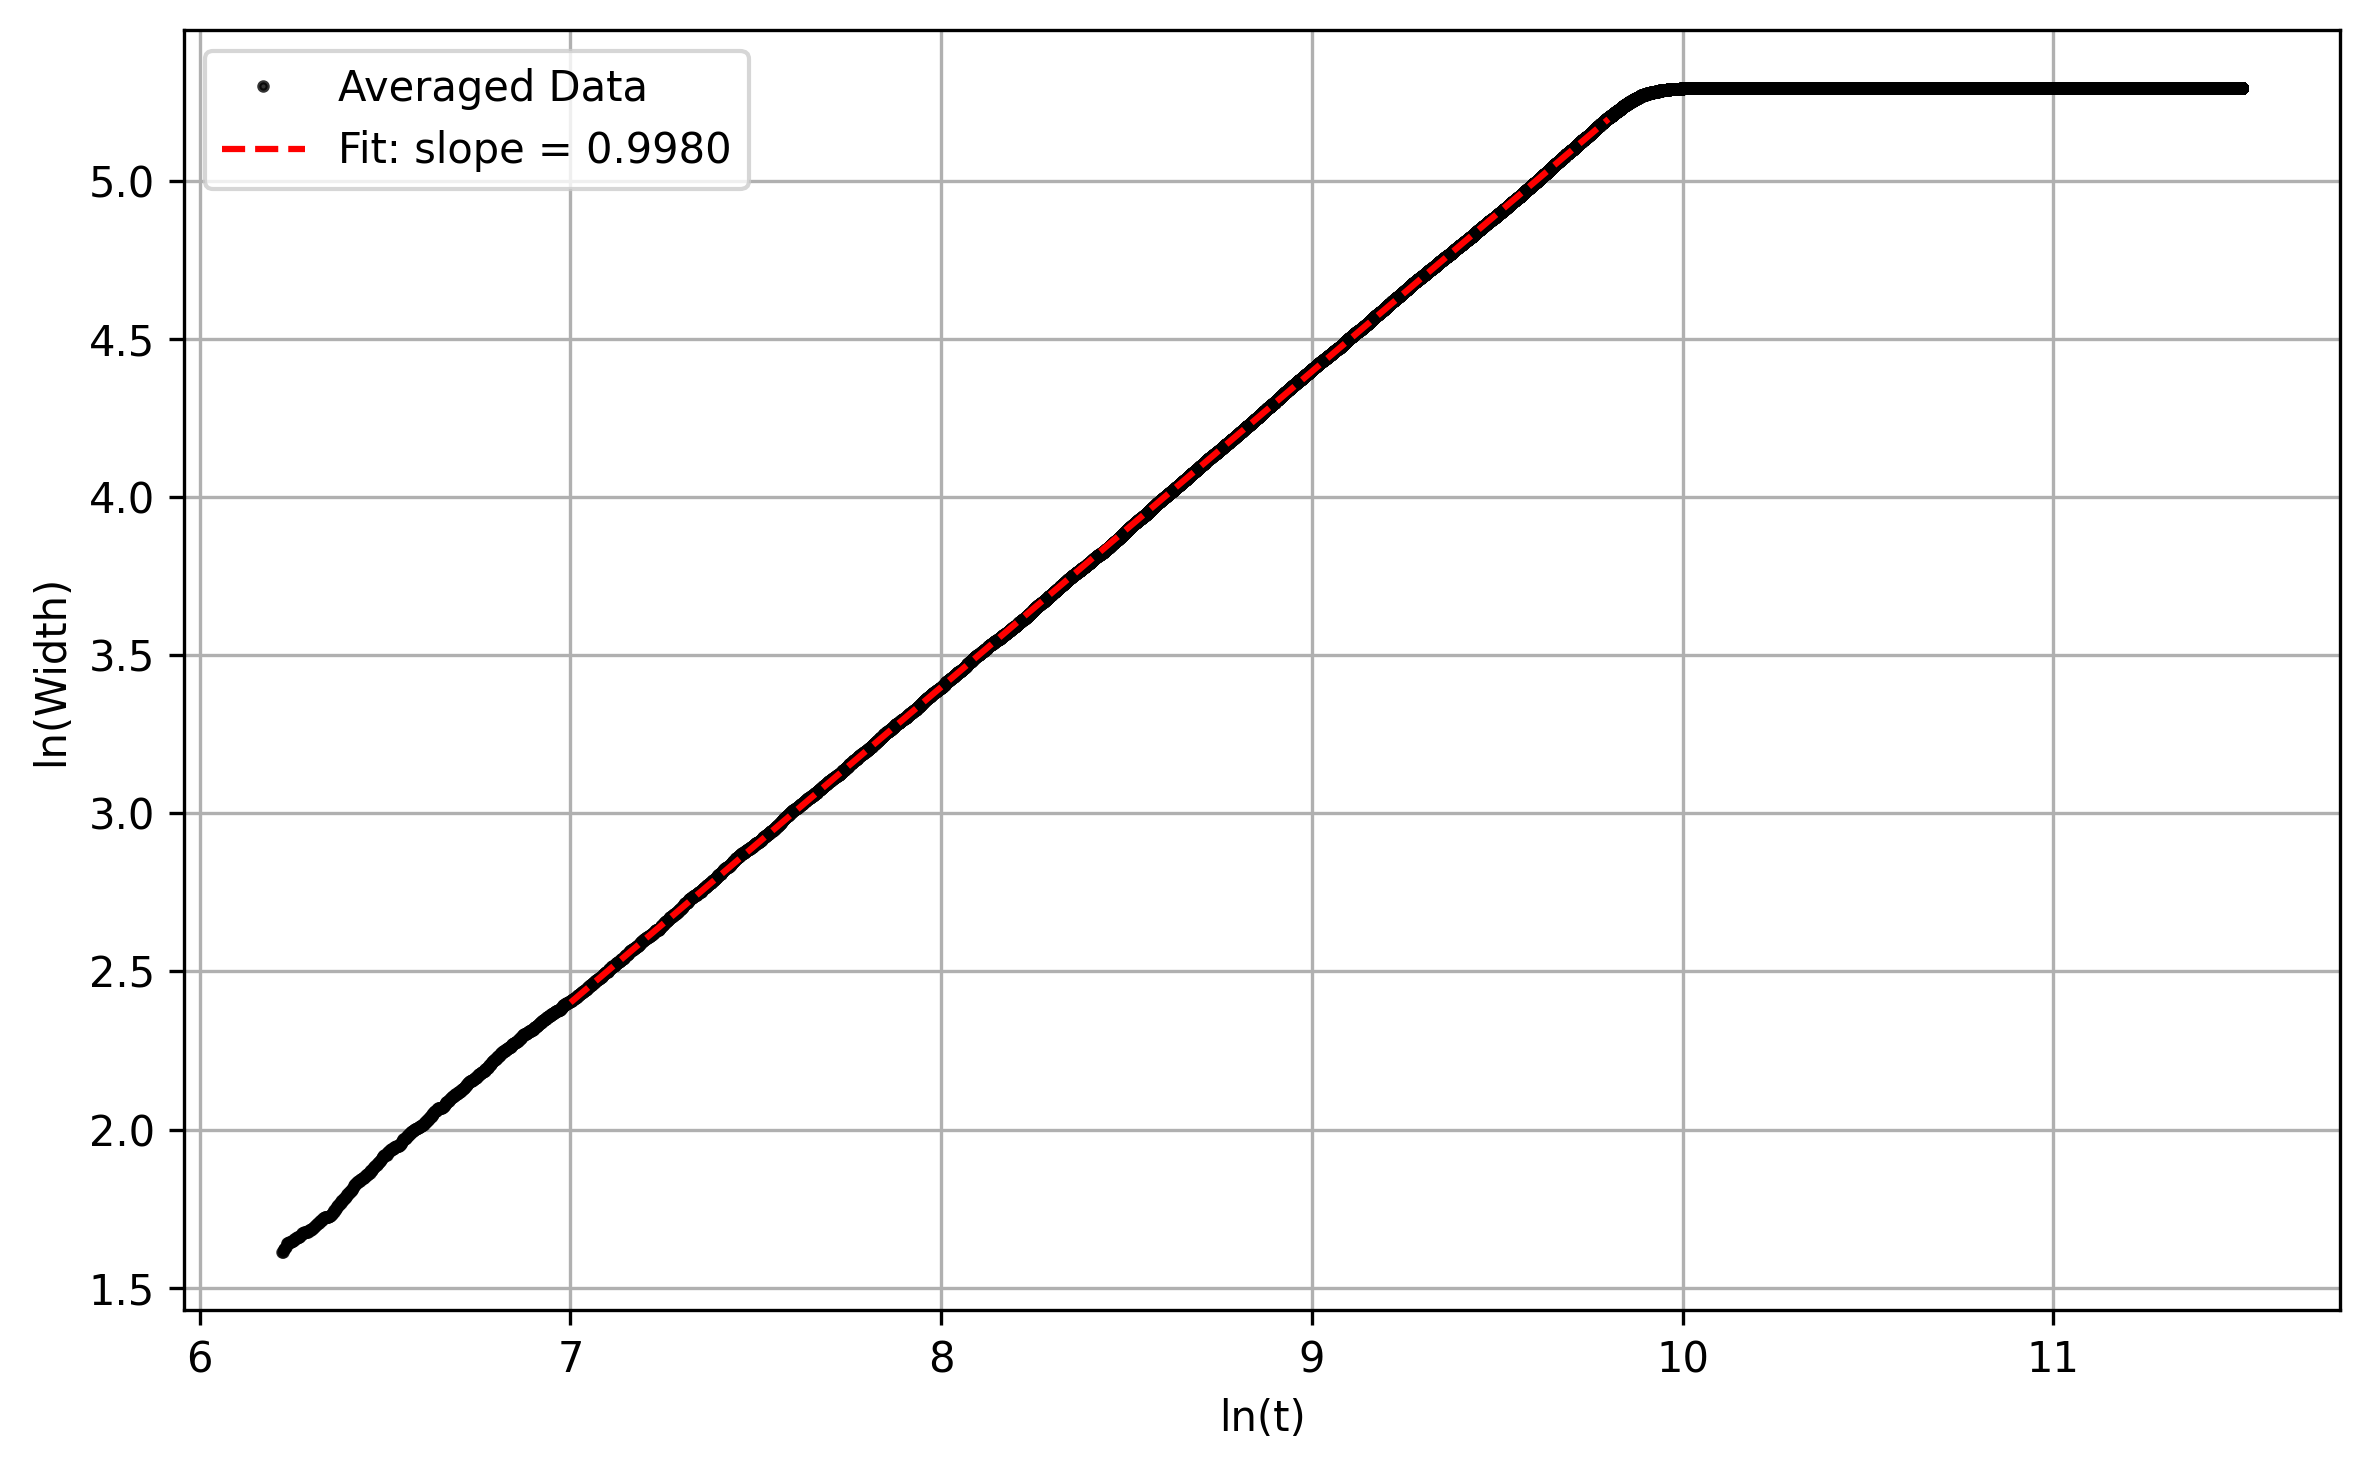

In [ ]:
L = 200
N = 100000
num_simulations = 200

@njit
def run_simulation(L, N):
    h = np.full(L, -100000, dtype=np.int32)
    h[L // 2] = 0

    width_positions = np.zeros(N, dtype=np.int32)

    for t in range(N):
        i = np.random.randint(L)

        left = h[(i - 1) % L]
        mid = h[i]
        right = h[(i + 1) % L]

        new_height = max(left, mid, right) + 1
        h[i] = new_height

        non_zero_indices = np.where(h > 0)[0]

        if non_zero_indices.size > 0:
            leftmost = np.min(non_zero_indices)
            rightmost = np.max(non_zero_indices)
            width_positions[t] = rightmost - leftmost
        else:
            width_positions[t] = -1

    valid_mask = width_positions != -1
    valid_width_positions = width_positions[valid_mask]
    valid_time_values = np.arange(1, len(valid_width_positions) + 1)

    return valid_time_values, valid_width_positions

all_ln_time = []
all_ln_width = []

for _ in range(num_simulations):
    time_values, width_positions = run_simulation(L, N)
    ln_time = np.log(time_values)
    ln_width = np.log(width_positions)
    all_ln_time.append(ln_time)
    all_ln_width.append(ln_width)

min_length = min(len(ln_time) for ln_time in all_ln_time)

all_ln_time = [ln_time[:min_length] for ln_time in all_ln_time]
all_ln_width = [ln_width[:min_length] for ln_width in all_ln_width]

all_ln_time = np.array(all_ln_time)
all_ln_width = np.array(all_ln_width)

avg_ln_time = np.mean(all_ln_time, axis=0)
avg_ln_width = np.mean(all_ln_width, axis=0)

fit_range = (7, 9.8)
fit_mask = (avg_ln_time >= fit_range[0]) & (avg_ln_time <= fit_range[1])

slope, intercept = np.polyfit(avg_ln_time[fit_mask], avg_ln_width[fit_mask], 1)
print(f"Slope of the fitted line: {slope:.4f}")

fitted_line = slope * avg_ln_time[fit_mask] + intercept

plt.figure(figsize=(8, 5), dpi=300)

plt.plot(avg_ln_time, avg_ln_width, 'o', markersize=2, alpha=0.8, color='black', label='Averaged Data')

plt.plot(avg_ln_time[fit_mask], fitted_line, linestyle='--', color='red', label=f'Fit: slope = {slope:.4f}')

plt.xlabel('ln(t)')
plt.ylabel('ln(Width)')
#plt.title(f'ln(Width) vs ln(Time) (Averaged over {num_simulations} Simulations)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('BD_width_vs_time_averaged.png', bbox_inches='tight')
plt.show()

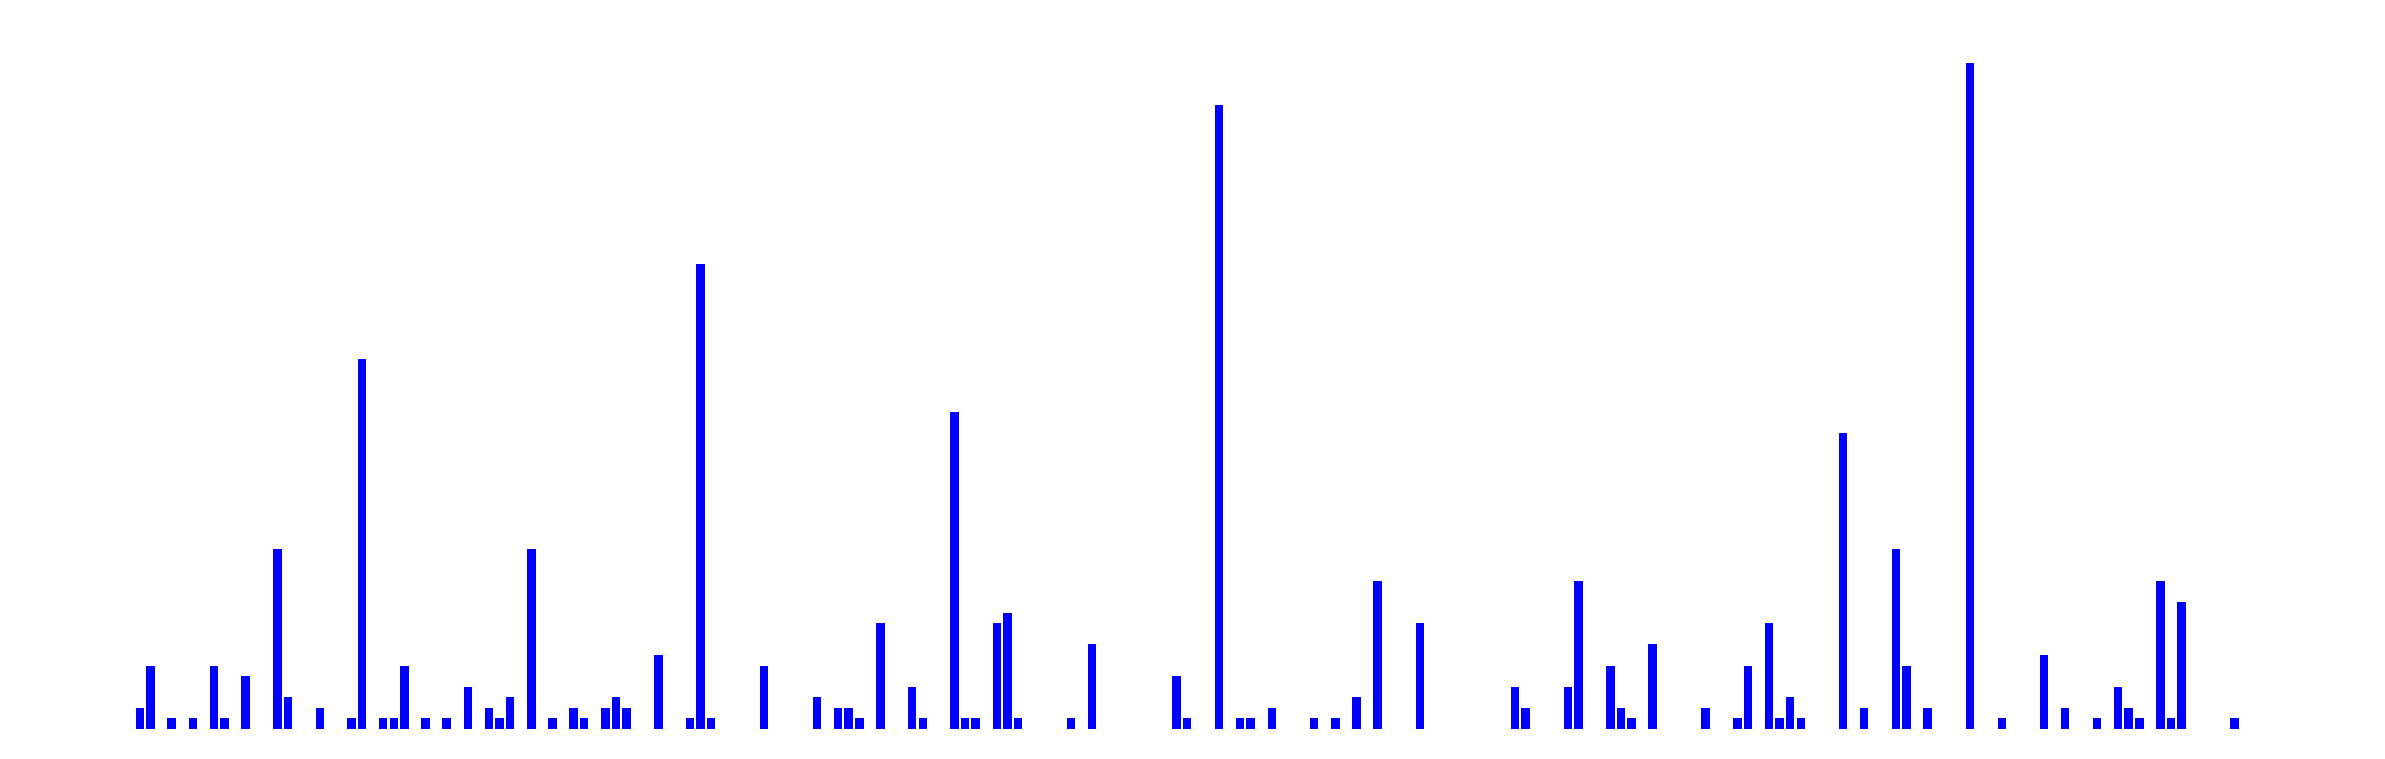

In [ ]:
@njit
def competitive_random_deposition_njit(num_particles, width, tan_phi):
    heights = np.zeros(width, dtype=np.int32)
    trajectories = []
    hit_points = []

    for _ in range(num_particles):
        start_height = np.max(heights) + 10
        x = np.random.randint(0, width)
        y = start_height
        trajectory = [(x, y)]

        while True:
            x_new = x + tan_phi
            y_new = y - 1

            if x_new >= width or x_new < 0:
                x_new = x_new % width

            x_new_int = int(np.floor(x_new))
            if x_new_int >= width:
                x_new_int = x_new_int % width

            if y_new <= heights[x_new_int]:
                heights[x_new_int] += 1
                hit_point = (x_new_int, heights[x_new_int])
                trajectory.append(hit_point)
                hit_points.append(hit_point)
                break
            else:
                x, y = x_new, y_new
                trajectory.append((x, y))

        trajectories.append(trajectory)

    return heights, trajectories, hit_points

def competitive_random_deposition(num_particles, width, phi_degrees):
    phi = np.radians(phi_degrees)
    tan_phi = np.tan(phi)
    return competitive_random_deposition_njit(num_particles, width, tan_phi)

def plot_final_state(heights, width):
    plt.figure(figsize=(10, 6), dpi=300)
    plt.bar(range(width), heights, color='blue')
    plt.xlabel('Position')
    plt.ylabel('Height')
    #plt.title(f'Final Surface Height (Max Height: {np.max(heights)})')
    plt.grid(False)
    plt.axis("off")
    plt.gca().set_aspect('equal')
    plt.savefig('CRD_500particle_45deg.png', bbox_inches='tight')
    plt.show()

def plot_deposition_gif(trajectories, hit_points, width, filename="deposition_simulation.gif"):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    ax.set_xlim(0, width)
    ax.set_ylim(0, max([max(y for _, y in traj) for traj in trajectories]) + 1)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Height')
    ax.set_title('Competitive Random Deposition Simulation')
    ax.grid(True)
    ax.set_aspect('equal')

    ani = animation.FuncAnimation(
        fig, update, frames=len(trajectories),
        fargs=(trajectories, hit_points, ax), interval=200, blit=False
    )

    ani.save(filename, writer="pillow")
    print(f"GIF saved as {filename}")

num_particles = 600
width = 200
phi_degrees = 45

heights, trajectories, hit_points = competitive_random_deposition(num_particles, width, phi_degrees)

plot_final_state(heights, width)

#plot_deposition_gif(trajectories, hit_points, width, filename="CRD_deposition_simulation.gif")

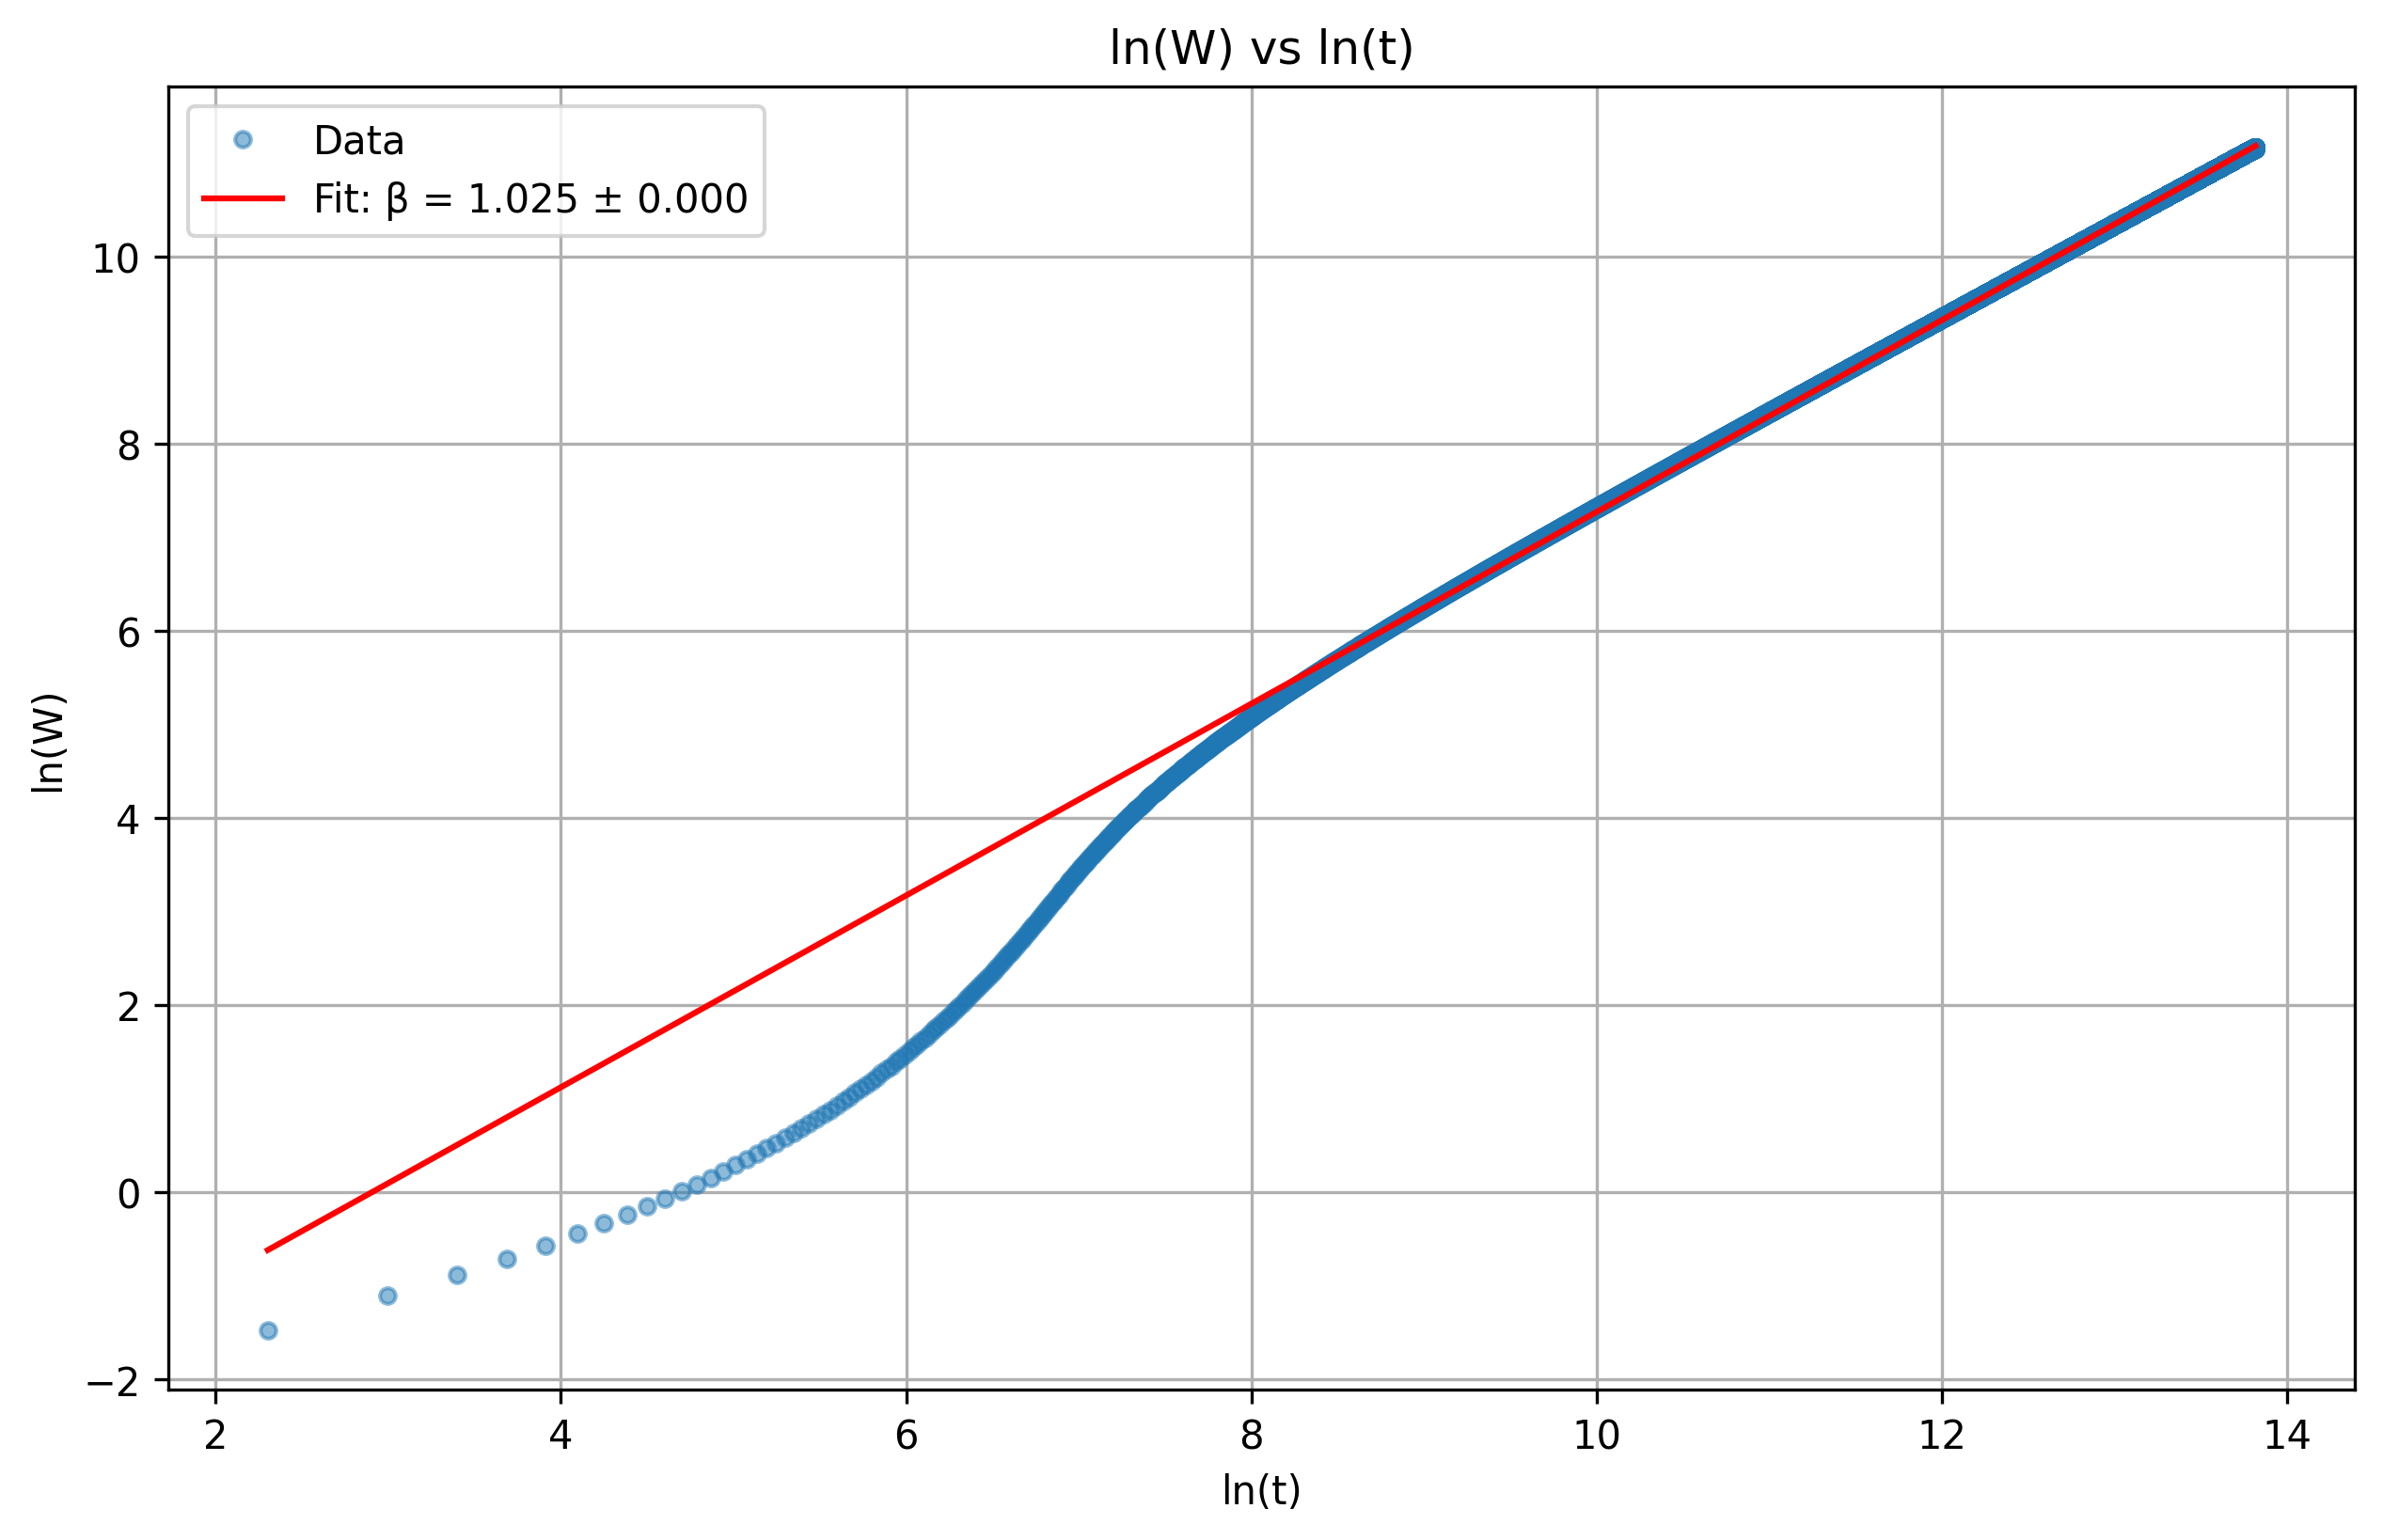

Growth exponent β = 1.0249 ± 0.0002
R-squared value = 0.9973


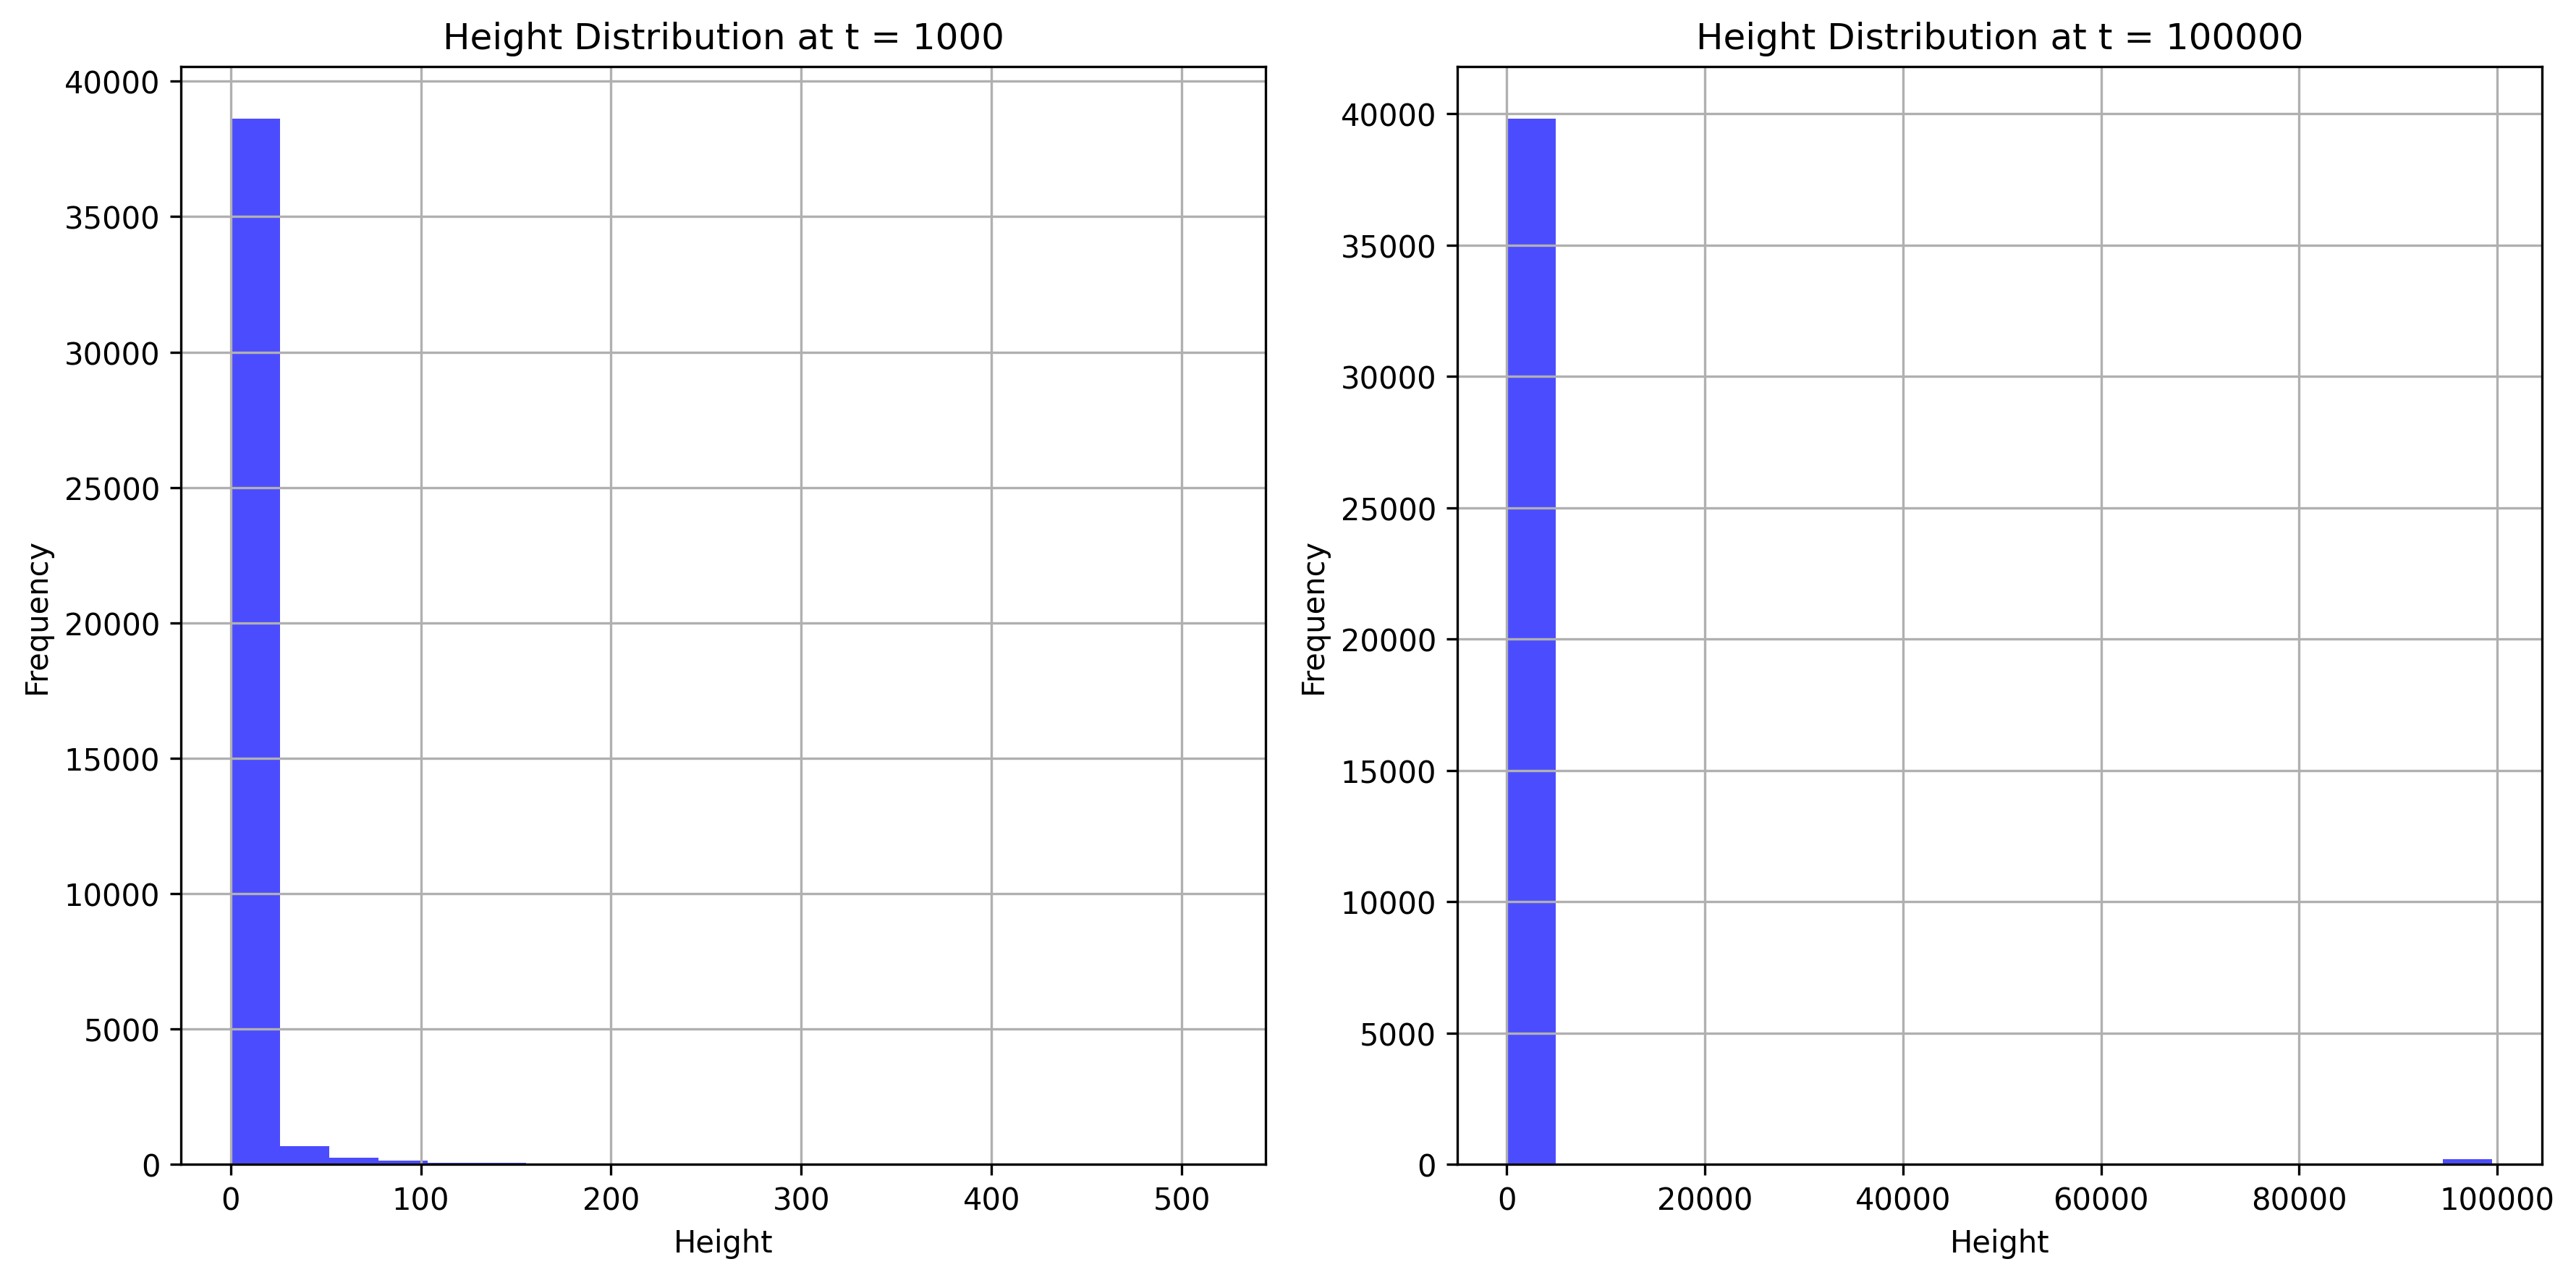

In [ ]:
@njit
def competitive_random_deposition_njit(num_particles, width, tan_phi, times_to_record):
    heights = np.zeros(width, dtype=np.int32)
    roughness_data = []
    height_distributions = np.zeros((len(times_to_record), width), dtype=np.int32)

    for t in range(1, num_particles + 1):
        start_height = np.max(heights) + 10
        x = np.random.randint(0, width)
        y = start_height

        while True:
            x_new = x + tan_phi
            y_new = y - 1

            if x_new >= width or x_new < 0:
                x_new = x_new % width

            x_new_int = int(np.floor(x_new))
            if x_new_int >= width:
                x_new_int = x_new_int % width

            if y_new <= heights[x_new_int]:
                heights[x_new_int] += 1
                break
            else:
                x, y = x_new, y_new

        if t in times_to_record:
            idx = times_to_record.index(t)
            height_distributions[idx] = heights.copy()

        if t % 10 == 0:
            roughness = np.std(heights)
            roughness_data.append((t, roughness))

    return roughness_data, height_distributions

def competitive_random_deposition(num_particles, width, phi_degrees, times_to_record):
    phi = np.radians(phi_degrees)
    tan_phi = np.tan(phi)
    return competitive_random_deposition_njit(num_particles, width, tan_phi, times_to_record)

def plot_ln_roughness_vs_ln_t(roughness_data):
    times = [t for t, _ in roughness_data]
    roughness = [r for _, r in roughness_data]

    ln_t = np.log(times)
    ln_roughness = np.log(roughness)

    slope, intercept, r_value, p_value, std_err = linregress(ln_t, ln_roughness)
    
    fitted_ln_roughness = intercept + slope * ln_t

    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(ln_t, ln_roughness, 'o', markersize=4, alpha=0.5, label='Data')
    plt.plot(ln_t, fitted_ln_roughness, 'r-', 
             label=f'Fit: β = {slope:.3f} ± {std_err:.3f}')
    plt.xlabel('ln(t)')
    plt.ylabel('ln(W)')
    plt.title(f'ln(W) vs ln(t)')
    plt.grid(True)
    plt.legend()
    plt.savefig('CRD_ln_W_vs_ln_t_45deg.png', bbox_inches='tight')
    plt.show()

    print(f"Growth exponent β = {slope:.4f} ± {std_err:.4f}")
    print(f"R-squared value = {r_value**2:.4f}")

def plot_height_distributions(all_height_distributions, times_to_record):
    num_times = len(times_to_record)
    num_cols = 2
    num_rows = (num_times + num_cols - 1) // num_cols

    plt.figure(figsize=(12, 6 * num_rows), dpi=300)
    for i, t in enumerate(times_to_record):
        plt.subplot(num_rows, num_cols, i + 1)
        heights = all_height_distributions[:, i, :].flatten()
        plt.hist(heights, bins=20, color='blue', alpha=0.7)
        plt.xlabel('Height')
        plt.ylabel('Frequency')
        plt.title(f'Height Distribution at t = {t}')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('CRD_PDF_45deg.png', bbox_inches='tight')
    plt.show()

num_particles = 1000000
width = 200
phi_degrees = 45
num_simulations = 200
times_to_record = [1000, 100000]

all_roughness_data = []
all_height_distributions = np.zeros((num_simulations, len(times_to_record), width), dtype=np.int32)

for sim in range(num_simulations):
    roughness_data, height_distributions = competitive_random_deposition(num_particles, width, phi_degrees, times_to_record)
    all_roughness_data.append(roughness_data)
    all_height_distributions[sim] = height_distributions

avg_roughness_data = []
for i in range(len(all_roughness_data[0])):
    t = all_roughness_data[0][i][0]
    avg_roughness = np.mean([data[i][1] for data in all_roughness_data])
    avg_roughness_data.append((t, avg_roughness))

plot_ln_roughness_vs_ln_t(avg_roughness_data)

plot_height_distributions(all_height_distributions, times_to_record)

Slope of the fitted line: -0.5075


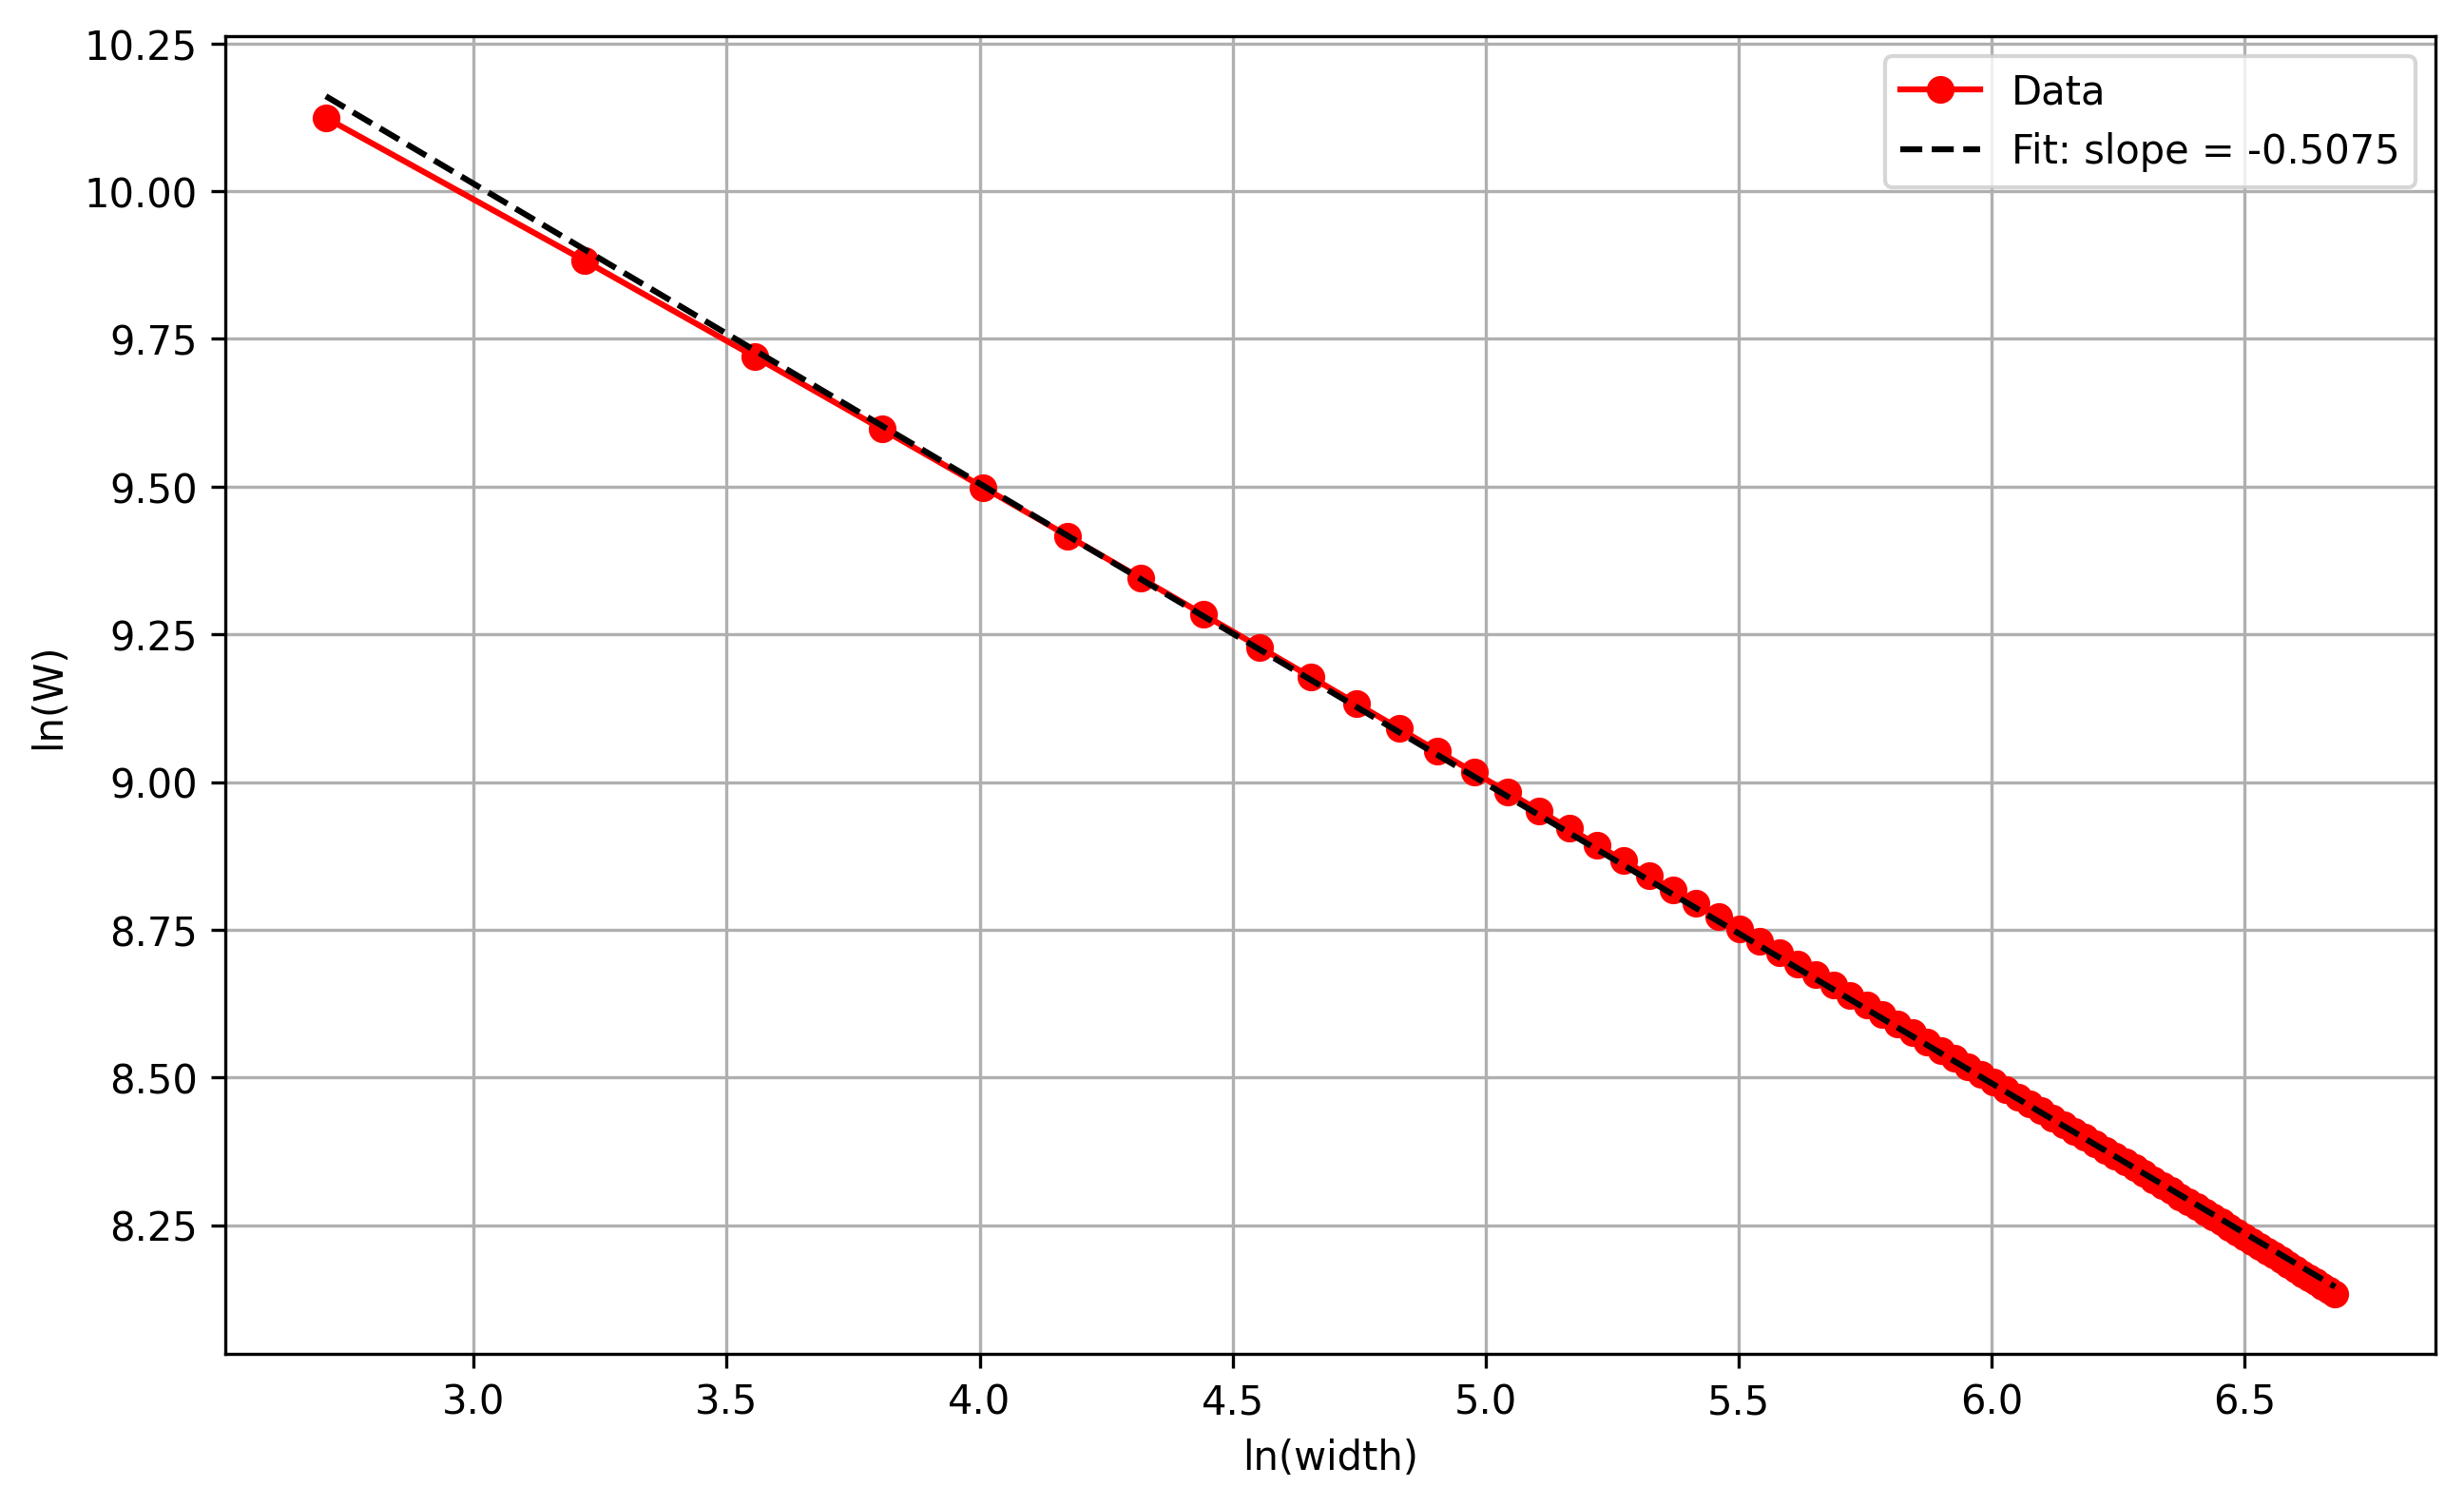

In [ ]:
@njit
def competitive_random_deposition_njit(num_particles, width, tan_phi):
    heights = np.zeros(width, dtype=np.int32)
    roughness_data = []

    for t in range(1, num_particles + 1):
        start_height = np.max(heights) + 10
        x = np.random.randint(0, width)
        y = start_height

        while True:
            x_new = x + tan_phi
            y_new = y - 1

            if x_new >= width or x_new < 0:
                x_new = x_new % width

            x_new_int = int(np.floor(x_new))
            if x_new_int >= width:
                x_new_int = x_new_int % width

            if y_new <= heights[x_new_int]:
                heights[x_new_int] += 1
                break
            else:
                x, y = x_new, y_new

        if t % 10 == 0:
            roughness = np.std(heights)
            roughness_data.append((t, roughness))

    return roughness_data

def competitive_random_deposition(num_particles, width, phi_degrees):
    phi = np.radians(phi_degrees)
    tan_phi = np.tan(phi)
    return competitive_random_deposition_njit(num_particles, width, tan_phi)

def plot_ln_roughness_vs_ln_t(roughness_data):
    times = [t for t, _ in roughness_data]
    roughness = [r for _, r in roughness_data]

    ln_t = np.log(times)
    ln_roughness = np.log(roughness)

    plt.figure(figsize=(10, 6))
    plt.plot(ln_t, ln_roughness, marker='o', linestyle='-', color='blue')
    plt.xlabel('ln(t)')
    plt.ylabel('ln(roughness)')
    plt.title('ln(Roughness) vs ln(t)')
    plt.grid(True)
    plt.show()

def plot_ln_roughness_vs_ln_width(widths, avg_roughness_values):
    avg_roughness_values = np.array(avg_roughness_values)
    avg_roughness_values[avg_roughness_values == 0] = 1e-10

    ln_width = np.log(widths)
    ln_roughness = np.log(avg_roughness_values)

    slope, intercept = np.polyfit(ln_width, ln_roughness, 1)
    print(f"Slope of the fitted line: {slope:.4f}")

    fitted_line = slope * ln_width + intercept

    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(ln_width, ln_roughness, marker='o', linestyle='-', color='red', label='Data')
    plt.plot(ln_width, fitted_line, linestyle='--', color='black', label=f'Fit: slope = {slope:.4f}')
    plt.xlabel('ln(width)')
    plt.ylabel('ln(W)')
    #plt.title('ln(Roughness) vs ln(width)')
    plt.grid(True)
    plt.legend()
    plt.savefig('CRD_lnW_vs_ln_width_45deg.png', bbox_inches='tight')
    plt.show()

num_particles = 100000
phi_degrees = 45
num_simulations = 100
widths = np.arange(15, 800, 10)

avg_roughness_values = []

for width in widths:
    roughness_values = []
    for _ in range(num_simulations):
        roughness_data = competitive_random_deposition(num_particles, width, phi_degrees)
        final_roughness = roughness_data[-1][1]
        roughness_values.append(final_roughness)
    avg_roughness = np.mean(roughness_values)
    avg_roughness_values.append(avg_roughness)

plot_ln_roughness_vs_ln_width(widths, avg_roughness_values)